# 5) RNN

## Load Dataset and Variables

In [1]:
import pandas as pd
import pickle

In [2]:
# Load the data

major_dialog_data = pd.read_pickle("./datasets/major_dialog_data.pkl")
all_dialog_data = pd.read_pickle("./datasets/all_dialog_data.pkl")

with open('./datasets/utterances.pkl', 'rb') as f:
    utterances = pickle.load(f)
    
with open('./datasets/stop_words.pkl', 'rb') as f:
    stop_words = pickle.load(f)

# Pre-process the data similarly to workbook 0

labels = major_dialog_data.speaker

speaker_value_counts = all_dialog_data.speaker.value_counts()
major_speaker_value_counts = speaker_value_counts[speaker_value_counts > 40]
x, y = major_speaker_value_counts.index, major_speaker_value_counts.values

num_major_characters = 6

# a list of the top characters names
major_characters = x[:num_major_characters]
# a set of those same names
major_characters_set = set(major_characters)

# finally, dicts to and from class Ids and their respective names
labels_to_ids = {}
ids_to_labels = {}
for i, major_character in enumerate(major_characters):
    labels_to_ids[major_character] = i
    ids_to_labels[i] = major_character
labels_to_ids

{'Rachel': 0, 'Ross': 1, 'Chandler': 2, 'Monica': 3, 'Joey': 4, 'Phoebe': 5}

## Model - RNN

[http://www.aclweb.org/anthology/P16-2034](http://www.aclweb.org/anthology/P16-2034)

Finally, a bidirectional RNN with attention. RNNs are nice for how they model sequences, but are very hard to interpret. This is why attention is useful. It adds some interpretability to these models, as the attention coefficients indicate the important parts of the input.

In [35]:
import math
import models.rnn as rnn
import numpy as np
import os, sys
import re
import tensorflow as tf
import urllib.request

from datetime import datetime
from gensim.models import KeyedVectors
from importlib import reload
from IPython.display import display, Markdown
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
from util import shuffle, batch_iter, conf_matrix_plot

reload(rnn)

<module 'models.rnn' from '/home/richung/final/analysis/models/rnn.py'>

#### Load embeddings

In [9]:
root_path = Path().resolve().joinpath("..")

embeddings_path = root_path.joinpath("embeddings", "newscrawl.300d.W.pos.vectors.gz")
embeddings_url = "https://www.dropbox.com/s/kguufyc2xcdi8yk/lexvec.enwiki%2Bnewscrawl.300d.W.pos.vectors.gz?dl=1"

# downloads the Word2Vec embeddings (only need to run once)
if not os.path.isfile(embeddings_path):
    print("downloading embeddings...")
    urllib.request.urlretrieve(embeddings_url, embeddings_path)

# Uncomment below to unzip file
# !gunzip {str(embeddings_path)}

In [12]:
# load the vocabulary with the embeddings
embeddings = KeyedVectors.load_word2vec_format(root_path.joinpath("embeddings", "newscrawl.300d.W.pos.vectors"), binary=False)

In [20]:
train_cut = math.ceil(major_dialog_data.utterance.count() * 0.85)
label_ids = np.array([labels_to_ids[label] for label in labels])

cnn_tokenized = []
for utterance in major_dialog_data.utterance:
    words = re.findall(r"[a-z0-9']+", utterance.lower())
    # remove dangling apostrophes and 's at the end of words
    words = [re.sub(r"'s?$", "", word) for word in words]
    words = [re.sub(r"'", "", word) for word in words]
    cnn_tokenized.append(words)

train_x_cnn = cnn_tokenized[:train_cut]
train_y_cnn = label_ids[:train_cut]
test_x_cnn = cnn_tokenized[train_cut:]
test_y_cnn = label_ids[train_cut:]

train_x_cnn = np.array([" ".join(words) for words in train_x_cnn])
test_x_cnn = np.array([" ".join(words) for words in test_x_cnn])

In [21]:
max_seq_len = 32

def embed_and_pad(utterances, embeddings, max_len):
    embedded = np.zeros((utterances.shape[0], max_len, embeddings.vector_size))

    for i, utterance in enumerate(utterances):
        tokens = utterance.split(" ")
        for j in range(max_len):
            if j < len(tokens) and tokens[j] in embeddings.vocab:
                embedded[i, j, :] = embeddings.get_vector(tokens[j])
            else:
                embedded[i, j, :] = np.zeros((embeddings.vector_size))
    return embedded

train_x_rnn = embed_and_pad(train_x_cnn, embeddings, max_seq_len)
test_x_rnn = embed_and_pad(test_x_cnn, embeddings, max_seq_len)

In [24]:
tf.reset_default_graph()

rnn_model = rnn.RNN(embeddings, num_major_characters, hidden_size=64, max_len=max_seq_len)

In [29]:
display_step = 20
num_epochs = 10
batch_size = 128

train_writer = tf.summary.FileWriter("./rnn-board/train")
test_writer = tf.summary.FileWriter("./rnn-board/test")
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_writer.add_graph(sess.graph)
    
    global_step = 0
    X = rnn_model.X
    Y = rnn_model.Y
    keep_prob = rnn_model.keep_prob

    for epoch in range(num_epochs):
        print("{} epoch number: {}".format(datetime.now(), epoch + 1))
        train_x_rnn, train_y_cnn = shuffle(train_x_rnn, train_y_cnn)
        
        for step, x_batch, y_batch in batch_iter(train_x_rnn, train_y_cnn, batch_size):
            global_step += 1
            sess.run(rnn_model.train_op, feed_dict={ X: x_batch, Y: y_batch, keep_prob: 1 })

            # every so often, report the progress of our loss and training accuracy
            if step % display_step == 0:
                summ = sess.run(rnn_model.merged_summary, feed_dict={ X: x_batch, Y: y_batch })
                train_writer.add_summary(summ, global_step=global_step)
                train_writer.flush()

        test_acc, summ = sess.run([rnn_model.accuracy, rnn_model.merged_summary], feed_dict={ X: test_x_rnn, Y: test_y_cnn })
        test_writer.add_summary(summ, global_step=global_step)
        test_writer.flush()
        print("test accuracy = {:.4f}".format(test_acc))
    
    # save the model to disk so we can load it up later for use by `./eval.py`
    saver.save(sess, "./rnn-ckpt/model.ckpt")

2018-12-05 00:28:34.336967 epoch number: 1
test accuracy = 0.2461
2018-12-05 00:29:02.431861 epoch number: 2
test accuracy = 0.2482
2018-12-05 00:29:29.035177 epoch number: 3
test accuracy = 0.2642
2018-12-05 00:29:55.718607 epoch number: 4
test accuracy = 0.2701
2018-12-05 00:30:22.442945 epoch number: 5
test accuracy = 0.2701
2018-12-05 00:30:49.235682 epoch number: 6
test accuracy = 0.2754
2018-12-05 00:31:15.955018 epoch number: 7
test accuracy = 0.2796
2018-12-05 00:31:43.581108 epoch number: 8
test accuracy = 0.2796
2018-12-05 00:32:11.957205 epoch number: 9
test accuracy = 0.2765
2018-12-05 00:32:38.631459 epoch number: 10
test accuracy = 0.2804


### RNN Evaluation

INFO:tensorflow:Restoring parameters from ./rnn-ckpt/model.ckpt
             precision    recall  f1-score   support

     Rachel       0.32      0.36      0.33      1272
       Ross       0.31      0.22      0.26      1206
   Chandler       0.27      0.26      0.27      1193
     Monica       0.24      0.32      0.27      1100
       Joey       0.30      0.30      0.30      1109
     Phoebe       0.25      0.21      0.23      1031

avg / total       0.28      0.28      0.28      6911



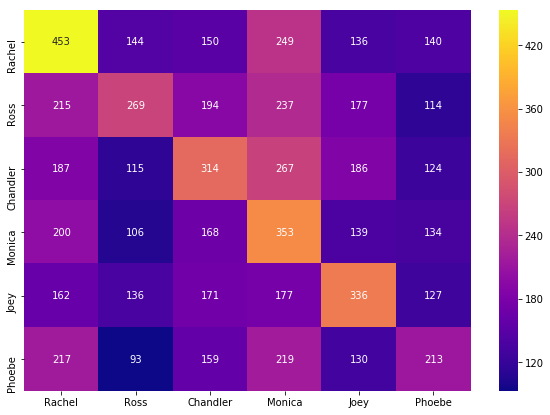

In [32]:
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "./rnn-ckpt/model.ckpt")
    rnn_test_attn, rnn_test_predictions = sess.run((rnn_model.alpha, rnn_model.predictions), feed_dict={ rnn_model.X: test_x_rnn })
    
print(classification_report(test_y_cnn, rnn_test_predictions, target_names=major_characters))

conf_matrix_plot(confusion_matrix(test_y_cnn, rnn_test_predictions), major_characters)

In [33]:
def visualize_attention(sentence, attn, max_len=None):
    attn = attn / np.max(attn)
    tagged_sentence = []
    for i, word in enumerate(sentence):
        opacity = attn[i] if i < len(attn) else 0
        tagged_sentence.append(f'<span style="background-color: rgba(100, 200, 255, {opacity});">{word}</span>')
        if max_len and i == max_len - 1:
            tagged_sentence.append('<span style="color: red;">|</span>')
    display(Markdown(" ".join(tagged_sentence)))

In [36]:
user_input_to_classify = "i love you chandler do you want to go to the restaurant"

rnn_user_input_x = embed_and_pad(np.array([user_input_to_classify]), embeddings, max_seq_len)

with tf.Session() as sess:
    saver.restore(sess, "./rnn-ckpt/model.ckpt")

    rnn_user_attention, (rnn_user_input_pred,) = sess.run((rnn_model.alpha, rnn_model.predictions), feed_dict={ rnn_model.X: rnn_user_input_x })
    
print(major_characters[rnn_user_input_pred])
visualize_attention(user_input_to_classify.split(" "), rnn_user_attention[0], max_len=max_seq_len)

INFO:tensorflow:Restoring parameters from ./rnn-ckpt/model.ckpt
Monica


<span style="background-color: rgba(100, 200, 255, 0.044494692236185074);">i</span> <span style="background-color: rgba(100, 200, 255, 0.11950286477804184);">love</span> <span style="background-color: rgba(100, 200, 255, 0.19063915312290192);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.017922062426805496);">do</span> <span style="background-color: rgba(100, 200, 255, 0.00892620999366045);">you</span> <span style="background-color: rgba(100, 200, 255, 0.004317301791161299);">want</span> <span style="background-color: rgba(100, 200, 255, 0.002638358622789383);">to</span> <span style="background-color: rgba(100, 200, 255, 0.001929766614921391);">go</span> <span style="background-color: rgba(100, 200, 255, 0.0012617805041372776);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0015556596918031573);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0014434254262596369);">restaurant</span>

In [38]:
utterances_to_plot = []
attentions_to_plot = []
original_indices = []

for i in range(num_major_characters):
    display(Markdown("## " + major_characters[i]))
    correct_predictions_i = np.where(np.logical_and(test_y_cnn == i, rnn_test_predictions == i))
    for j in correct_predictions_i[0][:50]:
        sentence = test_x_cnn[j].split(" ")
        if len(sentence) > 1:
            visualize_attention(sentence, rnn_test_attn[j], max_len=max_seq_len)

## Rachel

<span style="background-color: rgba(100, 200, 255, 0.13438192009925842);">i</span> <span style="background-color: rgba(100, 200, 255, 0.18814539909362793);">don</span> <span style="background-color: rgba(100, 200, 255, 0.22993646562099457);">t</span> <span style="background-color: rgba(100, 200, 255, 1.0);">care</span> <span style="background-color: rgba(100, 200, 255, 0.28252512216567993);">i</span> <span style="background-color: rgba(100, 200, 255, 0.16373585164546967);">m</span> <span style="background-color: rgba(100, 200, 255, 0.07984939962625504);">not</span> <span style="background-color: rgba(100, 200, 255, 0.05490165948867798);">going</span> <span style="background-color: rgba(100, 200, 255, 0.03786139562726021);">anywhere</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ohh</span> <span style="background-color: rgba(100, 200, 255, 0.328130841255188);">with</span> <span style="background-color: rgba(100, 200, 255, 0.2505347728729248);">who</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">well</span> <span style="background-color: rgba(100, 200, 255, 0.8190401792526245);">then</span> <span style="background-color: rgba(100, 200, 255, 0.5328946709632874);">you</span> <span style="background-color: rgba(100, 200, 255, 0.31044766306877136);">have</span> <span style="background-color: rgba(100, 200, 255, 0.16009247303009033);">his</span> <span style="background-color: rgba(100, 200, 255, 0.48946771025657654);">baby</span>

<span style="background-color: rgba(100, 200, 255, 0.2966354191303253);">well</span> <span style="background-color: rgba(100, 200, 255, 0.29043081402778625);">i</span> <span style="background-color: rgba(100, 200, 255, 0.2747112810611725);">can</span> <span style="background-color: rgba(100, 200, 255, 0.30368685722351074);">do</span> <span style="background-color: rgba(100, 200, 255, 1.0);">whatever</span> <span style="background-color: rgba(100, 200, 255, 0.5350764393806458);">i</span> <span style="background-color: rgba(100, 200, 255, 0.2735668420791626);">want</span> <span style="background-color: rgba(100, 200, 255, 0.1878899782896042);">i</span> <span style="background-color: rgba(100, 200, 255, 0.05266440659761429);">made</span> <span style="background-color: rgba(100, 200, 255, 0.027289845049381256);">her</span> <span style="background-color: rgba(100, 200, 255, 0.0158324483782053);">come</span> <span style="background-color: rgba(100, 200, 255, 0.015264488756656647);">on</span> <span style="background-color: rgba(100, 200, 255, 0.027552980929613113);">little</span> <span style="background-color: rgba(100, 200, 255, 0.04288116842508316);">girl</span> <span style="background-color: rgba(100, 200, 255, 0.18612265586853027);">hi</span>

<span style="background-color: rgba(100, 200, 255, 0.22715045511722565);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.1658015102148056);">come</span> <span style="background-color: rgba(100, 200, 255, 0.18545255064964294);">on</span> <span style="background-color: rgba(100, 200, 255, 1.0);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.4532630145549774);">it</span> <span style="background-color: rgba(100, 200, 255, 0.2085922807455063);">s</span> <span style="background-color: rgba(100, 200, 255, 0.16257253289222717);">nothing</span> <span style="background-color: rgba(100, 200, 255, 0.06263594329357147);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.010378153994679451);">come</span> <span style="background-color: rgba(100, 200, 255, 0.0068282149732112885);">on</span>

<span style="background-color: rgba(100, 200, 255, 0.012179449200630188);">but</span> <span style="background-color: rgba(100, 200, 255, 0.15639491379261017);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.2481091320514679);">i</span> <span style="background-color: rgba(100, 200, 255, 0.44339069724082947);">don</span> <span style="background-color: rgba(100, 200, 255, 0.7729671001434326);">t</span> <span style="background-color: rgba(100, 200, 255, 1.0);">think</span> <span style="background-color: rgba(100, 200, 255, 0.7329355478286743);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.02279837802052498);">wants</span> <span style="background-color: rgba(100, 200, 255, 0.00724112568423152);">me</span> <span style="background-color: rgba(100, 200, 255, 0.003010891377925873);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0017633825773373246);">move</span> <span style="background-color: rgba(100, 200, 255, 0.0005539400735870004);">into</span> <span style="background-color: rgba(100, 200, 255, 0.00043490197276696563);">his</span> <span style="background-color: rgba(100, 200, 255, 0.00012248130224179476);">apartment</span> <span style="background-color: rgba(100, 200, 255, 0.00015228732081595808);">and</span> <span style="background-color: rgba(100, 200, 255, 9.896879055304453e-05);">disrupt</span> <span style="background-color: rgba(100, 200, 255, 0.00014428260328713804);">his</span> <span style="background-color: rgba(100, 200, 255, 0.00015678376075811684);">life</span> <span style="background-color: rgba(100, 200, 255, 9.671943553257734e-05);">like</span> <span style="background-color: rgba(100, 200, 255, 0.000254775834036991);">that</span> <span style="background-color: rgba(100, 200, 255, 0.00031732654315419495);">i</span> <span style="background-color: rgba(100, 200, 255, 0.00022446845832746476);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.0001381913316436112);">or</span> <span style="background-color: rgba(100, 200, 255, 0.00027612593839876354);">he</span> <span style="background-color: rgba(100, 200, 255, 0.00016848216182552278);">does</span>

<span style="background-color: rgba(100, 200, 255, 0.037184566259384155);">yeah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.2781514823436737);">no</span> <span style="background-color: rgba(100, 200, 255, 0.4526720941066742);">honey</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">no</span> <span style="background-color: rgba(100, 200, 255, 0.40023261308670044);">i</span> <span style="background-color: rgba(100, 200, 255, 0.29924529790878296);">was</span> <span style="background-color: rgba(100, 200, 255, 0.12340237200260162);">just</span> <span style="background-color: rgba(100, 200, 255, 0.11620517820119858);">going</span> <span style="background-color: rgba(100, 200, 255, 0.09177075326442719);">to</span> <span style="background-color: rgba(100, 200, 255, 0.08486723899841309);">do</span> <span style="background-color: rgba(100, 200, 255, 0.06747401505708694);">this</span> <span style="background-color: rgba(100, 200, 255, 0.03730718046426773);">myself</span>

<span style="background-color: rgba(100, 200, 255, 0.21105901896953583);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.8873710632324219);">pheebs</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.4890425503253937);">i</span>

<span style="background-color: rgba(100, 200, 255, 0.5355843901634216);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.43083634972572327);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.5103707313537598);">a</span> <span style="background-color: rgba(100, 200, 255, 0.7897810935974121);">minute</span> <span style="background-color: rgba(100, 200, 255, 0.5010603666305542);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.6525965929031372);">a</span> <span style="background-color: rgba(100, 200, 255, 1.0);">minute</span> <span style="background-color: rgba(100, 200, 255, 0.45104098320007324);">i</span> <span style="background-color: rgba(100, 200, 255, 0.27941837906837463);">i</span> <span style="background-color: rgba(100, 200, 255, 0.18033641576766968);">i</span> <span style="background-color: rgba(100, 200, 255, 0.12391950935125351);">i</span> <span style="background-color: rgba(100, 200, 255, 0.11650400608778);">cant</span> <span style="background-color: rgba(100, 200, 255, 0.0668877586722374);">do</span> <span style="background-color: rgba(100, 200, 255, 0.06459280848503113);">this</span> <span style="background-color: rgba(100, 200, 255, 0.03899183124303818);">listen</span> <span style="background-color: rgba(100, 200, 255, 0.1572985202074051);">honey</span> <span style="background-color: rgba(100, 200, 255, 0.25968170166015625);">this</span> <span style="background-color: rgba(100, 200, 255, 0.32815632224082947);">is</span> <span style="background-color: rgba(100, 200, 255, 0.28149691224098206);">it</span> <span style="background-color: rgba(100, 200, 255, 0.23784422874450684);">not</span> <span style="background-color: rgba(100, 200, 255, 0.1730581670999527);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.13111251592636108);">fault</span> <span style="background-color: rgba(100, 200, 255, 0.10082879662513733);">she</span> <span style="background-color: rgba(100, 200, 255, 0.04551051929593086);">lent</span> <span style="background-color: rgba(100, 200, 255, 0.014971159398555756);">me</span> <span style="background-color: rgba(100, 200, 255, 0.02428356185555458);">the</span> <span style="background-color: rgba(100, 200, 255, 0.02120153233408928);">earrings</span> <span style="background-color: rgba(100, 200, 255, 0.02877107635140419);">and</span> <span style="background-color: rgba(100, 200, 255, 0.043367236852645874);">i</span> <span style="background-color: rgba(100, 200, 255, 0.027041655033826828);">lost</span> <span style="background-color: rgba(100, 200, 255, 0.04834970086812973);">it</span> <span style="background-color: rgba(100, 200, 255, 0.0338556170463562);">im</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">so</span> <span style="background-color: rgba(100, 200, 255, 0);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0);">honey</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">feel</span> <span style="background-color: rgba(100, 200, 255, 0);">terrible</span> <span style="background-color: rgba(100, 200, 255, 0);">too</span>

<span style="background-color: rgba(100, 200, 255, 0.8037736415863037);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">didn</span> <span style="background-color: rgba(100, 200, 255, 0.9482677578926086);">t</span> <span style="background-color: rgba(100, 200, 255, 0.9548068046569824);">i</span> <span style="background-color: rgba(100, 200, 255, 0.815853476524353);">never</span> <span style="background-color: rgba(100, 200, 255, 0.8370925784111023);">said</span> <span style="background-color: rgba(100, 200, 255, 0.452904611825943);">that</span>

<span style="background-color: rgba(100, 200, 255, 0.10918150842189789);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.22729021310806274);">my</span> <span style="background-color: rgba(100, 200, 255, 0.5841802358627319);">god</span> <span style="background-color: rgba(100, 200, 255, 0.5653771162033081);">calling</span> <span style="background-color: rgba(100, 200, 255, 0.33889275789260864);">from</span> <span style="background-color: rgba(100, 200, 255, 0.895961582660675);">rome</span> <span style="background-color: rgba(100, 200, 255, 0.837009072303772);">bon</span> <span style="background-color: rgba(100, 200, 255, 0.3433178961277008);">giorno</span> <span style="background-color: rgba(100, 200, 255, 0.21692544221878052);">caro</span> <span style="background-color: rgba(100, 200, 255, 0.2767425775527954);">mio</span>

<span style="background-color: rgba(100, 200, 255, 0.6054274439811707);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">care</span>

<span style="background-color: rgba(100, 200, 255, 0.680458664894104);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">sorry</span>

<span style="background-color: rgba(100, 200, 255, 0.3000428378582001);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">well</span> <span style="background-color: rgba(100, 200, 255, 0.6962644457817078);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6752904057502747);">know</span> <span style="background-color: rgba(100, 200, 255, 0.560916006565094);">i</span> <span style="background-color: rgba(100, 200, 255, 0.37329399585723877);">think</span> <span style="background-color: rgba(100, 200, 255, 0.33248651027679443);">it</span> <span style="background-color: rgba(100, 200, 255, 0.6631680130958557);">kinda</span> <span style="background-color: rgba(100, 200, 255, 0.20337997376918793);">really</span> <span style="background-color: rgba(100, 200, 255, 0.32798367738723755);">important</span> <span style="background-color: rgba(100, 200, 255, 0.2196682244539261);">that</span> <span style="background-color: rgba(100, 200, 255, 0.13903921842575073);">i</span> <span style="background-color: rgba(100, 200, 255, 0.09594544768333435);">go</span> <span style="background-color: rgba(100, 200, 255, 0.05526219308376312);">somewhere</span> <span style="background-color: rgba(100, 200, 255, 0.13918328285217285);">where</span> <span style="background-color: rgba(100, 200, 255, 0.06534260511398315);">there</span> <span style="background-color: rgba(100, 200, 255, 0.11012818664312363);">sun</span> <span style="background-color: rgba(100, 200, 255, 0.08191584795713425);">so</span> <span style="background-color: rgba(100, 200, 255, 0.07150377333164215);">im</span> <span style="background-color: rgba(100, 200, 255, 0.03506091982126236);">sort</span> <span style="background-color: rgba(100, 200, 255, 0.04299324378371239);">of</span> <span style="background-color: rgba(100, 200, 255, 0.08985234051942825);">hey</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.4957955777645111);">look</span> <span style="background-color: rgba(100, 200, 255, 0.38997018337249756);">at</span> <span style="background-color: rgba(100, 200, 255, 0.34226271510124207);">you</span> <span style="background-color: rgba(100, 200, 255, 0.20280131697654724);">making</span> <span style="background-color: rgba(100, 200, 255, 0.10234688967466354);">up</span> <span style="background-color: rgba(100, 200, 255, 0.19012092053890228);">crap</span> <span style="background-color: rgba(100, 200, 255, 0.1417902112007141);">for</span> <span style="background-color: rgba(100, 200, 255, 0.08237851411104202);">me</span> <span style="background-color: rgba(100, 200, 255, 0.31244003772735596);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.7512623071670532);">god</span>

<span style="background-color: rgba(100, 200, 255, 0.10404003411531448);">mm</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mmm</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hi</span> <span style="background-color: rgba(100, 200, 255, 0.42326849699020386);">monica</span>

<span style="background-color: rgba(100, 200, 255, 0.10290227085351944);">you</span> <span style="background-color: rgba(100, 200, 255, 0.14911171793937683);">and</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ralph</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8678600192070007);">know</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.13800254464149475);">are</span> <span style="background-color: rgba(100, 200, 255, 0.09178401529788971);">you</span> <span style="background-color: rgba(100, 200, 255, 0.05873599275946617);">in</span> <span style="background-color: rgba(100, 200, 255, 0.08545835316181183);">there</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">pancho</span> <span style="background-color: rgba(100, 200, 255, 0.23055648803710938);">vila</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.6614900231361389);">come</span> <span style="background-color: rgba(100, 200, 255, 0.7970669865608215);">on</span> <span style="background-color: rgba(100, 200, 255, 0.9467663168907166);">i</span> <span style="background-color: rgba(100, 200, 255, 0.474676251411438);">already</span> <span style="background-color: rgba(100, 200, 255, 0.23544207215309143);">went</span>

<span style="background-color: rgba(100, 200, 255, 0.04573271423578262);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.21611899137496948);">god</span> <span style="background-color: rgba(100, 200, 255, 1.0);">y</span> <span style="background-color: rgba(100, 200, 255, 0.2548713684082031);">know</span> <span style="background-color: rgba(100, 200, 255, 0.21074271202087402);">if</span> <span style="background-color: rgba(100, 200, 255, 0.11082180589437485);">someone</span> <span style="background-color: rgba(100, 200, 255, 0.14787212014198303);">told</span> <span style="background-color: rgba(100, 200, 255, 0.07787136733531952);">me</span> <span style="background-color: rgba(100, 200, 255, 0.13057959079742432);">a</span> <span style="background-color: rgba(100, 200, 255, 0.1594882309436798);">week</span> <span style="background-color: rgba(100, 200, 255, 0.26643598079681396);">ago</span> <span style="background-color: rgba(100, 200, 255, 0.2441621869802475);">that</span> <span style="background-color: rgba(100, 200, 255, 0.22748397290706635);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1174461841583252);">would</span> <span style="background-color: rgba(100, 200, 255, 0.043412331491708755);">be</span> <span style="background-color: rgba(100, 200, 255, 0.15821930766105652);">peeing</span> <span style="background-color: rgba(100, 200, 255, 0.05849693343043327);">in</span> <span style="background-color: rgba(100, 200, 255, 0.07716446369886398);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.032823871821165085);">tribbiani</span> <span style="background-color: rgba(100, 200, 255, 0.0025113169103860855);">s</span> <span style="background-color: rgba(100, 200, 255, 0.0003912567626684904);">apartment</span>

<span style="background-color: rgba(100, 200, 255, 0.5505839586257935);">ooh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">honey</span> <span style="background-color: rgba(100, 200, 255, 0.543539822101593);">it</span> <span style="background-color: rgba(100, 200, 255, 0.7976256012916565);">cant</span> <span style="background-color: rgba(100, 200, 255, 0.18097996711730957);">be</span> <span style="background-color: rgba(100, 200, 255, 0.1497264802455902);">that</span> <span style="background-color: rgba(100, 200, 255, 0.16710840165615082);">hard</span> <span style="background-color: rgba(100, 200, 255, 0.14759135246276855);">i</span> <span style="background-color: rgba(100, 200, 255, 0.08329479396343231);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.029955457895994186);">youve</span> <span style="background-color: rgba(100, 200, 255, 0.020305965095758438);">been</span> <span style="background-color: rgba(100, 200, 255, 0.007466682232916355);">in</span> <span style="background-color: rgba(100, 200, 255, 0.008249307051301003);">love</span> <span style="background-color: rgba(100, 200, 255, 0.006627686321735382);">before</span>

<span style="background-color: rgba(100, 200, 255, 0.0985715389251709);">hm</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mmm</span>

<span style="background-color: rgba(100, 200, 255, 0.055221281945705414);">i</span> <span style="background-color: rgba(100, 200, 255, 0.07460898905992508);">did</span> <span style="background-color: rgba(100, 200, 255, 0.09678308665752411);">it</span> <span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.17791235446929932);">i</span> <span style="background-color: rgba(100, 200, 255, 0.13381458818912506);">finished</span> <span style="background-color: rgba(100, 200, 255, 0.06737537682056427);">it</span> <span style="background-color: rgba(100, 200, 255, 0.0629035085439682);">i</span> <span style="background-color: rgba(100, 200, 255, 0.046679574996232986);">did</span> <span style="background-color: rgba(100, 200, 255, 0.02026834525167942);">it</span> <span style="background-color: rgba(100, 200, 255, 0.01669819839298725);">all</span> <span style="background-color: rgba(100, 200, 255, 0.03121820092201233);">by</span> <span style="background-color: rgba(100, 200, 255, 0.021535033360123634);">myself</span> <span style="background-color: rgba(100, 200, 255, 0.03569716215133667);">and</span> <span style="background-color: rgba(100, 200, 255, 0.021376363933086395);">there</span> <span style="background-color: rgba(100, 200, 255, 0.015459400601685047);">nobody</span> <span style="background-color: rgba(100, 200, 255, 0.005655892193317413);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0038263604510575533);">hug</span>

<span style="background-color: rgba(100, 200, 255, 0.44445374608039856);">noo</span> <span style="background-color: rgba(100, 200, 255, 0.31650251150131226);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.34523651003837585);">of</span> <span style="background-color: rgba(100, 200, 255, 0.9725533127784729);">course</span> <span style="background-color: rgba(100, 200, 255, 1.0);">there</span> <span style="background-color: rgba(100, 200, 255, 0.6700226068496704);">is</span> <span style="background-color: rgba(100, 200, 255, 0.4041677415370941);">more</span> <span style="background-color: rgba(100, 200, 255, 0.7688377499580383);">i</span> <span style="background-color: rgba(100, 200, 255, 0.35904479026794434);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.07803527265787125);">ill</span> <span style="background-color: rgba(100, 200, 255, 0.10652443766593933);">just</span> <span style="background-color: rgba(100, 200, 255, 0.09687110036611557);">go</span> <span style="background-color: rgba(100, 200, 255, 0.06072354316711426);">and</span> <span style="background-color: rgba(100, 200, 255, 0.03934691473841667);">talk</span> <span style="background-color: rgba(100, 200, 255, 0.04242895543575287);">to</span> <span style="background-color: rgba(100, 200, 255, 0.03566752374172211);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.00638155359774828);">and</span> <span style="background-color: rgba(100, 200, 255, 0.007077029440551996);">get</span> <span style="background-color: rgba(100, 200, 255, 0.0055886320769786835);">an</span> <span style="background-color: rgba(100, 200, 255, 0.006848644930869341);">eta</span> <span style="background-color: rgba(100, 200, 255, 0.0036129113286733627);">on</span> <span style="background-color: rgba(100, 200, 255, 0.007500053383409977);">the</span> <span style="background-color: rgba(100, 200, 255, 0.025434404611587524);">pee</span> <span style="background-color: rgba(100, 200, 255, 0.056293051689863205);">pee</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">gavin</span> <span style="background-color: rgba(100, 200, 255, 0.03730779513716698);">i</span> <span style="background-color: rgba(100, 200, 255, 0.017227163538336754);">just</span> <span style="background-color: rgba(100, 200, 255, 0.019108252599835396);">wanted</span> <span style="background-color: rgba(100, 200, 255, 0.019190821796655655);">to</span> <span style="background-color: rgba(100, 200, 255, 0.03843123838305473);">say</span> <span style="background-color: rgba(100, 200, 255, 0.07015695422887802);">thank</span> <span style="background-color: rgba(100, 200, 255, 0.032811522483825684);">you</span> <span style="background-color: rgba(100, 200, 255, 0.028222061693668365);">again</span> <span style="background-color: rgba(100, 200, 255, 0.030678439885377884);">for</span> <span style="background-color: rgba(100, 200, 255, 0.05165495723485947);">watching</span> <span style="background-color: rgba(100, 200, 255, 0.03897532448172569);">emma</span> <span style="background-color: rgba(100, 200, 255, 0.004036605823785067);">yesterday</span> <span style="background-color: rgba(100, 200, 255, 0.0027839778922498226);">during</span> <span style="background-color: rgba(100, 200, 255, 0.0041179112158715725);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0036416177172213793);">presentation</span> <span style="background-color: rgba(100, 200, 255, 0.004264144226908684);">i</span> <span style="background-color: rgba(100, 200, 255, 0.002985493978485465);">really</span> <span style="background-color: rgba(100, 200, 255, 0.0019671355839818716);">owe</span> <span style="background-color: rgba(100, 200, 255, 0.001251325011253357);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0006933750119060278);">an</span> <span style="background-color: rgba(100, 200, 255, 0.00028592950548045337);">appology</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">excuse</span> <span style="background-color: rgba(100, 200, 255, 0.40681448578834534);">me</span>

<span style="background-color: rgba(100, 200, 255, 0.008160270750522614);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.02015959471464157);">my</span> <span style="background-color: rgba(100, 200, 255, 0.06919120252132416);">god</span> <span style="background-color: rgba(100, 200, 255, 1.0);">cmon</span> <span style="background-color: rgba(100, 200, 255, 0.08928050100803375);">you</span> <span style="background-color: rgba(100, 200, 255, 0.07261866331100464);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.04872334748506546);">he</span> <span style="background-color: rgba(100, 200, 255, 0.07283252477645874);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.017328863963484764);">be</span> <span style="background-color: rgba(100, 200, 255, 0.02288217842578888);">home</span> <span style="background-color: rgba(100, 200, 255, 0.015850456431508064);">any</span> <span style="background-color: rgba(100, 200, 255, 0.018822818994522095);">minute</span> <span style="background-color: rgba(100, 200, 255, 0.016823355108499527);">he</span> <span style="background-color: rgba(100, 200, 255, 0.011752964928746223);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.006557634100317955);">kill</span> <span style="background-color: rgba(100, 200, 255, 0.0023515804205089808);">me</span>

<span style="background-color: rgba(100, 200, 255, 0.13392677903175354);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.5031694173812866);">joey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">kinda</span> <span style="background-color: rgba(100, 200, 255, 0.31472286581993103);">disabled</span> <span style="background-color: rgba(100, 200, 255, 0.10761822015047073);">it</span> <span style="background-color: rgba(100, 200, 255, 0.11363375931978226);">when</span> <span style="background-color: rgba(100, 200, 255, 0.06253478676080704);">i</span> <span style="background-color: rgba(100, 200, 255, 0.015642846003174782);">moved</span> <span style="background-color: rgba(100, 200, 255, 0.007192021701484919);">in</span>

<span style="background-color: rgba(100, 200, 255, 0.6033294200897217);">well</span> <span style="background-color: rgba(100, 200, 255, 0.632606029510498);">as</span> <span style="background-color: rgba(100, 200, 255, 1.0);">long</span> <span style="background-color: rgba(100, 200, 255, 0.9956576228141785);">as</span> <span style="background-color: rgba(100, 200, 255, 0.7778153419494629);">we</span> <span style="background-color: rgba(100, 200, 255, 0.5085834264755249);">are</span> <span style="background-color: rgba(100, 200, 255, 0.5653077363967896);">clear</span> <span style="background-color: rgba(100, 200, 255, 0.41511958837509155);">about</span> <span style="background-color: rgba(100, 200, 255, 0.4931124150753021);">that</span>

<span style="background-color: rgba(100, 200, 255, 0.0985715389251709);">hm</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mmm</span>

<span style="background-color: rgba(100, 200, 255, 0.20211456716060638);">come</span> <span style="background-color: rgba(100, 200, 255, 0.1908801645040512);">on</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joey</span>

<span style="background-color: rgba(100, 200, 255, 0.1992853581905365);">all</span> <span style="background-color: rgba(100, 200, 255, 0.5384344458580017);">right</span> <span style="background-color: rgba(100, 200, 255, 0.613650381565094);">that</span> <span style="background-color: rgba(100, 200, 255, 1.0);">s</span> <span style="background-color: rgba(100, 200, 255, 0.40692827105522156);">it</span> <span style="background-color: rgba(100, 200, 255, 0.3335183560848236);">i</span> <span style="background-color: rgba(100, 200, 255, 0.165110781788826);">am</span> <span style="background-color: rgba(100, 200, 255, 0.12262802571058273);">maid</span> <span style="background-color: rgba(100, 200, 255, 0.08122843503952026);">of</span> <span style="background-color: rgba(100, 200, 255, 0.09000008553266525);">honor</span>

## Ross

<span style="background-color: rgba(100, 200, 255, 0.515326976776123);">no</span> <span style="background-color: rgba(100, 200, 255, 1.0);">susan</span> <span style="background-color: rgba(100, 200, 255, 0.19149857759475708);">s</span> <span style="background-color: rgba(100, 200, 255, 0.20577406883239746);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.10027295351028442);">be</span> <span style="background-color: rgba(100, 200, 255, 0.19818592071533203);">there</span> <span style="background-color: rgba(100, 200, 255, 0.17787277698516846);">too</span> <span style="background-color: rgba(100, 200, 255, 0.2141367793083191);">we</span> <span style="background-color: rgba(100, 200, 255, 0.170511856675148);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.14997413754463196);">got</span> <span style="background-color: rgba(100, 200, 255, 0.3672729432582855);">dads</span> <span style="background-color: rgba(100, 200, 255, 0.08700065314769745);">we</span> <span style="background-color: rgba(100, 200, 255, 0.043633487075567245);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.019479360431432724);">got</span> <span style="background-color: rgba(100, 200, 255, 0.007813636213541031);">lesbians</span> <span style="background-color: rgba(100, 200, 255, 0.004860706627368927);">the</span> <span style="background-color: rgba(100, 200, 255, 0.00891883298754692);">whole</span> <span style="background-color: rgba(100, 200, 255, 0.021480048075318336);">parenting</span> <span style="background-color: rgba(100, 200, 255, 0.008920108899474144);">team</span>

<span style="background-color: rgba(100, 200, 255, 0.26892614364624023);">i</span> <span style="background-color: rgba(100, 200, 255, 0.21282707154750824);">have</span> <span style="background-color: rgba(100, 200, 255, 0.14385777711868286);">to</span> <span style="background-color: rgba(100, 200, 255, 0.18232318758964539);">say</span> <span style="background-color: rgba(100, 200, 255, 0.13759620487689972);">you</span> <span style="background-color: rgba(100, 200, 255, 0.11003275960683823);">are</span> <span style="background-color: rgba(100, 200, 255, 0.15156859159469604);">a</span> <span style="background-color: rgba(100, 200, 255, 0.15919901430606842);">much</span> <span style="background-color: rgba(100, 200, 255, 0.3355584740638733);">bigger</span> <span style="background-color: rgba(100, 200, 255, 0.24858322739601135);">person</span> <span style="background-color: rgba(100, 200, 255, 0.19329875707626343);">than</span> <span style="background-color: rgba(100, 200, 255, 0.1915031373500824);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1681225597858429);">am</span> <span style="background-color: rgba(100, 200, 255, 0.13185521960258484);">i</span> <span style="background-color: rgba(100, 200, 255, 0.10645479708909988);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.12397307902574539);">after</span> <span style="background-color: rgba(100, 200, 255, 0.10745274275541306);">all</span> <span style="background-color: rgba(100, 200, 255, 0.11093452572822571);">we</span> <span style="background-color: rgba(100, 200, 255, 0.08699727058410645);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.0639173611998558);">been</span> <span style="background-color: rgba(100, 200, 255, 0.12031743675470352);">through</span> <span style="background-color: rgba(100, 200, 255, 0.16667556762695312);">i</span> <span style="background-color: rgba(100, 200, 255, 0.19851964712142944);">just</span> <span style="background-color: rgba(100, 200, 255, 1.0);">y</span> <span style="background-color: rgba(100, 200, 255, 0.4942578971385956);">know</span> <span style="background-color: rgba(100, 200, 255, 0.44378846883773804);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3517667055130005);">wish</span> <span style="background-color: rgba(100, 200, 255, 0.2880184054374695);">i</span> <span style="background-color: rgba(100, 200, 255, 0.08340305835008621);">had</span> <span style="background-color: rgba(100, 200, 255, 0.06048409640789032);">a</span> <span style="background-color: rgba(100, 200, 255, 0.11024031788110733);">brother</span> <span style="background-color: rgba(100, 200, 255, 0.04627635329961777);">to</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">reciprocate</span> <span style="background-color: rgba(100, 200, 255, 0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0);">if</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">ever</span> <span style="background-color: rgba(100, 200, 255, 0);">want</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">go</span> <span style="background-color: rgba(100, 200, 255, 0);">out</span> <span style="background-color: rgba(100, 200, 255, 0);">with</span> <span style="background-color: rgba(100, 200, 255, 0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">have</span> <span style="background-color: rgba(100, 200, 255, 0);">my</span> <span style="background-color: rgba(100, 200, 255, 0);">blessing</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">two</span> <span style="background-color: rgba(100, 200, 255, 0.724295437335968);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3721337616443634);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.12840667366981506);">been</span> <span style="background-color: rgba(100, 200, 255, 0.06561461091041565);">engaged</span> <span style="background-color: rgba(100, 200, 255, 0.04523298889398575);">twice</span>

<span style="background-color: rgba(100, 200, 255, 0.1144704818725586);">and</span> <span style="background-color: rgba(100, 200, 255, 0.16690222918987274);">you</span> <span style="background-color: rgba(100, 200, 255, 0.08140961080789566);">called</span> <span style="background-color: rgba(100, 200, 255, 0.0652930811047554);">him</span> <span style="background-color: rgba(100, 200, 255, 0.4100155830383301);">alby</span> <span style="background-color: rgba(100, 200, 255, 0.41878700256347656);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3045947253704071);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.11709539592266083);">that</span> <span style="background-color: rgba(100, 200, 255, 0.11127778142690659);">like</span> <span style="background-color: rgba(100, 200, 255, 0.18178042769432068);">like</span> <span style="background-color: rgba(100, 200, 255, 0.341208815574646);">calling</span> <span style="background-color: rgba(100, 200, 255, 1.0);">albert</span> <span style="background-color: rgba(100, 200, 255, 0.15262694656848907);">einstein</span> <span style="background-color: rgba(100, 200, 255, 0.4443033039569855);">er</span> <span style="background-color: rgba(100, 200, 255, 0.08035443723201752);">alby</span>

<span style="background-color: rgba(100, 200, 255, 0.4276319742202759);">after</span> <span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.8731101751327515);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7416786551475525);">did</span> <span style="background-color: rgba(100, 200, 255, 0.2958674430847168);">can</span> <span style="background-color: rgba(100, 200, 255, 0.1855730563402176);">you</span> <span style="background-color: rgba(100, 200, 255, 0.15438665449619293);">blame</span> <span style="background-color: rgba(100, 200, 255, 0.09220636636018753);">her</span>

<span style="background-color: rgba(100, 200, 255, 0.5698422193527222);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.5304468274116516);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6734589338302612);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.4016386568546295);">it</span> <span style="background-color: rgba(100, 200, 255, 0.17246174812316895);">been</span> <span style="background-color: rgba(100, 200, 255, 0.4960590600967407);">kinda</span> <span style="background-color: rgba(100, 200, 255, 0.15045055747032166);">quiet</span> <span style="background-color: rgba(100, 200, 255, 0.23041585087776184);">since</span> <span style="background-color: rgba(100, 200, 255, 1.0);">carol</span> <span style="background-color: rgba(100, 200, 255, 0.04691369831562042);">left</span> <span style="background-color: rgba(100, 200, 255, 0.023777849972248077);">so</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">gunther</span> <span style="background-color: rgba(100, 200, 255, 0.31567808985710144);">gunther</span> <span style="background-color: rgba(100, 200, 255, 0.10064839571714401);">gunther</span> <span style="background-color: rgba(100, 200, 255, 0.010493811219930649);">please</span> <span style="background-color: rgba(100, 200, 255, 0.010005899704992771);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.007279602345079184);">me</span> <span style="background-color: rgba(100, 200, 255, 0.012042658403515816);">you</span> <span style="background-color: rgba(100, 200, 255, 0.015165175311267376);">didn</span> <span style="background-color: rgba(100, 200, 255, 0.017900753766298294);">t</span> <span style="background-color: rgba(100, 200, 255, 0.024184634909033775);">say</span> <span style="background-color: rgba(100, 200, 255, 0.024804530665278435);">anything</span> <span style="background-color: rgba(100, 200, 255, 0.030366091057658195);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1280522495508194);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.010448629036545753);">about</span> <span style="background-color: rgba(100, 200, 255, 0.005518067628145218);">me</span> <span style="background-color: rgba(100, 200, 255, 0.003143029985949397);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0016995127080008388);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0008588816854171455);">girl</span> <span style="background-color: rgba(100, 200, 255, 0.00044350422103889287);">from</span> <span style="background-color: rgba(100, 200, 255, 0.000746303005144);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0003711462486535311);">xerox</span> <span style="background-color: rgba(100, 200, 255, 0.00034950123517774045);">place</span>

<span style="background-color: rgba(100, 200, 255, 0.03358539938926697);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.1282339096069336);">no</span> <span style="background-color: rgba(100, 200, 255, 0.10148113965988159);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0.09241747856140137);">it</span> <span style="background-color: rgba(100, 200, 255, 0.056817881762981415);">me</span> <span style="background-color: rgba(100, 200, 255, 0.04259093478322029);">im</span> <span style="background-color: rgba(100, 200, 255, 0.03743339702486992);">just</span> <span style="background-color: rgba(100, 200, 255, 0.040954288095235825);">not</span> <span style="background-color: rgba(100, 200, 255, 0.05195791646838188);">giving</span> <span style="background-color: rgba(100, 200, 255, 0.03093608468770981);">you</span> <span style="background-color: rgba(100, 200, 255, 0.03223705291748047);">enough</span> <span style="background-color: rgba(100, 200, 255, 0.0895397961139679);">credit</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.09244537353515625);">i</span> <span style="background-color: rgba(100, 200, 255, 0.05590609461069107);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.03198368847370148);">it</span> <span style="background-color: rgba(100, 200, 255, 0.01997201330959797);">is</span> <span style="background-color: rgba(100, 200, 255, 0.012741337530314922);">difficult</span> <span style="background-color: rgba(100, 200, 255, 0.0068129911087453365);">to</span> <span style="background-color: rgba(100, 200, 255, 0.007132116239517927);">say</span> <span style="background-color: rgba(100, 200, 255, 0.003114445600658655);">goodbye</span> <span style="background-color: rgba(100, 200, 255, 0.003913647960871458);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0046384637244045734);">five</span> <span style="background-color: rgba(100, 200, 255, 0.008413542993366718);">people</span> <span style="background-color: rgba(100, 200, 255, 0.2736821472644806);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.03878374397754669);">goodbye</span> <span style="background-color: rgba(100, 200, 255, 0.03872191905975342);">goodbye</span> <span style="background-color: rgba(100, 200, 255, 0.04338407516479492);">goodbye</span> <span style="background-color: rgba(100, 200, 255, 0.0404239259660244);">goodbye</span> <span style="background-color: rgba(100, 200, 255, 0.0180395245552063);">good</span> <span style="background-color: rgba(100, 200, 255, 0.015862228348851204);">it</span> <span style="background-color: rgba(100, 200, 255, 0.007168428041040897);">physically</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">impossible</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">know</span> <span style="background-color: rgba(100, 200, 255, 0);">what</span> <span style="background-color: rgba(100, 200, 255, 0);">after</span> <span style="background-color: rgba(100, 200, 255, 0);">all</span> <span style="background-color: rgba(100, 200, 255, 0);">weve</span> <span style="background-color: rgba(100, 200, 255, 0);">been</span> <span style="background-color: rgba(100, 200, 255, 0);">through</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">cant</span> <span style="background-color: rgba(100, 200, 255, 0);">believe</span> <span style="background-color: rgba(100, 200, 255, 0);">this</span> <span style="background-color: rgba(100, 200, 255, 0);">is</span> <span style="background-color: rgba(100, 200, 255, 0);">how</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">want</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">leave</span> <span style="background-color: rgba(100, 200, 255, 0);">things</span> <span style="background-color: rgba(100, 200, 255, 0);">between</span> <span style="background-color: rgba(100, 200, 255, 0);">us</span> <span style="background-color: rgba(100, 200, 255, 0);">have</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">have</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">good</span> <span style="background-color: rgba(100, 200, 255, 0);">time</span> <span style="background-color: rgba(100, 200, 255, 0);">in</span> <span style="background-color: rgba(100, 200, 255, 0);">paris</span>

<span style="background-color: rgba(100, 200, 255, 0.3551102876663208);">good</span> <span style="background-color: rgba(100, 200, 255, 0.8738490343093872);">good</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8412156105041504);">m</span> <span style="background-color: rgba(100, 200, 255, 0.6409305930137634);">i</span> <span style="background-color: rgba(100, 200, 255, 0.28879594802856445);">m</span> <span style="background-color: rgba(100, 200, 255, 0.3528525233268738);">married</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.5620246529579163);">a</span> <span style="background-color: rgba(100, 200, 255, 0.9180320501327515);">minute</span> <span style="background-color: rgba(100, 200, 255, 0.38523197174072266);">she</span> <span style="background-color: rgba(100, 200, 255, 0.11753424257040024);">was</span> <span style="background-color: rgba(100, 200, 255, 0.05022569000720978);">walking</span> <span style="background-color: rgba(100, 200, 255, 0.07079429179430008);">the</span> <span style="background-color: rgba(100, 200, 255, 0.10640059411525726);">bike</span> <span style="background-color: rgba(100, 200, 255, 0.08645210415124893);">both</span> <span style="background-color: rgba(100, 200, 255, 0.082915760576725);">times</span>

<span style="background-color: rgba(100, 200, 255, 0.5254437923431396);">so</span> <span style="background-color: rgba(100, 200, 255, 0.6197314262390137);">is</span> <span style="background-color: rgba(100, 200, 255, 0.6891146898269653);">everybody</span> <span style="background-color: rgba(100, 200, 255, 0.5645924806594849);">here</span> <span style="background-color: rgba(100, 200, 255, 0.8348532319068909);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4670487940311432);">got</span> <span style="background-color: rgba(100, 200, 255, 0.3260878324508667);">here</span> <span style="background-color: rgba(100, 200, 255, 0.43901899456977844);">a</span> <span style="background-color: rgba(100, 200, 255, 0.7742424607276917);">little</span> <span style="background-color: rgba(100, 200, 255, 1.0);">early</span> <span style="background-color: rgba(100, 200, 255, 0.9048095345497131);">myself</span> <span style="background-color: rgba(100, 200, 255, 0.8747751712799072);">let</span> <span style="background-color: rgba(100, 200, 255, 0.7364935874938965);">us</span> <span style="background-color: rgba(100, 200, 255, 0.4472787082195282);">begin</span> <span style="background-color: rgba(100, 200, 255, 0.2321651577949524);">now</span> <span style="background-color: rgba(100, 200, 255, 0.17272856831550598);">the</span> <span style="background-color: rgba(100, 200, 255, 0.15522634983062744);">hydrosaurids</span> <span style="background-color: rgba(100, 200, 255, 0.040538061410188675);">have</span> <span style="background-color: rgba(100, 200, 255, 0.012900001369416714);">been</span> <span style="background-color: rgba(100, 200, 255, 0.006509702652692795);">unearthed</span> <span style="background-color: rgba(100, 200, 255, 0.004773902706801891);">in</span> <span style="background-color: rgba(100, 200, 255, 0.004186669830232859);">two</span> <span style="background-color: rgba(100, 200, 255, 0.004666013643145561);">main</span> <span style="background-color: rgba(100, 200, 255, 0.004426741041243076);">locations</span> <span style="background-color: rgba(100, 200, 255, 0.002575220540165901);">here</span> <span style="background-color: rgba(100, 200, 255, 0.002778850495815277);">here</span> <span style="background-color: rgba(100, 200, 255, 0.003115119645372033);">now</span> <span style="background-color: rgba(100, 200, 255, 0.0026736208237707615);">as</span> <span style="background-color: rgba(100, 200, 255, 0.0029327315278351307);">for</span> <span style="background-color: rgba(100, 200, 255, 0.005455860868096352);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0074190404266119);">hydrosaurs</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">he</span> <span style="background-color: rgba(100, 200, 255, 0.7082558274269104);">is</span> <span style="background-color: rgba(100, 200, 255, 0.4326775074005127);">my</span> <span style="background-color: rgba(100, 200, 255, 0.8216636180877686);">girlfriend</span> <span style="background-color: rgba(100, 200, 255, 0.5338140726089478);">s</span> <span style="background-color: rgba(100, 200, 255, 0.8441693782806396);">father</span> <span style="background-color: rgba(100, 200, 255, 0.5270892381668091);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.4404110610485077);">it</span> <span style="background-color: rgba(100, 200, 255, 0.871534526348114);">s</span> <span style="background-color: rgba(100, 200, 255, 0.5062755942344666);">it</span> <span style="background-color: rgba(100, 200, 255, 0.7642714977264404);">s</span> <span style="background-color: rgba(100, 200, 255, 0.39439672231674194);">it</span> <span style="background-color: rgba(100, 200, 255, 0.36301854252815247);">s</span> <span style="background-color: rgba(100, 200, 255, 0.23996601998806);">weird</span>

<span style="background-color: rgba(100, 200, 255, 0.794262170791626);">and</span> <span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.47080355882644653);">is</span> <span style="background-color: rgba(100, 200, 255, 0.18916761875152588);">second</span> <span style="background-color: rgba(100, 200, 255, 0.2043890655040741);">prize</span>

<span style="background-color: rgba(100, 200, 255, 0.06788619607686996);">the</span> <span style="background-color: rgba(100, 200, 255, 0.8550472259521484);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.2576560080051422);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">baby</span> <span style="background-color: rgba(100, 200, 255, 0.47797471284866333);">that</span> <span style="background-color: rgba(100, 200, 255, 0.5211456418037415);">hasnt</span> <span style="background-color: rgba(100, 200, 255, 0.15935030579566956);">been</span> <span style="background-color: rgba(100, 200, 255, 0.1828821897506714);">born</span> <span style="background-color: rgba(100, 200, 255, 0.07377099990844727);">yet</span> <span style="background-color: rgba(100, 200, 255, 0.07694465667009354);">wouldnt</span> <span style="background-color: rgba(100, 200, 255, 0.07159493863582611);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0488225519657135);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.03117281012237072);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.0640464574098587);">crazy</span>

<span style="background-color: rgba(100, 200, 255, 0.2930050194263458);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5134852528572083);">cant</span> <span style="background-color: rgba(100, 200, 255, 0.4101441502571106);">believe</span> <span style="background-color: rgba(100, 200, 255, 0.5355505347251892);">this</span> <span style="background-color: rgba(100, 200, 255, 0.5498178005218506);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3006201684474945);">was</span> <span style="background-color: rgba(100, 200, 255, 0.17156320810317993);">just</span> <span style="background-color: rgba(100, 200, 255, 0.11991139501333237);">being</span> <span style="background-color: rgba(100, 200, 255, 0.18036653101444244);">a</span> <span style="background-color: rgba(100, 200, 255, 0.381889283657074);">good</span> <span style="background-color: rgba(100, 200, 255, 1.0);">guy</span> <span style="background-color: rgba(100, 200, 255, 0.21799929440021515);">i</span> <span style="background-color: rgba(100, 200, 255, 0.067032091319561);">treated</span> <span style="background-color: rgba(100, 200, 255, 0.034930892288684845);">you</span> <span style="background-color: rgba(100, 200, 255, 0.015582351014018059);">with</span> <span style="background-color: rgba(100, 200, 255, 0.01959017664194107);">respect</span> <span style="background-color: rgba(100, 200, 255, 0.019910510629415512);">and</span> <span style="background-color: rgba(100, 200, 255, 0.023606915026903152);">understanding</span>

<span style="background-color: rgba(100, 200, 255, 0.19167113304138184);">why</span> <span style="background-color: rgba(100, 200, 255, 0.13656824827194214);">should</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ben</span> <span style="background-color: rgba(100, 200, 255, 0.06116892397403717);">step</span> <span style="background-color: rgba(100, 200, 255, 0.04053586721420288);">aside</span> <span style="background-color: rgba(100, 200, 255, 0.03244777396321297);">it</span> <span style="background-color: rgba(100, 200, 255, 0.006865224801003933);">was</span> <span style="background-color: rgba(100, 200, 255, 0.001962232170626521);">his</span> <span style="background-color: rgba(100, 200, 255, 0.002415807917714119);">audition</span> <span style="background-color: rgba(100, 200, 255, 0.0005710459081456065);">in</span> <span style="background-color: rgba(100, 200, 255, 0.0008322154171764851);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0009497747523710132);">first</span> <span style="background-color: rgba(100, 200, 255, 0.0012250228319317102);">place</span> <span style="background-color: rgba(100, 200, 255, 0.0004216732631903142);">you</span> <span style="background-color: rgba(100, 200, 255, 0.00023655995028093457);">you</span> <span style="background-color: rgba(100, 200, 255, 0.00013841819600202143);">just</span> <span style="background-color: rgba(100, 200, 255, 0.0001602900738362223);">tagged</span> <span style="background-color: rgba(100, 200, 255, 0.0001150314710685052);">along</span> <span style="background-color: rgba(100, 200, 255, 0.00012326700380071998);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.0002514541265554726);">like</span> <span style="background-color: rgba(100, 200, 255, 0.0012705656699836254);">the</span> <span style="background-color: rgba(100, 200, 255, 0.11641426384449005);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.006544523872435093);">tag</span> <span style="background-color: rgba(100, 200, 255, 0.005006732419133186);">a</span> <span style="background-color: rgba(100, 200, 255, 0.007277357392013073);">long</span> <span style="background-color: rgba(100, 200, 255, 0.006561062298715115);">dad</span>

<span style="background-color: rgba(100, 200, 255, 0.09400749206542969);">what</span> <span style="background-color: rgba(100, 200, 255, 0.13450504839420319);">what</span> <span style="background-color: rgba(100, 200, 255, 0.1325608789920807);">am</span> <span style="background-color: rgba(100, 200, 255, 0.14318354427814484);">i</span> <span style="background-color: rgba(100, 200, 255, 0.44392338395118713);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.21880285441875458);">do</span> <span style="background-color: rgba(100, 200, 255, 0.3959575295448303);">my</span> <span style="background-color: rgba(100, 200, 255, 1.0);">speech</span> <span style="background-color: rgba(100, 200, 255, 0.3671723008155823);">is</span> <span style="background-color: rgba(100, 200, 255, 0.2238200306892395);">gone</span> <span style="background-color: rgba(100, 200, 255, 0.6837319135665894);">chandler</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">im</span> <span style="background-color: rgba(100, 200, 255, 0.23768192529678345);">fine</span> <span style="background-color: rgba(100, 200, 255, 0.3263005316257477);">i</span> <span style="background-color: rgba(100, 200, 255, 0.16059879958629608);">saw</span> <span style="background-color: rgba(100, 200, 255, 0.06400278955698013);">a</span> <span style="background-color: rgba(100, 200, 255, 0.12894007563591003);">psychiatrist</span> <span style="background-color: rgba(100, 200, 255, 0.004810865502804518);">at</span> <span style="background-color: rgba(100, 200, 255, 0.0038242132868617773);">work</span> <span style="background-color: rgba(100, 200, 255, 0.003453077282756567);">today</span>

<span style="background-color: rgba(100, 200, 255, 0.004521599039435387);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.0027890177443623543);">how</span> <span style="background-color: rgba(100, 200, 255, 0.001240816549398005);">about</span> <span style="background-color: rgba(100, 200, 255, 0.001087118755094707);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0009300392703153193);">flew</span> <span style="background-color: rgba(100, 200, 255, 0.0003078665758948773);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0002505344746168703);">london</span> <span style="background-color: rgba(100, 200, 255, 0.00018333863408770412);">to</span> <span style="background-color: rgba(100, 200, 255, 0.00021522660972550511);">stop</span> <span style="background-color: rgba(100, 200, 255, 0.0006490089581348002);">my</span> <span style="background-color: rgba(100, 200, 255, 0.005294303875416517);">wedding</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ah</span> <span style="background-color: rgba(100, 200, 255, 0.015705209225416183);">how</span> <span style="background-color: rgba(100, 200, 255, 0.0084152203053236);">about</span> <span style="background-color: rgba(100, 200, 255, 0.004334641620516777);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0028877458535134792);">told</span> <span style="background-color: rgba(100, 200, 255, 0.0013403387274593115);">me</span> <span style="background-color: rgba(100, 200, 255, 0.0011572103248909116);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0008394756005145609);">loved</span> <span style="background-color: rgba(100, 200, 255, 0.000749620608985424);">me</span> <span style="background-color: rgba(100, 200, 255, 0.0010978237260133028);">after</span> <span style="background-color: rgba(100, 200, 255, 0.0017009290168061852);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0007794474950060248);">was</span> <span style="background-color: rgba(100, 200, 255, 0.00045951807987876236);">already</span> <span style="background-color: rgba(100, 200, 255, 0.00044306073687039316);">married</span>

<span style="background-color: rgba(100, 200, 255, 0.015277333557605743);">look</span> <span style="background-color: rgba(100, 200, 255, 0.029714414849877357);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.09873124212026596);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0254055242985487);">tried</span> <span style="background-color: rgba(100, 200, 255, 0.01732531003654003);">not</span> <span style="background-color: rgba(100, 200, 255, 0.006394886411726475);">to</span> <span style="background-color: rgba(100, 200, 255, 0.010031122714281082);">kiss</span> <span style="background-color: rgba(100, 200, 255, 0.0037911690305918455);">her</span> <span style="background-color: rgba(100, 200, 255, 0.010983379557728767);">okay</span>

<span style="background-color: rgba(100, 200, 255, 0.31248486042022705);">well</span> <span style="background-color: rgba(100, 200, 255, 0.3658558130264282);">im</span> <span style="background-color: rgba(100, 200, 255, 0.09167073667049408);">off</span> <span style="background-color: rgba(100, 200, 255, 0.11842247098684311);">to</span> <span style="background-color: rgba(100, 200, 255, 1.0);">carol</span>

<span style="background-color: rgba(100, 200, 255, 0.30017969012260437);">really</span> <span style="background-color: rgba(100, 200, 255, 0.28482019901275635);">it</span> <span style="background-color: rgba(100, 200, 255, 0.2112768441438675);">always</span> <span style="background-color: rgba(100, 200, 255, 0.09945821017026901);">been</span> <span style="background-color: rgba(100, 200, 255, 0.09917950630187988);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rach</span>

<span style="background-color: rgba(100, 200, 255, 0.11075040698051453);">sure</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.3166525959968567);">i</span> <span style="background-color: rgba(100, 200, 255, 0.13030995428562164);">just</span> <span style="background-color: rgba(100, 200, 255, 0.08602067083120346);">found</span> <span style="background-color: rgba(100, 200, 255, 0.0846344530582428);">out</span> <span style="background-color: rgba(100, 200, 255, 0.13950909674167633);">i</span> <span style="background-color: rgba(100, 200, 255, 0.05075617879629135);">get</span> <span style="background-color: rgba(100, 200, 255, 0.18930910527706146);">ben</span> <span style="background-color: rgba(100, 200, 255, 0.002875959500670433);">for</span> <span style="background-color: rgba(100, 200, 255, 0.0021441616117954254);">the</span> <span style="background-color: rgba(100, 200, 255, 0.002575378865003586);">holidays</span> <span style="background-color: rgba(100, 200, 255, 0.0011801259825006127);">this</span> <span style="background-color: rgba(100, 200, 255, 0.0007560913218185306);">year</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">no</span> <span style="background-color: rgba(100, 200, 255, 0.6173866987228394);">but</span> <span style="background-color: rgba(100, 200, 255, 0.29956871271133423);">come</span> <span style="background-color: rgba(100, 200, 255, 0.3711932301521301);">on</span> <span style="background-color: rgba(100, 200, 255, 0.20880573987960815);">we</span> <span style="background-color: rgba(100, 200, 255, 0.12784454226493835);">re</span> <span style="background-color: rgba(100, 200, 255, 0.11468984931707382);">off</span> <span style="background-color: rgba(100, 200, 255, 0.08289597183465958);">to</span> <span style="background-color: rgba(100, 200, 255, 0.15221089124679565);">a</span> <span style="background-color: rgba(100, 200, 255, 0.25930994749069214);">great</span> <span style="background-color: rgba(100, 200, 255, 0.3143835663795471);">start</span> <span style="background-color: rgba(100, 200, 255, 0.20243951678276062);">aren</span> <span style="background-color: rgba(100, 200, 255, 0.298260897397995);">t</span> <span style="background-color: rgba(100, 200, 255, 0.2848719656467438);">we</span> <span style="background-color: rgba(100, 200, 255, 0.30831924080848694);">i</span> <span style="background-color: rgba(100, 200, 255, 0.49354201555252075);">knew</span> <span style="background-color: rgba(100, 200, 255, 0.2676454484462738);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3271043598651886);">d</span> <span style="background-color: rgba(100, 200, 255, 0.11061403155326843);">get</span> <span style="background-color: rgba(100, 200, 255, 0.11070872098207474);">you</span> <span style="background-color: rgba(100, 200, 255, 0.12575693428516388);">here</span> <span style="background-color: rgba(100, 200, 255, 0.6726850271224976);">fast</span> <span style="background-color: rgba(100, 200, 255, 0.6008148789405823);">but</span> <span style="background-color: rgba(100, 200, 255, 0.5582077503204346);">this</span> <span style="background-color: rgba(100, 200, 255, 0.30149924755096436);">has</span> <span style="background-color: rgba(100, 200, 255, 0.15886077284812927);">got</span> <span style="background-color: rgba(100, 200, 255, 0.05625021457672119);">to</span> <span style="background-color: rgba(100, 200, 255, 0.040940020233392715);">be</span> <span style="background-color: rgba(100, 200, 255, 0.04811666160821915);">some</span> <span style="background-color: rgba(100, 200, 255, 0.04681054875254631);">kind</span> <span style="background-color: rgba(100, 200, 255, 0.04499334841966629);">of</span> <span style="background-color: rgba(100, 200, 255, 0.05985740199685097);">a</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">record</span>

<span style="background-color: rgba(100, 200, 255, 0.6754523515701294);">pretty</span> <span style="background-color: rgba(100, 200, 255, 1.0);">soon</span> <span style="background-color: rgba(100, 200, 255, 0.8209095001220703);">i</span> <span style="background-color: rgba(100, 200, 255, 0.9832063913345337);">guess</span>

<span style="background-color: rgba(100, 200, 255, 0.8105694651603699);">a</span> <span style="background-color: rgba(100, 200, 255, 1.0);">date</span>

<span style="background-color: rgba(100, 200, 255, 0.017948009073734283);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.04554757848381996);">what</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.49187350273132324);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.024215785786509514);">is</span> <span style="background-color: rgba(100, 200, 255, 0.008864553645253181);">here</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.4547531306743622);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3520740270614624);">know</span> <span style="background-color: rgba(100, 200, 255, 0.12109582126140594);">he</span> <span style="background-color: rgba(100, 200, 255, 0.05425858497619629);">s</span> <span style="background-color: rgba(100, 200, 255, 0.02586231753230095);">in</span> <span style="background-color: rgba(100, 200, 255, 0.2720582187175751);">ben</span> <span style="background-color: rgba(100, 200, 255, 0.006998289376497269);">s</span> <span style="background-color: rgba(100, 200, 255, 0.0051325587555766106);">class</span>

<span style="background-color: rgba(100, 200, 255, 0.25803738832473755);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.184330552816391);">you</span> <span style="background-color: rgba(100, 200, 255, 0.24537163972854614);">know</span> <span style="background-color: rgba(100, 200, 255, 0.36218178272247314);">what</span> <span style="background-color: rgba(100, 200, 255, 0.352835088968277);">youre</span> <span style="background-color: rgba(100, 200, 255, 1.0);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.25496765971183777);">get</span> <span style="background-color: rgba(100, 200, 255, 0.22157125174999237);">it</span> <span style="background-color: rgba(100, 200, 255, 0.2370501309633255);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1821139007806778);">i</span> <span style="background-color: rgba(100, 200, 255, 0.13887523114681244);">i</span> <span style="background-color: rgba(100, 200, 255, 0.10337259620428085);">i</span> <span style="background-color: rgba(100, 200, 255, 0.05646098777651787);">can</span> <span style="background-color: rgba(100, 200, 255, 0.03870857134461403);">feel</span> <span style="background-color: rgba(100, 200, 255, 0.032568611204624176);">it</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">no</span> <span style="background-color: rgba(100, 200, 255, 0.4607018232345581);">really</span> <span style="background-color: rgba(100, 200, 255, 0.49023503065109253);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4207814931869507);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3100225031375885);">am</span> <span style="background-color: rgba(100, 200, 255, 0.2964431047439575);">i</span> <span style="background-color: rgba(100, 200, 255, 0.16618694365024567);">feel</span> <span style="background-color: rgba(100, 200, 255, 0.19992490112781525);">bad</span>

<span style="background-color: rgba(100, 200, 255, 0.01795104704797268);">well</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ah</span> <span style="background-color: rgba(100, 200, 255, 0.05705698952078819);">actually</span>

<span style="background-color: rgba(100, 200, 255, 0.012569805607199669);">no</span> <span style="background-color: rgba(100, 200, 255, 0.020724758505821228);">no</span> <span style="background-color: rgba(100, 200, 255, 0.10230055451393127);">sir</span> <span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.11654148995876312);">she</span> <span style="background-color: rgba(100, 200, 255, 0.07422015815973282);">means</span> <span style="background-color: rgba(100, 200, 255, 0.03672100231051445);">a</span> <span style="background-color: rgba(100, 200, 255, 0.03058418445289135);">lot</span> <span style="background-color: rgba(100, 200, 255, 0.027811400592327118);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0392325185239315);">me</span> <span style="background-color: rgba(100, 200, 255, 0.059187524020671844);">i</span> <span style="background-color: rgba(100, 200, 255, 0.06740827858448029);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.05609523504972458);">i</span> <span style="background-color: rgba(100, 200, 255, 0.08729459345340729);">care</span> <span style="background-color: rgba(100, 200, 255, 0.033170003443956375);">i</span> <span style="background-color: rgba(100, 200, 255, 0.017252005636692047);">i</span> <span style="background-color: rgba(100, 200, 255, 0.011433434672653675);">love</span> <span style="background-color: rgba(100, 200, 255, 0.02411535009741783);">rachel</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">although</span> <span style="background-color: rgba(100, 200, 255, 0.5828578472137451);">i</span> <span style="background-color: rgba(100, 200, 255, 0.16552701592445374);">was</span> <span style="background-color: rgba(100, 200, 255, 0.11793722212314606);">married</span> <span style="background-color: rgba(100, 200, 255, 0.045749444514513016);">to</span> <span style="background-color: rgba(100, 200, 255, 0.02946232445538044);">her</span>

<span style="background-color: rgba(100, 200, 255, 0.3030659556388855);">fine</span> <span style="background-color: rgba(100, 200, 255, 0.5727901458740234);">by</span> <span style="background-color: rgba(100, 200, 255, 0.5570712685585022);">me</span>

<span style="background-color: rgba(100, 200, 255, 0.0002278424653923139);">come</span> <span style="background-color: rgba(100, 200, 255, 0.000302990956697613);">here</span> <span style="background-color: rgba(100, 200, 255, 0.0006012136582285166);">come</span> <span style="background-color: rgba(100, 200, 255, 0.001543716061860323);">here</span> <span style="background-color: rgba(100, 200, 255, 0.14170882105827332);">uh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ow</span> <span style="background-color: rgba(100, 200, 255, 0.23135977983474731);">emily</span> <span style="background-color: rgba(100, 200, 255, 0.0032520650420337915);">will</span> <span style="background-color: rgba(100, 200, 255, 0.001114788232371211);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0007100050570443273);">marry</span> <span style="background-color: rgba(100, 200, 255, 0.0002911682822741568);">me</span>

<span style="background-color: rgba(100, 200, 255, 0.5083125829696655);">come</span> <span style="background-color: rgba(100, 200, 255, 1.0);">on</span> <span style="background-color: rgba(100, 200, 255, 0.7298451066017151);">i</span> <span style="background-color: rgba(100, 200, 255, 0.43117350339889526);">m</span> <span style="background-color: rgba(100, 200, 255, 0.3692627549171448);">your</span> <span style="background-color: rgba(100, 200, 255, 0.7596459984779358);">older</span> <span style="background-color: rgba(100, 200, 255, 0.8450560569763184);">brother</span> <span style="background-color: rgba(100, 200, 255, 0.2302427589893341);">ask</span> <span style="background-color: rgba(100, 200, 255, 0.08884448558092117);">me</span>

<span style="background-color: rgba(100, 200, 255, 0.11541109532117844);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.06039977818727493);">come</span> <span style="background-color: rgba(100, 200, 255, 0.05328597128391266);">on</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rach</span> <span style="background-color: rgba(100, 200, 255, 0.016150636598467827);">he</span> <span style="background-color: rgba(100, 200, 255, 0.004974119830876589);">a</span> <span style="background-color: rgba(100, 200, 255, 0.006959334947168827);">guy</span>

<span style="background-color: rgba(100, 200, 255, 0.6113928556442261);">what</span> <span style="background-color: rgba(100, 200, 255, 1.0);">sophie</span> <span style="background-color: rgba(100, 200, 255, 0.09608709812164307);">does</span> <span style="background-color: rgba(100, 200, 255, 0.030186859890818596);">she</span> <span style="background-color: rgba(100, 200, 255, 0.007827000692486763);">have</span> <span style="background-color: rgba(100, 200, 255, 0.004753558896481991);">ten</span> <span style="background-color: rgba(100, 200, 255, 0.004563812632113695);">minutes</span>

<span style="background-color: rgba(100, 200, 255, 0.16994908452033997);">all</span> <span style="background-color: rgba(100, 200, 255, 0.24295562505722046);">right</span> <span style="background-color: rgba(100, 200, 255, 0.15179285407066345);">a</span> <span style="background-color: rgba(100, 200, 255, 0.15731234848499298);">room</span> <span style="background-color: rgba(100, 200, 255, 0.19521109759807587);">a</span> <span style="background-color: rgba(100, 200, 255, 0.3081430196762085);">man</span> <span style="background-color: rgba(100, 200, 255, 0.2177012711763382);">enters</span> <span style="background-color: rgba(100, 200, 255, 0.11218126863241196);">he</span> <span style="background-color: rgba(100, 200, 255, 0.1047244668006897);">looks</span> <span style="background-color: rgba(100, 200, 255, 0.18087314069271088);">suspicious</span> <span style="background-color: rgba(100, 200, 255, 0.2269444316625595);">that</span> <span style="background-color: rgba(100, 200, 255, 0.22802016139030457);">it</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.8420882821083069);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.515438437461853);">supposed</span> <span style="background-color: rgba(100, 200, 255, 0.20570126175880432);">to</span> <span style="background-color: rgba(100, 200, 255, 0.13321241736412048);">have</span> <span style="background-color: rgba(100, 200, 255, 0.12725400924682617);">five</span> <span style="background-color: rgba(100, 200, 255, 0.02648383192718029);">pages</span> <span style="background-color: rgba(100, 200, 255, 0.011974083259701729);">done</span> <span style="background-color: rgba(100, 200, 255, 0.015252301469445229);">by</span> <span style="background-color: rgba(100, 200, 255, 0.020229298621416092);">now</span> <span style="background-color: rgba(100, 200, 255, 0.008126507513225079);">including</span> <span style="background-color: rgba(100, 200, 255, 0.02019943669438362);">an</span> <span style="background-color: rgba(100, 200, 255, 0.02104339748620987);">exciting</span> <span style="background-color: rgba(100, 200, 255, 0.02737755887210369);">incident</span> <span style="background-color: rgba(100, 200, 255, 0.028582537546753883);">and</span> <span style="background-color: rgba(100, 200, 255, 0.06734227389097214);">what</span> <span style="background-color: rgba(100, 200, 255, 0.06592727452516556);">is</span> <span style="background-color: rgba(100, 200, 255, 0.052066151052713394);">and</span> <span style="background-color: rgba(100, 200, 255, 0.10634355247020721);">what</span> <span style="background-color: rgba(100, 200, 255, 0.0718117207288742);">is</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">all</span> <span style="background-color: rgba(100, 200, 255, 0);">this</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">official</span> <span style="background-color: rgba(100, 200, 255, 0);">rulebook</span> <span style="background-color: rgba(100, 200, 255, 0);">of</span> <span style="background-color: rgba(100, 200, 255, 0);">fireball</span>

<span style="background-color: rgba(100, 200, 255, 0.2973632216453552);">okay</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.4359438121318817);">that</span> <span style="background-color: rgba(100, 200, 255, 0.7867064476013184);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.3110775053501129);">with</span> <span style="background-color: rgba(100, 200, 255, 0.277776300907135);">me</span> <span style="background-color: rgba(100, 200, 255, 0.2239983230829239);">two</span> <span style="background-color: rgba(100, 200, 255, 0.0824713259935379);">down</span> <span style="background-color: rgba(100, 200, 255, 0.1723296046257019);">and</span> <span style="background-color: rgba(100, 200, 255, 0.20320388674736023);">i</span> <span style="background-color: rgba(100, 200, 255, 0.07569152861833572);">have</span> <span style="background-color: rgba(100, 200, 255, 0.11586813628673553);">exactly</span> <span style="background-color: rgba(100, 200, 255, 0.10415631532669067);">twelve</span> <span style="background-color: rgba(100, 200, 255, 0.12420380860567093);">minutes</span> <span style="background-color: rgba(100, 200, 255, 0.7418596744537354);">wha</span> <span style="background-color: rgba(100, 200, 255, 0.04669981449842453);">my</span> <span style="background-color: rgba(100, 200, 255, 0.013850966468453407);">watch</span> <span style="background-color: rgba(100, 200, 255, 0.009238649159669876);">stopped</span> <span style="background-color: rgba(100, 200, 255, 0.006704017519950867);">my</span> <span style="background-color: rgba(100, 200, 255, 0.003143989248201251);">watch</span> <span style="background-color: rgba(100, 200, 255, 0.006542408373206854);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.002344743814319372);">see</span> <span style="background-color: rgba(100, 200, 255, 0.0016242006095126271);">the</span> <span style="background-color: rgba(100, 200, 255, 0.002425239887088537);">the</span> <span style="background-color: rgba(100, 200, 255, 0.004201729781925678);">dinosaur</span> <span style="background-color: rgba(100, 200, 255, 0.003172369906678796);">tail</span> <span style="background-color: rgba(100, 200, 255, 0.0026738897431641817);">isnt</span> <span style="background-color: rgba(100, 200, 255, 0.0018971189856529236);">going</span> <span style="background-color: rgba(100, 200, 255, 0.0011114231310784817);">around</span> <span style="background-color: rgba(100, 200, 255, 0.003264285856857896);">any</span> <span style="background-color: rgba(100, 200, 255, 0.004427454434335232);">more</span> <span style="background-color: rgba(100, 200, 255, 0.008581993170082569);">what</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">time</span> <span style="background-color: rgba(100, 200, 255, 0);">is</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">7</span> <span style="background-color: rgba(100, 200, 255, 0);">33</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">have</span> <span style="background-color: rgba(100, 200, 255, 0);">seven</span> <span style="background-color: rgba(100, 200, 255, 0);">minutes</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">have</span> <span style="background-color: rgba(100, 200, 255, 0);">seven</span> <span style="background-color: rgba(100, 200, 255, 0);">minutes</span>

<span style="background-color: rgba(100, 200, 255, 0.4580536484718323);">the</span> <span style="background-color: rgba(100, 200, 255, 0.7806386947631836);">red</span> <span style="background-color: rgba(100, 200, 255, 1.0);">one</span>

<span style="background-color: rgba(100, 200, 255, 0.5519416332244873);">im</span> <span style="background-color: rgba(100, 200, 255, 0.6195845007896423);">pretty</span> <span style="background-color: rgba(100, 200, 255, 0.9482386112213135);">sure</span> <span style="background-color: rgba(100, 200, 255, 0.9932329058647156);">that</span> <span style="background-color: rgba(100, 200, 255, 1.0);">it</span> <span style="background-color: rgba(100, 200, 255, 0.9648010730743408);">is</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">aw</span> <span style="background-color: rgba(100, 200, 255, 0.5293453931808472);">come</span> <span style="background-color: rgba(100, 200, 255, 0.5078017115592957);">on</span> <span style="background-color: rgba(100, 200, 255, 0.7579871416091919);">mona</span> <span style="background-color: rgba(100, 200, 255, 0.3128115236759186);">lisa</span>

<span style="background-color: rgba(100, 200, 255, 0.2736873924732208);">dad</span> <span style="background-color: rgba(100, 200, 255, 0.4742777645587921);">dad</span> <span style="background-color: rgba(100, 200, 255, 0.10464496165513992);">please</span> <span style="background-color: rgba(100, 200, 255, 0.09115742146968842);">look</span> <span style="background-color: rgba(100, 200, 255, 0.08414149284362793);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0892217606306076);">don</span> <span style="background-color: rgba(100, 200, 255, 0.07199390232563019);">t</span> <span style="background-color: rgba(100, 200, 255, 0.04408426582813263);">want</span> <span style="background-color: rgba(100, 200, 255, 0.05706275999546051);">anything</span> <span style="background-color: rgba(100, 200, 255, 0.05431720241904259);">to</span> <span style="background-color: rgba(100, 200, 255, 0.17952123284339905);">upset</span> <span style="background-color: rgba(100, 200, 255, 1.0);">emily</span> <span style="background-color: rgba(100, 200, 255, 0.05931604653596878);">tonight</span> <span style="background-color: rgba(100, 200, 255, 0.05770803987979889);">alright</span> <span style="background-color: rgba(100, 200, 255, 0.017235010862350464);">she</span> <span style="background-color: rgba(100, 200, 255, 0.005617334041744471);">had</span> <span style="background-color: rgba(100, 200, 255, 0.0039048625621944666);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0029352554120123386);">hard</span> <span style="background-color: rgba(100, 200, 255, 0.002292897319421172);">enough</span> <span style="background-color: rgba(100, 200, 255, 0.002336970530450344);">couple</span> <span style="background-color: rgba(100, 200, 255, 0.002997505944222212);">of</span> <span style="background-color: rgba(100, 200, 255, 0.0026674738619476557);">days</span> <span style="background-color: rgba(100, 200, 255, 0.003348119091242552);">as</span> <span style="background-color: rgba(100, 200, 255, 0.0035751776304095984);">it</span> <span style="background-color: rgba(100, 200, 255, 0.004071985837072134);">is</span> <span style="background-color: rgba(100, 200, 255, 0.0027118315920233727);">now</span> <span style="background-color: rgba(100, 200, 255, 0.002050888491794467);">here</span> <span style="background-color: rgba(100, 200, 255, 0.003043670207262039);">here</span> <span style="background-color: rgba(100, 200, 255, 0.00414870074018836);">let</span> <span style="background-color: rgba(100, 200, 255, 0.004221840761601925);">me</span> <span style="background-color: rgba(100, 200, 255, 0.006122083403170109);">go</span> <span style="background-color: rgba(100, 200, 255, 0.0071657453663647175);">talk</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">him</span> <span style="background-color: rgba(100, 200, 255, 0);">okay</span>

<span style="background-color: rgba(100, 200, 255, 0.008030835539102554);">i</span> <span style="background-color: rgba(100, 200, 255, 0.012566905468702316);">mean</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.0445270761847496);">who</span> <span style="background-color: rgba(100, 200, 255, 0.019537588581442833);">who</span> <span style="background-color: rgba(100, 200, 255, 0.015903687104582787);">cares</span> <span style="background-color: rgba(100, 200, 255, 0.003941603470593691);">about</span> <span style="background-color: rgba(100, 200, 255, 0.0032900418154895306);">a</span> <span style="background-color: rgba(100, 200, 255, 0.005978369619697332);">little</span> <span style="background-color: rgba(100, 200, 255, 0.007472601719200611);">sloppiness</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">nono</span> <span style="background-color: rgba(100, 200, 255, 0.4020152986049652);">she</span> <span style="background-color: rgba(100, 200, 255, 0.1700260043144226);">gone</span>

<span style="background-color: rgba(100, 200, 255, 0.6420127749443054);">is</span> <span style="background-color: rgba(100, 200, 255, 0.40237927436828613);">this</span> <span style="background-color: rgba(100, 200, 255, 0.2935664653778076);">about</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mark</span>

<span style="background-color: rgba(100, 200, 255, 0.3318791687488556);">did</span> <span style="background-color: rgba(100, 200, 255, 0.21603521704673767);">she</span> <span style="background-color: rgba(100, 200, 255, 0.13952596485614777);">do</span> <span style="background-color: rgba(100, 200, 255, 0.19295725226402283);">this</span> <span style="background-color: rgba(100, 200, 255, 0.15480764210224152);">to</span> <span style="background-color: rgba(100, 200, 255, 0.40162384510040283);">her</span> <span style="background-color: rgba(100, 200, 255, 0.3666647672653198);">i</span> <span style="background-color: rgba(100, 200, 255, 0.656413733959198);">told</span> <span style="background-color: rgba(100, 200, 255, 0.7181695699691772);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">we</span> <span style="background-color: rgba(100, 200, 255, 0.7843284010887146);">shouldnt</span> <span style="background-color: rgba(100, 200, 255, 0.42279335856437683);">have</span> <span style="background-color: rgba(100, 200, 255, 0.6847946643829346);">left</span> <span style="background-color: rgba(100, 200, 255, 0.5577240586280823);">emma</span> <span style="background-color: rgba(100, 200, 255, 0.01901303045451641);">with</span> <span style="background-color: rgba(100, 200, 255, 0.0154917286708951);">her</span>

## Chandler

<span style="background-color: rgba(100, 200, 255, 0.2608252465724945);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.33540284633636475);">and</span> <span style="background-color: rgba(100, 200, 255, 0.42547354102134705);">it</span> <span style="background-color: rgba(100, 200, 255, 0.6026996970176697);">s</span> <span style="background-color: rgba(100, 200, 255, 0.2818411886692047);">not</span> <span style="background-color: rgba(100, 200, 255, 0.3464210033416748);">just</span> <span style="background-color: rgba(100, 200, 255, 1.0);">chicks</span> <span style="background-color: rgba(100, 200, 255, 0.16564492881298065);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.07097328454256058);">it</span> <span style="background-color: rgba(100, 200, 255, 0.04479468986392021);">s</span> <span style="background-color: rgba(100, 200, 255, 0.01800059899687767);">all</span> <span style="background-color: rgba(100, 200, 255, 0.018897274509072304);">kinds</span> <span style="background-color: rgba(100, 200, 255, 0.01008232869207859);">of</span> <span style="background-color: rgba(100, 200, 255, 0.008007349446415901);">other</span> <span style="background-color: rgba(100, 200, 255, 0.004247118718922138);">animals</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">why</span> <span style="background-color: rgba(100, 200, 255, 0.6608232259750366);">do</span> <span style="background-color: rgba(100, 200, 255, 0.6191400289535522);">you</span> <span style="background-color: rgba(100, 200, 255, 0.47080743312835693);">want</span> <span style="background-color: rgba(100, 200, 255, 0.2934887409210205);">to</span> <span style="background-color: rgba(100, 200, 255, 0.4921416938304901);">play</span> <span style="background-color: rgba(100, 200, 255, 0.19678287208080292);">this</span> <span style="background-color: rgba(100, 200, 255, 0.3219010829925537);">game</span> <span style="background-color: rgba(100, 200, 255, 0.1311016082763672);">so</span> <span style="background-color: rgba(100, 200, 255, 0.14856712520122528);">bad</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">jill</span> <span style="background-color: rgba(100, 200, 255, 0.03756552189588547);">says</span> <span style="background-color: rgba(100, 200, 255, 0.006256064400076866);">vestibule</span> <span style="background-color: rgba(100, 200, 255, 0.009342191740870476);">im</span> <span style="background-color: rgba(100, 200, 255, 0.0034283543936908245);">going</span> <span style="background-color: rgba(100, 200, 255, 0.0020946499425917864);">with</span> <span style="background-color: rgba(100, 200, 255, 0.0016555385664105415);">vestibule</span>

<span style="background-color: rgba(100, 200, 255, 0.883487343788147);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8603507280349731);">really</span> <span style="background-color: rgba(100, 200, 255, 0.8416008949279785);">never</span> <span style="background-color: rgba(100, 200, 255, 0.4341145157814026);">get</span> <span style="background-color: rgba(100, 200, 255, 0.2608320713043213);">to</span> <span style="background-color: rgba(100, 200, 255, 0.47005388140678406);">win</span> <span style="background-color: rgba(100, 200, 255, 0.23066002130508423);">anymore</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.6095530390739441);">do</span> <span style="background-color: rgba(100, 200, 255, 0.5668274760246277);">we</span> <span style="background-color: rgba(100, 200, 255, 0.5035165548324585);">use</span> <span style="background-color: rgba(100, 200, 255, 0.2906666696071625);">to</span> <span style="background-color: rgba(100, 200, 255, 0.60936039686203);">split</span> <span style="background-color: rgba(100, 200, 255, 0.40929684042930603);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.41802090406417847);">no</span> <span style="background-color: rgba(100, 200, 255, 1.0);">interestingly</span> <span style="background-color: rgba(100, 200, 255, 0.18949803709983826);">enough</span> <span style="background-color: rgba(100, 200, 255, 0.034065134823322296);">her</span> <span style="background-color: rgba(100, 200, 255, 0.03577098622918129);">leaf</span> <span style="background-color: rgba(100, 200, 255, 0.011828849092125893);">blower</span> <span style="background-color: rgba(100, 200, 255, 0.0049851443618535995);">picked</span> <span style="background-color: rgba(100, 200, 255, 0.0027881148271262646);">up</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">it</span> <span style="background-color: rgba(100, 200, 255, 0.8501474261283875);">s</span> <span style="background-color: rgba(100, 200, 255, 0.5925795435905457);">horrible</span>

<span style="background-color: rgba(100, 200, 255, 0.08026720583438873);">you</span> <span style="background-color: rgba(100, 200, 255, 0.10541360080242157);">know</span> <span style="background-color: rgba(100, 200, 255, 0.15153224766254425);">what</span> <span style="background-color: rgba(100, 200, 255, 0.1950816512107849);">weird</span> <span style="background-color: rgba(100, 200, 255, 1.0);">donald</span> <span style="background-color: rgba(100, 200, 255, 0.11686145514249802);">duck</span> <span style="background-color: rgba(100, 200, 255, 0.0371788889169693);">never</span> <span style="background-color: rgba(100, 200, 255, 0.03167730197310448);">wore</span> <span style="background-color: rgba(100, 200, 255, 0.025116048753261566);">pants</span> <span style="background-color: rgba(100, 200, 255, 0.019917676225304604);">but</span> <span style="background-color: rgba(100, 200, 255, 0.02447768673300743);">whenever</span> <span style="background-color: rgba(100, 200, 255, 0.01410000678151846);">he</span> <span style="background-color: rgba(100, 200, 255, 0.004998697899281979);">getting</span> <span style="background-color: rgba(100, 200, 255, 0.004638671409338713);">out</span> <span style="background-color: rgba(100, 200, 255, 0.00688965292647481);">of</span> <span style="background-color: rgba(100, 200, 255, 0.006184438243508339);">the</span> <span style="background-color: rgba(100, 200, 255, 0.007375864777714014);">shower</span> <span style="background-color: rgba(100, 200, 255, 0.0074442606419324875);">he</span> <span style="background-color: rgba(100, 200, 255, 0.0031818216666579247);">always</span> <span style="background-color: rgba(100, 200, 255, 0.0014642835594713688);">put</span> <span style="background-color: rgba(100, 200, 255, 0.0012415878009051085);">a</span> <span style="background-color: rgba(100, 200, 255, 0.000683237740304321);">towel</span> <span style="background-color: rgba(100, 200, 255, 0.0005235931021161377);">around</span> <span style="background-color: rgba(100, 200, 255, 0.0014702228363603354);">his</span> <span style="background-color: rgba(100, 200, 255, 0.0011839987710118294);">waist</span> <span style="background-color: rgba(100, 200, 255, 0.0022705888841301203);">i</span> <span style="background-color: rgba(100, 200, 255, 0.001573680667206645);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.0022976319305598736);">what</span> <span style="background-color: rgba(100, 200, 255, 0.0016262969002127647);">is</span> <span style="background-color: rgba(100, 200, 255, 0.0008966604364104569);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0007768709328956902);">about</span>

<span style="background-color: rgba(100, 200, 255, 0.06956866383552551);">excuse</span> <span style="background-color: rgba(100, 200, 255, 0.04322344809770584);">me</span> <span style="background-color: rgba(100, 200, 255, 1.0);">doug</span> <span style="background-color: rgba(100, 200, 255, 0.070149727165699);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.012041641399264336);">there</span> <span style="background-color: rgba(100, 200, 255, 0.004674163646996021);">sports</span> <span style="background-color: rgba(100, 200, 255, 0.0045847343280911446);">fan</span>

<span style="background-color: rgba(100, 200, 255, 0.001588186016306281);">just</span> <span style="background-color: rgba(100, 200, 255, 0.0030525715555995703);">do</span> <span style="background-color: rgba(100, 200, 255, 0.005117873195558786);">it</span> <span style="background-color: rgba(100, 200, 255, 0.01427401788532734);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.01802140101790428);">it</span> <span style="background-color: rgba(100, 200, 255, 1.0);">janice</span> <span style="background-color: rgba(100, 200, 255, 0.003577795345336199);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0018909776117652655);">if</span> <span style="background-color: rgba(100, 200, 255, 0.000953173846937716);">i</span> <span style="background-color: rgba(100, 200, 255, 0.00047840841580182314);">get</span> <span style="background-color: rgba(100, 200, 255, 0.00038423127261921763);">it</span> <span style="background-color: rgba(100, 200, 255, 0.00023784051882103086);">im</span> <span style="background-color: rgba(100, 200, 255, 0.00014492552145384252);">going</span> <span style="background-color: rgba(100, 200, 255, 0.00012585404329001904);">to</span> <span style="background-color: rgba(100, 200, 255, 9.877559205051512e-05);">have</span> <span style="background-color: rgba(100, 200, 255, 7.621526310686022e-05);">to</span> <span style="background-color: rgba(100, 200, 255, 8.855740452418104e-05);">see</span> <span style="background-color: rgba(100, 200, 255, 0.00011252804688410833);">her</span> <span style="background-color: rgba(100, 200, 255, 9.720814705360681e-05);">tonight</span> <span style="background-color: rgba(100, 200, 255, 0.0006043523899279535);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.0003689645673148334);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0007275525131262839);">great</span> <span style="background-color: rgba(100, 200, 255, 0.004584937822073698);">im</span> <span style="background-color: rgba(100, 200, 255, 0.0026980447582900524);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.0007643782300874591);">have</span> <span style="background-color: rgba(100, 200, 255, 0.00044628666364587843);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0004800150345545262);">see</span> <span style="background-color: rgba(100, 200, 255, 0.0002352716401219368);">her</span> <span style="background-color: rgba(100, 200, 255, 0.00024326071434188634);">tonight</span>

<span style="background-color: rgba(100, 200, 255, 0.09176948666572571);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.5124344825744629);">yes</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yes</span> <span style="background-color: rgba(100, 200, 255, 0.2347799837589264);">let</span> <span style="background-color: rgba(100, 200, 255, 0.055360302329063416);">me</span> <span style="background-color: rgba(100, 200, 255, 0.0507245771586895);">take</span> <span style="background-color: rgba(100, 200, 255, 0.020569827407598495);">your</span> <span style="background-color: rgba(100, 200, 255, 0.016797712072730064);">coat</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">can</span> <span style="background-color: rgba(100, 200, 255, 0.9724898338317871);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6040468215942383);">use</span> <span style="background-color: rgba(100, 200, 255, 0.45446541905403137);">your</span> <span style="background-color: rgba(100, 200, 255, 0.33758917450904846);">phone</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.5119518637657166);">must</span> <span style="background-color: rgba(100, 200, 255, 0.459652841091156);">it</span> <span style="background-color: rgba(100, 200, 255, 0.18634915351867676);">be</span> <span style="background-color: rgba(100, 200, 255, 0.26259464025497437);">like</span> <span style="background-color: rgba(100, 200, 255, 0.17595398426055908);">not</span> <span style="background-color: rgba(100, 200, 255, 0.1001383513212204);">to</span> <span style="background-color: rgba(100, 200, 255, 0.05494018644094467);">be</span> <span style="background-color: rgba(100, 200, 255, 0.047308504581451416);">crippled</span> <span style="background-color: rgba(100, 200, 255, 0.041340284049510956);">by</span> <span style="background-color: rgba(100, 200, 255, 0.06544380635023117);">fear</span> <span style="background-color: rgba(100, 200, 255, 0.04371245577931404);">and</span> <span style="background-color: rgba(100, 200, 255, 0.017236817628145218);">self</span> <span style="background-color: rgba(100, 200, 255, 0.06612066179513931);">loathing</span>

<span style="background-color: rgba(100, 200, 255, 0.4729011058807373);">ill</span> <span style="background-color: rgba(100, 200, 255, 0.4497663080692291);">admit</span> <span style="background-color: rgba(100, 200, 255, 0.33039456605911255);">to</span> <span style="background-color: rgba(100, 200, 255, 0.5393514037132263);">the</span> <span style="background-color: rgba(100, 200, 255, 0.8396273851394653);">cigarettes</span> <span style="background-color: rgba(100, 200, 255, 0.5168370604515076);">and</span> <span style="background-color: rgba(100, 200, 255, 0.4460366368293762);">the</span> <span style="background-color: rgba(100, 200, 255, 0.46669331192970276);">magazine</span> <span style="background-color: rgba(100, 200, 255, 0.4484099745750427);">but</span> <span style="background-color: rgba(100, 200, 255, 0.3790665864944458);">that</span> <span style="background-color: rgba(100, 200, 255, 1.0);">tape</span> <span style="background-color: rgba(100, 200, 255, 0.3106744587421417);">is</span> <span style="background-color: rgba(100, 200, 255, 0.15549303591251373);">not</span> <span style="background-color: rgba(100, 200, 255, 0.11092672497034073);">mine</span>

<span style="background-color: rgba(100, 200, 255, 0.940252423286438);">it</span> <span style="background-color: rgba(100, 200, 255, 1.0);">weird</span> <span style="background-color: rgba(100, 200, 255, 0.5909602046012878);">in</span> <span style="background-color: rgba(100, 200, 255, 0.6511077880859375);">a</span> <span style="background-color: rgba(100, 200, 255, 0.7914352416992188);">doctor</span> <span style="background-color: rgba(100, 200, 255, 0.10080437362194061);">office</span>

<span style="background-color: rgba(100, 200, 255, 0.03744293004274368);">that</span> <span style="background-color: rgba(100, 200, 255, 0.05557239055633545);">really</span> <span style="background-color: rgba(100, 200, 255, 0.048582449555397034);">not</span> <span style="background-color: rgba(100, 200, 255, 0.09743715077638626);">the</span> <span style="background-color: rgba(100, 200, 255, 0.17311500012874603);">kind</span> <span style="background-color: rgba(100, 200, 255, 0.262713760137558);">of</span> <span style="background-color: rgba(100, 200, 255, 0.4464693069458008);">thing</span> <span style="background-color: rgba(100, 200, 255, 0.33905619382858276);">we</span> <span style="background-color: rgba(100, 200, 255, 0.17689107358455658);">are</span> <span style="background-color: rgba(100, 200, 255, 0.16924890875816345);">looking</span> <span style="background-color: rgba(100, 200, 255, 0.0954478308558464);">for</span> <span style="background-color: rgba(100, 200, 255, 1.0);">zack</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.623717188835144);">re</span> <span style="background-color: rgba(100, 200, 255, 0.707243025302887);">our</span> <span style="background-color: rgba(100, 200, 255, 0.8906176090240479);">age</span>

<span style="background-color: rgba(100, 200, 255, 0.572533130645752);">well</span> <span style="background-color: rgba(100, 200, 255, 0.561558187007904);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">don</span> <span style="background-color: rgba(100, 200, 255, 0.8187088966369629);">t</span> <span style="background-color: rgba(100, 200, 255, 0.6169446706771851);">you</span> <span style="background-color: rgba(100, 200, 255, 0.40798380970954895);">have</span> <span style="background-color: rgba(100, 200, 255, 0.8726187944412231);">captain</span> <span style="background-color: rgba(100, 200, 255, 0.18625599145889282);">hook</span> <span style="background-color: rgba(100, 200, 255, 0.08911097049713135);">explain</span> <span style="background-color: rgba(100, 200, 255, 0.054213427007198334);">it</span> <span style="background-color: rgba(100, 200, 255, 0.02074054628610611);">to</span> <span style="background-color: rgba(100, 200, 255, 0.018349802121520042);">her</span>

<span style="background-color: rgba(100, 200, 255, 0.007954834960401058);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.030615204945206642);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.18874967098236084);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.10096126794815063);">and</span> <span style="background-color: rgba(100, 200, 255, 0.098701111972332);">did</span> <span style="background-color: rgba(100, 200, 255, 0.062230393290519714);">he</span> <span style="background-color: rgba(100, 200, 255, 0.04661285877227783);">also</span> <span style="background-color: rgba(100, 200, 255, 0.06563951075077057);">say</span> <span style="background-color: rgba(100, 200, 255, 0.06169183552265167);">that</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ah</span> <span style="background-color: rgba(100, 200, 255, 0.021575510501861572);">some</span> <span style="background-color: rgba(100, 200, 255, 0.010574118234217167);">of</span> <span style="background-color: rgba(100, 200, 255, 0.006623168475925922);">the</span> <span style="background-color: rgba(100, 200, 255, 0.008192120119929314);">dialogue</span> <span style="background-color: rgba(100, 200, 255, 0.004477322567254305);">was</span> <span style="background-color: rgba(100, 200, 255, 0.006033293902873993);">corny</span> <span style="background-color: rgba(100, 200, 255, 0.0015088398940861225);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0009595906594768167);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0005220775492489338);">he</span> <span style="background-color: rgba(100, 200, 255, 0.0002599879808258265);">actually</span> <span style="background-color: rgba(100, 200, 255, 0.00017647385539021343);">found</span> <span style="background-color: rgba(100, 200, 255, 0.0001921645598486066);">it</span> <span style="background-color: rgba(100, 200, 255, 0.00013308755296748132);">was</span> <span style="background-color: rgba(100, 200, 255, 0.00013139336078893393);">funny</span> <span style="background-color: rgba(100, 200, 255, 0.0002199631417170167);">and</span> <span style="background-color: rgba(100, 200, 255, 0.00016982335364446044);">not</span> <span style="background-color: rgba(100, 200, 255, 0.0002055236982414499);">sexy</span>

<span style="background-color: rgba(100, 200, 255, 0.8820406794548035);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6804443597793579);">got</span> <span style="background-color: rgba(100, 200, 255, 0.5306660532951355);">a</span> <span style="background-color: rgba(100, 200, 255, 1.0);">man</span> <span style="background-color: rgba(100, 200, 255, 0.6053158044815063);">who</span> <span style="background-color: rgba(100, 200, 255, 0.45740482211112976);">a</span> <span style="background-color: rgba(100, 200, 255, 0.8318925499916077);">nanny</span> <span style="background-color: rgba(100, 200, 255, 0.16565200686454773);">you</span> <span style="background-color: rgba(100, 200, 255, 0.09726113826036453);">got</span> <span style="background-color: rgba(100, 200, 255, 0.07724936306476593);">a</span> <span style="background-color: rgba(100, 200, 255, 0.18533407151699066);">manny</span>

<span style="background-color: rgba(100, 200, 255, 0.48894429206848145);">four</span> <span style="background-color: rgba(100, 200, 255, 0.625395655632019);">different</span> <span style="background-color: rgba(100, 200, 255, 1.0);">women</span> <span style="background-color: rgba(100, 200, 255, 0.7494939565658569);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4099274277687073);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.14553405344486237);">had</span> <span style="background-color: rgba(100, 200, 255, 0.07588858157396317);">sex</span> <span style="background-color: rgba(100, 200, 255, 0.05986640602350235);">way</span> <span style="background-color: rgba(100, 200, 255, 0.08376894891262054);">more</span> <span style="background-color: rgba(100, 200, 255, 0.058476075530052185);">times</span>

<span style="background-color: rgba(100, 200, 255, 0.9092814922332764);">look</span> <span style="background-color: rgba(100, 200, 255, 0.8532193899154663);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5695801973342896);">have</span> <span style="background-color: rgba(100, 200, 255, 0.47153788805007935);">done</span> <span style="background-color: rgba(100, 200, 255, 0.4388205111026764);">enough</span> <span style="background-color: rgba(100, 200, 255, 1.0);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.37835976481437683);">you</span> <span style="background-color: rgba(100, 200, 255, 0.1747428923845291);">have</span> <span style="background-color: rgba(100, 200, 255, 0.09693913906812668);">to</span> <span style="background-color: rgba(100, 200, 255, 0.11608264595270157);">stop</span> <span style="background-color: rgba(100, 200, 255, 0.15947279334068298);">this</span> <span style="background-color: rgba(100, 200, 255, 0.1555728316307068);">now</span>

<span style="background-color: rgba(100, 200, 255, 0.9927851557731628);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">think</span> <span style="background-color: rgba(100, 200, 255, 0.7665331363677979);">that</span> <span style="background-color: rgba(100, 200, 255, 0.574918270111084);">s</span> <span style="background-color: rgba(100, 200, 255, 0.5806040167808533);">gum</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">lowell</span> <span style="background-color: rgba(100, 200, 255, 0.41566142439842224);">financial</span> <span style="background-color: rgba(100, 200, 255, 0.3064185380935669);">services</span> <span style="background-color: rgba(100, 200, 255, 0.5109948515892029);">lowell</span> <span style="background-color: rgba(100, 200, 255, 0.0622171014547348);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0312715545296669);">who</span> <span style="background-color: rgba(100, 200, 255, 0.011279935017228127);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0072271558456122875);">saw</span> <span style="background-color: rgba(100, 200, 255, 0.0025659953244030476);">me</span> <span style="background-color: rgba(100, 200, 255, 0.0035173636861145496);">with</span>

<span style="background-color: rgba(100, 200, 255, 0.7955347895622253);">well</span> <span style="background-color: rgba(100, 200, 255, 1.0);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.6902940273284912);">there</span> <span style="background-color: rgba(100, 200, 255, 0.702643096446991);">there</span> <span style="background-color: rgba(100, 200, 255, 0.5602841377258301);">more</span> <span style="background-color: rgba(100, 200, 255, 0.661217212677002);">see</span> <span style="background-color: rgba(100, 200, 255, 0.4572947323322296);">the</span> <span style="background-color: rgba(100, 200, 255, 0.5211191773414612);">contact</span> <span style="background-color: rgba(100, 200, 255, 0.5969757437705994);">paper</span> <span style="background-color: rgba(100, 200, 255, 0.33400237560272217);">is</span> <span style="background-color: rgba(100, 200, 255, 0.15851540863513947);">to</span> <span style="background-color: rgba(100, 200, 255, 0.16670285165309906);">go</span> <span style="background-color: rgba(100, 200, 255, 0.18984535336494446);">into</span> <span style="background-color: rgba(100, 200, 255, 0.2648368179798126);">your</span> <span style="background-color: rgba(100, 200, 255, 0.5167725682258606);">brand</span> <span style="background-color: rgba(100, 200, 255, 0.27546119689941406);">new</span> <span style="background-color: rgba(100, 200, 255, 0.08796089887619019);">drawer</span> <span style="background-color: rgba(100, 200, 255, 0.09354972094297409);">see</span> <span style="background-color: rgba(100, 200, 255, 0.07957536727190018);">the</span> <span style="background-color: rgba(100, 200, 255, 0.05095469951629639);">drawer</span> <span style="background-color: rgba(100, 200, 255, 0.06187500059604645);">actually</span> <span style="background-color: rgba(100, 200, 255, 0.03336083143949509);">goes</span> <span style="background-color: rgba(100, 200, 255, 0.012942392379045486);">in</span> <span style="background-color: rgba(100, 200, 255, 0.01296195201575756);">my</span> <span style="background-color: rgba(100, 200, 255, 0.005034975707530975);">dresser</span>

<span style="background-color: rgba(100, 200, 255, 0.8116334080696106);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">tricked</span> <span style="background-color: rgba(100, 200, 255, 0.21005700528621674);">me</span> <span style="background-color: rgba(100, 200, 255, 0.15976615250110626);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1081588864326477);">get</span> <span style="background-color: rgba(100, 200, 255, 0.039677172899246216);">me</span> <span style="background-color: rgba(100, 200, 255, 0.07390567660331726);">into</span> <span style="background-color: rgba(100, 200, 255, 0.09295400977134705);">bed</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">joe</span> <span style="background-color: rgba(100, 200, 255, 0.02476075291633606);">i</span> <span style="background-color: rgba(100, 200, 255, 0.014828581362962723);">told</span> <span style="background-color: rgba(100, 200, 255, 0.008703953586518764);">you</span> <span style="background-color: rgba(100, 200, 255, 0.00679528946056962);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.004619685932993889);">just</span> <span style="background-color: rgba(100, 200, 255, 0.002673396375030279);">not</span> <span style="background-color: rgba(100, 200, 255, 0.0033501856960356236);">right</span> <span style="background-color: rgba(100, 200, 255, 0.0014373010490089655);">for</span> <span style="background-color: rgba(100, 200, 255, 0.0011568379122763872);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0013215744402259588);">part</span>

<span style="background-color: rgba(100, 200, 255, 0.8115799427032471);">well</span> <span style="background-color: rgba(100, 200, 255, 0.7716244459152222);">i</span> <span style="background-color: rgba(100, 200, 255, 0.35250920057296753);">believe</span> <span style="background-color: rgba(100, 200, 255, 0.13994354009628296);">the</span> <span style="background-color: rgba(100, 200, 255, 0.15239134430885315);">piece</span> <span style="background-color: rgba(100, 200, 255, 0.07301454246044159);">of</span> <span style="background-color: rgba(100, 200, 255, 0.04627154394984245);">furniture</span> <span style="background-color: rgba(100, 200, 255, 0.04186446592211723);">was</span> <span style="background-color: rgba(100, 200, 255, 0.02372758463025093);">fine</span> <span style="background-color: rgba(100, 200, 255, 0.04047129303216934);">until</span> <span style="background-color: rgba(100, 200, 255, 0.033169202506542206);">your</span> <span style="background-color: rgba(100, 200, 255, 0.049193013459444046);">little</span> <span style="background-color: rgba(100, 200, 255, 0.04839230328798294);">breakfast</span> <span style="background-color: rgba(100, 200, 255, 0.07160137593746185);">adventure</span> <span style="background-color: rgba(100, 200, 255, 0.1022573858499527);">with</span> <span style="background-color: rgba(100, 200, 255, 0.3203858733177185);">angela</span> <span style="background-color: rgba(100, 200, 255, 1.0);">delvecchio</span>

<span style="background-color: rgba(100, 200, 255, 0.14190879464149475);">always</span> <span style="background-color: rgba(100, 200, 255, 0.08947940170764923);">illegal</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joe</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">y</span> <span style="background-color: rgba(100, 200, 255, 0.5591381788253784);">know</span> <span style="background-color: rgba(100, 200, 255, 0.43379202485084534);">sometimes</span> <span style="background-color: rgba(100, 200, 255, 0.26718971133232117);">the</span> <span style="background-color: rgba(100, 200, 255, 0.4198235273361206);">good</span> <span style="background-color: rgba(100, 200, 255, 0.35619378089904785);">ideas</span> <span style="background-color: rgba(100, 200, 255, 0.15258699655532837);">are</span> <span style="background-color: rgba(100, 200, 255, 0.09755660593509674);">just</span> <span style="background-color: rgba(100, 200, 255, 0.23865915834903717);">right</span> <span style="background-color: rgba(100, 200, 255, 0.12771612405776978);">in</span> <span style="background-color: rgba(100, 200, 255, 0.1540728211402893);">front</span> <span style="background-color: rgba(100, 200, 255, 0.2632458209991455);">of</span> <span style="background-color: rgba(100, 200, 255, 0.17960946261882782);">you</span> <span style="background-color: rgba(100, 200, 255, 0.11164777725934982);">aren</span> <span style="background-color: rgba(100, 200, 255, 0.1174563616514206);">t</span> <span style="background-color: rgba(100, 200, 255, 0.07649240642786026);">they</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.5958280563354492);">that</span> <span style="background-color: rgba(100, 200, 255, 0.5162403583526611);">s</span> <span style="background-color: rgba(100, 200, 255, 0.43644189834594727);">terrible</span>

<span style="background-color: rgba(100, 200, 255, 0.11595239490270615);">now</span> <span style="background-color: rgba(100, 200, 255, 0.15285836160182953);">now</span> <span style="background-color: rgba(100, 200, 255, 0.282281756401062);">why</span> <span style="background-color: rgba(100, 200, 255, 0.20993636548519135);">would</span> <span style="background-color: rgba(100, 200, 255, 0.13298651576042175);">you</span> <span style="background-color: rgba(100, 200, 255, 0.1910257786512375);">say</span> <span style="background-color: rgba(100, 200, 255, 0.17631448805332184);">that</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joseph</span>

<span style="background-color: rgba(100, 200, 255, 0.4661168158054352);">the</span> <span style="background-color: rgba(100, 200, 255, 0.46756619215011597);">bath</span> <span style="background-color: rgba(100, 200, 255, 1.0);">salts</span> <span style="background-color: rgba(100, 200, 255, 0.5758270025253296);">they</span> <span style="background-color: rgba(100, 200, 255, 0.3702614903450012);">re</span> <span style="background-color: rgba(100, 200, 255, 0.3117857277393341);">starting</span> <span style="background-color: rgba(100, 200, 255, 0.1416437327861786);">to</span> <span style="background-color: rgba(100, 200, 255, 0.34184980392456055);">effervesce</span> <span style="background-color: rgba(100, 200, 255, 0.19245822727680206);">it</span> <span style="background-color: rgba(100, 200, 255, 0.22563454508781433);">s</span> <span style="background-color: rgba(100, 200, 255, 0.15452840924263);">different</span> <span style="background-color: rgba(100, 200, 255, 0.24222074449062347);">it</span> <span style="background-color: rgba(100, 200, 255, 0.2199462652206421);">s</span> <span style="background-color: rgba(100, 200, 255, 0.13869044184684753);">interesting</span>

<span style="background-color: rgba(100, 200, 255, 0.7860856652259827);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.9344761967658997);">y</span> <span style="background-color: rgba(100, 200, 255, 0.532302975654602);">know</span> <span style="background-color: rgba(100, 200, 255, 0.7059969305992126);">what</span> <span style="background-color: rgba(100, 200, 255, 0.9609434008598328);">why</span> <span style="background-color: rgba(100, 200, 255, 1.0);">don</span> <span style="background-color: rgba(100, 200, 255, 0.6382195949554443);">t</span> <span style="background-color: rgba(100, 200, 255, 0.43729016184806824);">we</span> <span style="background-color: rgba(100, 200, 255, 0.36288994550704956);">think</span> <span style="background-color: rgba(100, 200, 255, 0.3200452923774719);">about</span> <span style="background-color: rgba(100, 200, 255, 0.3504486680030823);">changes</span> <span style="background-color: rgba(100, 200, 255, 0.1508762687444687);">we</span> <span style="background-color: rgba(100, 200, 255, 0.06661267578601837);">can</span> <span style="background-color: rgba(100, 200, 255, 0.027533721178770065);">make</span> <span style="background-color: rgba(100, 200, 255, 0.017824385315179825);">in</span> <span style="background-color: rgba(100, 200, 255, 0.018125316128134727);">the</span> <span style="background-color: rgba(100, 200, 255, 0.018188709393143654);">living</span> <span style="background-color: rgba(100, 200, 255, 0.00931804720312357);">room</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">would</span> <span style="background-color: rgba(100, 200, 255, 0.7274530529975891);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5621026754379272);">get</span> <span style="background-color: rgba(100, 200, 255, 0.4767129123210907);">that</span> <span style="background-color: rgba(100, 200, 255, 0.3743411600589752);">please</span> <span style="background-color: rgba(100, 200, 255, 0.22252340614795685);">people</span> <span style="background-color: rgba(100, 200, 255, 0.09431122988462448);">have</span> <span style="background-color: rgba(100, 200, 255, 0.039553962647914886);">been</span> <span style="background-color: rgba(100, 200, 255, 0.044039104133844376);">calling</span> <span style="background-color: rgba(100, 200, 255, 0.02250702679157257);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0506550632417202);">congratulate</span> <span style="background-color: rgba(100, 200, 255, 0.024714790284633636);">me</span> <span style="background-color: rgba(100, 200, 255, 0.035294175148010254);">all</span> <span style="background-color: rgba(100, 200, 255, 0.04565178602933884);">day</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">we</span> <span style="background-color: rgba(100, 200, 255, 0.8236231207847595);">heard</span> <span style="background-color: rgba(100, 200, 255, 0.4676254689693451);">you</span> <span style="background-color: rgba(100, 200, 255, 0.36849457025527954);">play</span> <span style="background-color: rgba(100, 200, 255, 0.2219354510307312);">all</span> <span style="background-color: rgba(100, 200, 255, 0.20377129316329956);">the</span> <span style="background-color: rgba(100, 200, 255, 0.1536465734243393);">way</span> <span style="background-color: rgba(100, 200, 255, 0.11056826263666153);">from</span> <span style="background-color: rgba(100, 200, 255, 0.15287581086158752);">your</span> <span style="background-color: rgba(100, 200, 255, 0.060578908771276474);">apartment</span>

<span style="background-color: rgba(100, 200, 255, 0.069634348154068);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.16003112494945526);">i</span> <span style="background-color: rgba(100, 200, 255, 0.11260159313678741);">would</span> <span style="background-color: rgba(100, 200, 255, 0.05555807054042816);">be</span> <span style="background-color: rgba(100, 200, 255, 0.11432737112045288);">offended</span> <span style="background-color: rgba(100, 200, 255, 0.18241332471370697);">but</span> <span style="background-color: rgba(100, 200, 255, 1.0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.09276007115840912);">is</span> <span style="background-color: rgba(100, 200, 255, 0.14546677470207214);">freakishly</span> <span style="background-color: rgba(100, 200, 255, 0.11372965574264526);">strong</span> <span style="background-color: rgba(100, 200, 255, 0.07156340032815933);">so</span>

<span style="background-color: rgba(100, 200, 255, 0.8321442604064941);">why</span> <span style="background-color: rgba(100, 200, 255, 1.0);">don</span> <span style="background-color: rgba(100, 200, 255, 0.7424370050430298);">t</span> <span style="background-color: rgba(100, 200, 255, 0.7681365013122559);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5470937490463257);">use</span> <span style="background-color: rgba(100, 200, 255, 0.7467936873435974);">ours</span> <span style="background-color: rgba(100, 200, 255, 0.5340887904167175);">across</span> <span style="background-color: rgba(100, 200, 255, 0.6317156553268433);">the</span> <span style="background-color: rgba(100, 200, 255, 0.8185116052627563);">hall</span> <span style="background-color: rgba(100, 200, 255, 0.5065769553184509);">cause</span> <span style="background-color: rgba(100, 200, 255, 0.2168830931186676);">she</span> <span style="background-color: rgba(100, 200, 255, 0.08269815146923065);">has</span> <span style="background-color: rgba(100, 200, 255, 0.03446216508746147);">problems</span>

<span style="background-color: rgba(100, 200, 255, 0.5331509113311768);">is</span> <span style="background-color: rgba(100, 200, 255, 0.4082256257534027);">this</span> <span style="background-color: rgba(100, 200, 255, 0.6964027285575867);">because</span> <span style="background-color: rgba(100, 200, 255, 0.5304504036903381);">of</span> <span style="background-color: rgba(100, 200, 255, 0.503198504447937);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">burrito</span> <span style="background-color: rgba(100, 200, 255, 0.16650357842445374);">thing</span>

<span style="background-color: rgba(100, 200, 255, 0.9052931070327759);">nice</span> <span style="background-color: rgba(100, 200, 255, 0.6323930025100708);">save</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ehh</span> <span style="background-color: rgba(100, 200, 255, 0.11392822861671448);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.04026784375309944);">just</span> <span style="background-color: rgba(100, 200, 255, 0.06579896807670593);">liquored</span> <span style="background-color: rgba(100, 200, 255, 0.008573772385716438);">up</span>

<span style="background-color: rgba(100, 200, 255, 0.47546911239624023);">im</span> <span style="background-color: rgba(100, 200, 255, 0.8022670149803162);">sorry</span> <span style="background-color: rgba(100, 200, 255, 0.5249491333961487);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">misunderstood</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">it</span> <span style="background-color: rgba(100, 200, 255, 0.4499678611755371);">s</span> <span style="background-color: rgba(100, 200, 255, 0.20986229181289673);">a</span> <span style="background-color: rgba(100, 200, 255, 0.1653337925672531);">sock</span> <span style="background-color: rgba(100, 200, 255, 0.3730276823043823);">bunny</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.09624344110488892);">could</span> <span style="background-color: rgba(100, 200, 255, 0.07252773642539978);">you</span> <span style="background-color: rgba(100, 200, 255, 0.06619204580783844);">excuse</span> <span style="background-color: rgba(100, 200, 255, 0.027292218059301376);">us</span> <span style="background-color: rgba(100, 200, 255, 0.020202191546559334);">for</span> <span style="background-color: rgba(100, 200, 255, 0.015268455259501934);">a</span> <span style="background-color: rgba(100, 200, 255, 0.01967494934797287);">second</span> <span style="background-color: rgba(100, 200, 255, 0.011576139368116856);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0038987265434116125);">need</span> <span style="background-color: rgba(100, 200, 255, 0.0019165541743859649);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0017163986340165138);">talk</span> <span style="background-color: rgba(100, 200, 255, 0.0004974114708602428);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0005331783904694021);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0004068579582963139);">girl</span> <span style="background-color: rgba(100, 200, 255, 0.00017463757831137627);">with</span> <span style="background-color: rgba(100, 200, 255, 0.00017378677148371935);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0001181339321192354);">flowers</span>

<span style="background-color: rgba(100, 200, 255, 0.06721325218677521);">no</span> <span style="background-color: rgba(100, 200, 255, 0.043079495429992676);">that</span> <span style="background-color: rgba(100, 200, 255, 0.04406501352787018);">s</span> <span style="background-color: rgba(100, 200, 255, 0.12812480330467224);">okay</span> <span style="background-color: rgba(100, 200, 255, 1.0);">monica</span> <span style="background-color: rgba(100, 200, 255, 0.08477766811847687);">i</span> <span style="background-color: rgba(100, 200, 255, 0.05857935920357704);">thought</span> <span style="background-color: rgba(100, 200, 255, 0.043138861656188965);">this</span> <span style="background-color: rgba(100, 200, 255, 0.0381820984184742);">was</span> <span style="background-color: rgba(100, 200, 255, 0.013591842725872993);">going</span> <span style="background-color: rgba(100, 200, 255, 0.010822475887835026);">to</span> <span style="background-color: rgba(100, 200, 255, 0.00869182962924242);">be</span> <span style="background-color: rgba(100, 200, 255, 0.014708729460835457);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0168828796595335);">most</span> <span style="background-color: rgba(100, 200, 255, 0.011262006126344204);">difficult</span> <span style="background-color: rgba(100, 200, 255, 0.015636492520570755);">thing</span> <span style="background-color: rgba(100, 200, 255, 0.011036403477191925);">i</span> <span style="background-color: rgba(100, 200, 255, 0.007498015183955431);">ever</span> <span style="background-color: rgba(100, 200, 255, 0.011023107916116714);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.004284200724214315);">had</span> <span style="background-color: rgba(100, 200, 255, 0.0015209929551929235);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0015667652478441596);">do</span> <span style="background-color: rgba(100, 200, 255, 0.0020525427535176277);">but</span> <span style="background-color: rgba(100, 200, 255, 0.0026641306467354298);">when</span> <span style="background-color: rgba(100, 200, 255, 0.0016123396344482899);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0012846279423683882);">saw</span> <span style="background-color: rgba(100, 200, 255, 0.000662880833260715);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0005157887353561819);">walking</span> <span style="background-color: rgba(100, 200, 255, 0.0007451259880326688);">down</span> <span style="background-color: rgba(100, 200, 255, 0.0012947657378390431);">that</span> <span style="background-color: rgba(100, 200, 255, 0.001239545177668333);">aisle</span> <span style="background-color: rgba(100, 200, 255, 0.004198519047349691);">i</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">realized</span> <span style="background-color: rgba(100, 200, 255, 0);">how</span> <span style="background-color: rgba(100, 200, 255, 0);">simple</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">was</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">love</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">any</span> <span style="background-color: rgba(100, 200, 255, 0);">surprises</span> <span style="background-color: rgba(100, 200, 255, 0);">that</span> <span style="background-color: rgba(100, 200, 255, 0);">come</span> <span style="background-color: rgba(100, 200, 255, 0);">our</span> <span style="background-color: rgba(100, 200, 255, 0);">way</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">s</span> <span style="background-color: rgba(100, 200, 255, 0);">okay</span> <span style="background-color: rgba(100, 200, 255, 0);">because</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">will</span> <span style="background-color: rgba(100, 200, 255, 0);">always</span> <span style="background-color: rgba(100, 200, 255, 0);">love</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">are</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">person</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">was</span> <span style="background-color: rgba(100, 200, 255, 0);">meant</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">spend</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">rest</span> <span style="background-color: rgba(100, 200, 255, 0);">of</span> <span style="background-color: rgba(100, 200, 255, 0);">my</span> <span style="background-color: rgba(100, 200, 255, 0);">life</span> <span style="background-color: rgba(100, 200, 255, 0);">with</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0);">know</span> <span style="background-color: rgba(100, 200, 255, 0);">if</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">m</span> <span style="background-color: rgba(100, 200, 255, 0);">sure</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.4312249422073364);">put</span> <span style="background-color: rgba(100, 200, 255, 0.27268025279045105);">your</span> <span style="background-color: rgba(100, 200, 255, 0.32454413175582886);">fist</span> <span style="background-color: rgba(100, 200, 255, 0.1780604124069214);">through</span> <span style="background-color: rgba(100, 200, 255, 0.22228319942951202);">the</span> <span style="background-color: rgba(100, 200, 255, 0.20054194331169128);">wall</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yes</span> <span style="background-color: rgba(100, 200, 255, 0.32354676723480225);">but</span> <span style="background-color: rgba(100, 200, 255, 0.1783882975578308);">for</span> <span style="background-color: rgba(100, 200, 255, 0.11286146938800812);">the</span> <span style="background-color: rgba(100, 200, 255, 0.10316363722085953);">last</span> <span style="background-color: rgba(100, 200, 255, 0.06910724192857742);">time</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">he</span> <span style="background-color: rgba(100, 200, 255, 0.3193431496620178);">had</span> <span style="background-color: rgba(100, 200, 255, 0.19593240320682526);">sex</span> <span style="background-color: rgba(100, 200, 255, 0.27514877915382385);">with</span> <span style="background-color: rgba(100, 200, 255, 0.50826096534729);">mr</span> <span style="background-color: rgba(100, 200, 255, 0.22763822972774506);">girabaldi</span>

<span style="background-color: rgba(100, 200, 255, 0.42764145135879517);">hm</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hmm</span> <span style="background-color: rgba(100, 200, 255, 0.550981879234314);">i</span> <span style="background-color: rgba(100, 200, 255, 0.6076164841651917);">told</span> <span style="background-color: rgba(100, 200, 255, 0.6221121549606323);">you</span> <span style="background-color: rgba(100, 200, 255, 0.7551549673080444);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5577355027198792);">can</span> <span style="background-color: rgba(100, 200, 255, 0.6261830925941467);">t</span> <span style="background-color: rgba(100, 200, 255, 0.6855983138084412);">believe</span> <span style="background-color: rgba(100, 200, 255, 0.6287983655929565);">that</span> <span style="background-color: rgba(100, 200, 255, 0.9191330671310425);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7663108110427856);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.5533000826835632);">only</span> <span style="background-color: rgba(100, 200, 255, 0.6963972449302673);">got</span> <span style="background-color: rgba(100, 200, 255, 0.4524689018726349);">two</span> <span style="background-color: rgba(100, 200, 255, 0.15818078815937042);">hours</span> <span style="background-color: rgba(100, 200, 255, 0.13037565350532532);">before</span> <span style="background-color: rgba(100, 200, 255, 0.11100303381681442);">i</span> <span style="background-color: rgba(100, 200, 255, 0.05234697833657265);">call</span> <span style="background-color: rgba(100, 200, 255, 0.025569740682840347);">in</span> <span style="background-color: rgba(100, 200, 255, 0.02749665640294552);">sick</span> <span style="background-color: rgba(100, 200, 255, 0.008647067472338676);">for</span> <span style="background-color: rgba(100, 200, 255, 0.0066443877294659615);">work</span>

## Monica

<span style="background-color: rgba(100, 200, 255, 0.19526682794094086);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rach</span> <span style="background-color: rgba(100, 200, 255, 0.04113650694489479);">can</span> <span style="background-color: rgba(100, 200, 255, 0.023513270542025566);">i</span> <span style="background-color: rgba(100, 200, 255, 0.008123586885631084);">borrow</span> <span style="background-color: rgba(100, 200, 255, 0.0050638276152312756);">your</span> <span style="background-color: rgba(100, 200, 255, 0.013708807528018951);">eyelash</span> <span style="background-color: rgba(100, 200, 255, 0.03876860439777374);">curler</span> <span style="background-color: rgba(100, 200, 255, 0.005210486706346273);">i</span> <span style="background-color: rgba(100, 200, 255, 0.005291876383125782);">think</span> <span style="background-color: rgba(100, 200, 255, 0.003817718243226409);">i</span> <span style="background-color: rgba(100, 200, 255, 0.001599038951098919);">lost</span> <span style="background-color: rgba(100, 200, 255, 0.0007393499254249036);">mine</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">that</span> <span style="background-color: rgba(100, 200, 255, 0.6398042440414429);">was</span> <span style="background-color: rgba(100, 200, 255, 0.21674798429012299);">me</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">umhmm</span> <span style="background-color: rgba(100, 200, 255, 0.7539257407188416);">umhmm</span> <span style="background-color: rgba(100, 200, 255, 0.4263523817062378);">about</span> <span style="background-color: rgba(100, 200, 255, 0.5687932372093201);">the</span> <span style="background-color: rgba(100, 200, 255, 0.3854498863220215);">time</span> <span style="background-color: rgba(100, 200, 255, 0.22688007354736328);">you</span> <span style="background-color: rgba(100, 200, 255, 0.1503181904554367);">told</span> <span style="background-color: rgba(100, 200, 255, 0.051677338778972626);">me</span> <span style="background-color: rgba(100, 200, 255, 0.06719361990690231);">about</span> <span style="background-color: rgba(100, 200, 255, 0.11997905373573303);">new</span> <span style="background-color: rgba(100, 200, 255, 0.11049778759479523);">year</span> <span style="background-color: rgba(100, 200, 255, 0.14424413442611694);">eve</span> <span style="background-color: rgba(100, 200, 255, 0.06538015604019165);">where</span> <span style="background-color: rgba(100, 200, 255, 0.032923996448516846);">is</span> <span style="background-color: rgba(100, 200, 255, 0.017869649454951286);">everybody</span> <span style="background-color: rgba(100, 200, 255, 0.01113259419798851);">else</span>

<span style="background-color: rgba(100, 200, 255, 0.22467008233070374);">all</span> <span style="background-color: rgba(100, 200, 255, 0.48779717087745667);">right</span> <span style="background-color: rgba(100, 200, 255, 0.5309421420097351);">half</span> <span style="background-color: rgba(100, 200, 255, 0.917576014995575);">the</span> <span style="background-color: rgba(100, 200, 255, 0.8912302851676941);">people</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7626470923423767);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.3845086693763733);">just</span> <span style="background-color: rgba(100, 200, 255, 0.31374192237854004);">try</span> <span style="background-color: rgba(100, 200, 255, 0.32387685775756836);">it</span> <span style="background-color: rgba(100, 200, 255, 0.3398585021495819);">and</span> <span style="background-color: rgba(100, 200, 255, 0.24528971314430237);">see</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">he</span> <span style="background-color: rgba(100, 200, 255, 0.8581393361091614);">probably</span> <span style="background-color: rgba(100, 200, 255, 0.7083507180213928);">wants</span> <span style="background-color: rgba(100, 200, 255, 0.300036758184433);">you</span> <span style="background-color: rgba(100, 200, 255, 0.3058636784553528);">back</span> <span style="background-color: rgba(100, 200, 255, 0.4384829103946686);">because</span> <span style="background-color: rgba(100, 200, 255, 0.41157543659210205);">youre</span> <span style="background-color: rgba(100, 200, 255, 0.5744062662124634);">right</span> <span style="background-color: rgba(100, 200, 255, 0.28557997941970825);">for</span> <span style="background-color: rgba(100, 200, 255, 0.27622100710868835);">the</span> <span style="background-color: rgba(100, 200, 255, 0.42824631929397583);">job</span>

<span style="background-color: rgba(100, 200, 255, 0.0023752974811941385);">no</span> <span style="background-color: rgba(100, 200, 255, 0.0017612994415685534);">it</span> <span style="background-color: rgba(100, 200, 255, 0.002050821902230382);">s</span> <span style="background-color: rgba(100, 200, 255, 0.029016759246587753);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.006696468219161034);">more</span> <span style="background-color: rgba(100, 200, 255, 0.009083174169063568);">like</span> <span style="background-color: rgba(100, 200, 255, 0.011660601943731308);">a</span> <span style="background-color: rgba(100, 200, 255, 0.020641189068555832);">wrap</span> <span style="background-color: rgba(100, 200, 255, 0.0174849983304739);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.027688631787896156);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.03657973185181618);">i</span> <span style="background-color: rgba(100, 200, 255, 0.017590828239917755);">m</span> <span style="background-color: rgba(100, 200, 255, 0.02084367722272873);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.007433959282934666);">go</span> <span style="background-color: rgba(100, 200, 255, 0.005277565680444241);">guys</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.2614925801753998);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3646106719970703);">asked</span> <span style="background-color: rgba(100, 200, 255, 0.17213523387908936);">you</span> <span style="background-color: rgba(100, 200, 255, 0.19890543818473816);">and</span> <span style="background-color: rgba(100, 200, 255, 0.5158242583274841);">phoebe</span> <span style="background-color: rgba(100, 200, 255, 0.027335122227668762);">to</span> <span style="background-color: rgba(100, 200, 255, 0.027453748509287834);">pick</span> <span style="background-color: rgba(100, 200, 255, 0.011017768643796444);">up</span> <span style="background-color: rgba(100, 200, 255, 0.015896301716566086);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0105546023696661);">pies</span> <span style="background-color: rgba(100, 200, 255, 0.008205310441553593);">you</span> <span style="background-color: rgba(100, 200, 255, 0.006673647556453943);">did</span> <span style="background-color: rgba(100, 200, 255, 0.003571006702259183);">remember</span> <span style="background-color: rgba(100, 200, 255, 0.003971057943999767);">right</span>

<span style="background-color: rgba(100, 200, 255, 0.12804217636585236);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">rach</span> <span style="background-color: rgba(100, 200, 255, 0.020210618153214455);">come</span> <span style="background-color: rgba(100, 200, 255, 0.017281077802181244);">on</span> <span style="background-color: rgba(100, 200, 255, 0.009695732966065407);">were</span> <span style="background-color: rgba(100, 200, 255, 0.01712929457426071);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.0019525466486811638);">be</span> <span style="background-color: rgba(100, 200, 255, 0.0015017426339909434);">late</span> <span style="background-color: rgba(100, 200, 255, 0.001278316369280219);">for</span> <span style="background-color: rgba(100, 200, 255, 0.0019283564761281013);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0013502683723345399);">eye</span> <span style="background-color: rgba(100, 200, 255, 0.003117868909612298);">doctor</span> <span style="background-color: rgba(100, 200, 255, 0.0008333701989613473);">appointment</span>

<span style="background-color: rgba(100, 200, 255, 0.24909932911396027);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.019208179786801338);">who</span> <span style="background-color: rgba(100, 200, 255, 0.00450481940060854);">s</span> <span style="background-color: rgba(100, 200, 255, 0.0013726291945204139);">on</span> <span style="background-color: rgba(100, 200, 255, 0.0016164380358532071);">your</span> <span style="background-color: rgba(100, 200, 255, 0.001861542696133256);">list</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.28877919912338257);">it</span> <span style="background-color: rgba(100, 200, 255, 0.10304579138755798);">him</span> <span style="background-color: rgba(100, 200, 255, 0.1141294613480568);">who</span> <span style="background-color: rgba(100, 200, 255, 0.06493306159973145);">is</span> <span style="background-color: rgba(100, 200, 255, 0.045664552599191666);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.516569197177887);">are</span> <span style="background-color: rgba(100, 200, 255, 0.6962854862213135);">you</span> <span style="background-color: rgba(100, 200, 255, 1.0);">sure</span> <span style="background-color: rgba(100, 200, 255, 0.7741827368736267);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5144580006599426);">re</span> <span style="background-color: rgba(100, 200, 255, 0.8734735250473022);">okay</span>

<span style="background-color: rgba(100, 200, 255, 0.2753477990627289);">i</span> <span style="background-color: rgba(100, 200, 255, 0.2923748791217804);">m</span> <span style="background-color: rgba(100, 200, 255, 0.22345596551895142);">not</span> <span style="background-color: rgba(100, 200, 255, 0.5515887141227722);">sick</span> <span style="background-color: rgba(100, 200, 255, 0.6184792518615723);">i</span> <span style="background-color: rgba(100, 200, 255, 1.0);">don</span> <span style="background-color: rgba(100, 200, 255, 0.8588178157806396);">t</span> <span style="background-color: rgba(100, 200, 255, 0.6077845692634583);">get</span> <span style="background-color: rgba(100, 200, 255, 0.7951775193214417);">sick</span> <span style="background-color: rgba(100, 200, 255, 0.31275495886802673);">getting</span> <span style="background-color: rgba(100, 200, 255, 0.3085722327232361);">sick</span> <span style="background-color: rgba(100, 200, 255, 0.09314333647489548);">is</span> <span style="background-color: rgba(100, 200, 255, 0.04870929569005966);">for</span> <span style="background-color: rgba(100, 200, 255, 0.09460227936506271);">weaklings</span> <span style="background-color: rgba(100, 200, 255, 0.021818991750478745);">and</span> <span style="background-color: rgba(100, 200, 255, 0.008969568647444248);">for</span> <span style="background-color: rgba(100, 200, 255, 0.00498091010376811);">pansies</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.051839426159858704);">going</span> <span style="background-color: rgba(100, 200, 255, 0.024565545842051506);">to</span> <span style="background-color: rgba(100, 200, 255, 0.02257934957742691);">the</span> <span style="background-color: rgba(100, 200, 255, 0.02683654986321926);">beach</span> <span style="background-color: rgba(100, 200, 255, 0.03316019847989082);">when</span> <span style="background-color: rgba(100, 200, 255, 0.01825471967458725);">it</span> <span style="background-color: rgba(100, 200, 255, 0.010050490498542786);">stays</span> <span style="background-color: rgba(100, 200, 255, 0.0030131149105727673);">light</span> <span style="background-color: rgba(100, 200, 255, 0.005214105360209942);">real</span> <span style="background-color: rgba(100, 200, 255, 0.002016602084040642);">late</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">who</span> <span style="background-color: rgba(100, 200, 255, 0.617060661315918);">is</span> <span style="background-color: rgba(100, 200, 255, 0.4676181375980377);">it</span>

<span style="background-color: rgba(100, 200, 255, 0.9311281442642212);">but</span> <span style="background-color: rgba(100, 200, 255, 0.7890822291374207);">the</span> <span style="background-color: rgba(100, 200, 255, 0.9269161224365234);">mess</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.8785054683685303);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.5145769119262695);">i</span> <span style="background-color: rgba(100, 200, 255, 0.26779812574386597);">ordered</span> <span style="background-color: rgba(100, 200, 255, 0.09689568728208542);">some</span> <span style="background-color: rgba(100, 200, 255, 0.15525047481060028);">chocolate</span> <span style="background-color: rgba(100, 200, 255, 0.05228067561984062);">pies</span> <span style="background-color: rgba(100, 200, 255, 0.06317425519227982);">from</span> <span style="background-color: rgba(100, 200, 255, 0.10848842561244965);">that</span> <span style="background-color: rgba(100, 200, 255, 0.29408201575279236);">bakery</span> <span style="background-color: rgba(100, 200, 255, 0.2155054211616516);">on</span> <span style="background-color: rgba(100, 200, 255, 0.42942574620246887);">bleecker</span> <span style="background-color: rgba(100, 200, 255, 0.032188769429922104);">could</span> <span style="background-color: rgba(100, 200, 255, 0.017421847209334373);">you</span> <span style="background-color: rgba(100, 200, 255, 0.01599627546966076);">pick</span> <span style="background-color: rgba(100, 200, 255, 0.00592638598755002);">them</span> <span style="background-color: rgba(100, 200, 255, 0.00879952497780323);">up</span> <span style="background-color: rgba(100, 200, 255, 0.011891385540366173);">for</span> <span style="background-color: rgba(100, 200, 255, 0.006747618317604065);">me</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.03775857388973236);">i</span> <span style="background-color: rgba(100, 200, 255, 0.013837412931025028);">was</span> <span style="background-color: rgba(100, 200, 255, 0.005531297530978918);">just</span> <span style="background-color: rgba(100, 200, 255, 0.006020714528858662);">in</span> <span style="background-color: rgba(100, 200, 255, 0.013162168674170971);">our</span> <span style="background-color: rgba(100, 200, 255, 0.006443806923925877);">bedroom</span> <span style="background-color: rgba(100, 200, 255, 0.010671554133296013);">and</span> <span style="background-color: rgba(100, 200, 255, 0.00777870649471879);">i</span> <span style="background-color: rgba(100, 200, 255, 0.002272547222673893);">found</span> <span style="background-color: rgba(100, 200, 255, 0.0025481409393250942);">these</span> <span style="background-color: rgba(100, 200, 255, 0.001058303052559495);">on</span> <span style="background-color: rgba(100, 200, 255, 0.0013963361270725727);">my</span> <span style="background-color: rgba(100, 200, 255, 0.00058896275004372);">pillow</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">how</span> <span style="background-color: rgba(100, 200, 255, 0.5314714312553406);">about</span> <span style="background-color: rgba(100, 200, 255, 0.4778088629245758);">you</span> <span style="background-color: rgba(100, 200, 255, 0.2466048002243042);">re</span> <span style="background-color: rgba(100, 200, 255, 0.17833104729652405);">moving</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">no</span> <span style="background-color: rgba(100, 200, 255, 0.43834397196769714);">you</span> <span style="background-color: rgba(100, 200, 255, 0.23432883620262146);">were</span> <span style="background-color: rgba(100, 200, 255, 0.5770560503005981);">right</span> <span style="background-color: rgba(100, 200, 255, 0.5197404026985168);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3135948181152344);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.1390026956796646);">have</span> <span style="background-color: rgba(100, 200, 255, 0.07544416189193726);">a</span> <span style="background-color: rgba(100, 200, 255, 0.13903824985027313);">plan</span>

<span style="background-color: rgba(100, 200, 255, 0.7749515175819397);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.04437580704689026);">did</span> <span style="background-color: rgba(100, 200, 255, 0.027394497767090797);">you</span> <span style="background-color: rgba(100, 200, 255, 0.033903248608112335);">know</span> <span style="background-color: rgba(100, 200, 255, 0.11968324333429337);">mom</span> <span style="background-color: rgba(100, 200, 255, 0.08464934676885605);">and</span> <span style="background-color: rgba(100, 200, 255, 0.16489578783512115);">dad</span> <span style="background-color: rgba(100, 200, 255, 0.02837665006518364);">are</span> <span style="background-color: rgba(100, 200, 255, 0.026622967794537544);">going</span> <span style="background-color: rgba(100, 200, 255, 0.012133661657571793);">to</span> <span style="background-color: rgba(100, 200, 255, 0.020642513409256935);">puerto</span> <span style="background-color: rgba(100, 200, 255, 0.006219950970262289);">rico</span> <span style="background-color: rgba(100, 200, 255, 0.0016266312450170517);">for</span> <span style="background-color: rgba(100, 200, 255, 0.001728996285237372);">thanksgiving</span>

<span style="background-color: rgba(100, 200, 255, 0.12699413299560547);">me</span> <span style="background-color: rgba(100, 200, 255, 0.2343301922082901);">and</span> <span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span>

<span style="background-color: rgba(100, 200, 255, 0.7414975166320801);">was</span> <span style="background-color: rgba(100, 200, 255, 0.47892409563064575);">it</span> <span style="background-color: rgba(100, 200, 255, 0.5095653533935547);">really</span> <span style="background-color: rgba(100, 200, 255, 0.45538052916526794);">that</span> <span style="background-color: rgba(100, 200, 255, 0.6275683045387268);">good</span>

<span style="background-color: rgba(100, 200, 255, 0.0066666025668382645);">well</span> <span style="background-color: rgba(100, 200, 255, 0.0047905719839036465);">that</span> <span style="background-color: rgba(100, 200, 255, 0.005088361445814371);">s</span> <span style="background-color: rgba(100, 200, 255, 0.002304072491824627);">not</span> <span style="background-color: rgba(100, 200, 255, 0.0018660093192011118);">the</span> <span style="background-color: rgba(100, 200, 255, 0.002598766703158617);">only</span> <span style="background-color: rgba(100, 200, 255, 0.0025344528257846832);">time</span> <span style="background-color: rgba(100, 200, 255, 0.0032370085828006268);">this</span> <span style="background-color: rgba(100, 200, 255, 0.003087494056671858);">was</span> <span style="background-color: rgba(100, 200, 255, 0.0037410110235214233);">an</span> <span style="background-color: rgba(100, 200, 255, 0.005879256874322891);">issue</span> <span style="background-color: rgba(100, 200, 255, 0.005940682254731655);">you</span> <span style="background-color: rgba(100, 200, 255, 0.011414134874939919);">remember</span> <span style="background-color: rgba(100, 200, 255, 0.022703809663653374);">when</span> <span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.0255587100982666);">you</span> <span style="background-color: rgba(100, 200, 255, 0.005168866366147995);">spent</span> <span style="background-color: rgba(100, 200, 255, 0.004143208730965853);">thanksgiving</span> <span style="background-color: rgba(100, 200, 255, 0.0015677076298743486);">with</span> <span style="background-color: rgba(100, 200, 255, 0.0012086028000339866);">us</span> <span style="background-color: rgba(100, 200, 255, 0.0006860822904855013);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0003783318679779768);">called</span> <span style="background-color: rgba(100, 200, 255, 0.00024248778936453164);">me</span> <span style="background-color: rgba(100, 200, 255, 0.0002172330569010228);">fat</span>

<span style="background-color: rgba(100, 200, 255, 0.3290143609046936);">that</span> <span style="background-color: rgba(100, 200, 255, 0.4202282428741455);">s</span> <span style="background-color: rgba(100, 200, 255, 0.40919458866119385);">right</span> <span style="background-color: rgba(100, 200, 255, 0.4030197262763977);">that</span> <span style="background-color: rgba(100, 200, 255, 0.5555006265640259);">s</span> <span style="background-color: rgba(100, 200, 255, 0.4892515242099762);">right</span> <span style="background-color: rgba(100, 200, 255, 0.8008861541748047);">and</span> <span style="background-color: rgba(100, 200, 255, 0.6020132899284363);">that</span> <span style="background-color: rgba(100, 200, 255, 0.7597101330757141);">is</span> <span style="background-color: rgba(100, 200, 255, 0.8070685863494873);">why</span> <span style="background-color: rgba(100, 200, 255, 0.5134446620941162);">you</span> <span style="background-color: rgba(100, 200, 255, 0.30531182885169983);">can</span> <span style="background-color: rgba(100, 200, 255, 0.250232994556427);">t</span> <span style="background-color: rgba(100, 200, 255, 0.19822441041469574);">stay</span> <span style="background-color: rgba(100, 200, 255, 0.2322501689195633);">here</span> <span style="background-color: rgba(100, 200, 255, 0.9239872694015503);">tonight</span> <span style="background-color: rgba(100, 200, 255, 1.0);">and</span> <span style="background-color: rgba(100, 200, 255, 0.8289431929588318);">probably</span> <span style="background-color: rgba(100, 200, 255, 0.9304762482643127);">why</span> <span style="background-color: rgba(100, 200, 255, 0.4563441872596741);">you</span> <span style="background-color: rgba(100, 200, 255, 0.2522940933704376);">shouldn</span> <span style="background-color: rgba(100, 200, 255, 0.11971064656972885);">t</span> <span style="background-color: rgba(100, 200, 255, 0.0470501072704792);">come</span> <span style="background-color: rgba(100, 200, 255, 0.033812202513217926);">to</span> <span style="background-color: rgba(100, 200, 255, 0.048222556710243225);">the</span> <span style="background-color: rgba(100, 200, 255, 0.12972219288349152);">wedding</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">cassie</span> <span style="background-color: rgba(100, 200, 255, 0.011797664687037468);">needs</span> <span style="background-color: rgba(100, 200, 255, 0.0024491974618285894);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0013277892721816897);">stay</span> <span style="background-color: rgba(100, 200, 255, 0.0005395832122303545);">at</span> <span style="background-color: rgba(100, 200, 255, 0.0008182800374925137);">your</span> <span style="background-color: rgba(100, 200, 255, 0.0007513669552281499);">place</span>

<span style="background-color: rgba(100, 200, 255, 0.08020051568746567);">this</span> <span style="background-color: rgba(100, 200, 255, 0.10715174674987793);">is</span> <span style="background-color: rgba(100, 200, 255, 0.13513034582138062);">crazy</span> <span style="background-color: rgba(100, 200, 255, 0.18755540251731873);">i</span> <span style="background-color: rgba(100, 200, 255, 0.2077196091413498);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.19098679721355438);">it</span> <span style="background-color: rgba(100, 200, 255, 0.18917527794837952);">such</span> <span style="background-color: rgba(100, 200, 255, 0.3466225564479828);">a</span> <span style="background-color: rgba(100, 200, 255, 0.7549455165863037);">stupid</span> <span style="background-color: rgba(100, 200, 255, 1.0);">argument</span> <span style="background-color: rgba(100, 200, 255, 0.9086245894432068);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7434347867965698);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.44823214411735535);">even</span> <span style="background-color: rgba(100, 200, 255, 0.5769311189651489);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0.2166847437620163);">see</span> <span style="background-color: rgba(100, 200, 255, 0.3296138346195221);">richard</span> <span style="background-color: rgba(100, 200, 255, 0.028894023969769478);">again</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">no</span> <span style="background-color: rgba(100, 200, 255, 0.440807968378067);">you</span> <span style="background-color: rgba(100, 200, 255, 0.7170377373695374);">don</span> <span style="background-color: rgba(100, 200, 255, 0.5685863494873047);">t</span> <span style="background-color: rgba(100, 200, 255, 0.41892343759536743);">want</span> <span style="background-color: rgba(100, 200, 255, 0.4382607936859131);">this</span> <span style="background-color: rgba(100, 200, 255, 0.33503198623657227);">i</span> <span style="background-color: rgba(100, 200, 255, 0.17179454863071442);">want</span> <span style="background-color: rgba(100, 200, 255, 0.11460738629102707);">to</span> <span style="background-color: rgba(100, 200, 255, 0.06920211017131805);">have</span> <span style="background-color: rgba(100, 200, 255, 0.04977201670408249);">your</span> <span style="background-color: rgba(100, 200, 255, 0.08497948944568634);">grandmother</span> <span style="background-color: rgba(100, 200, 255, 0.05279204249382019);">s</span> <span style="background-color: rgba(100, 200, 255, 0.030112160369753838);">cookie</span> <span style="background-color: rgba(100, 200, 255, 0.015989862382411957);">recipe</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.45207470655441284);">were</span> <span style="background-color: rgba(100, 200, 255, 0.32079440355300903);">just</span> <span style="background-color: rgba(100, 200, 255, 0.23447774350643158);">being</span> <span style="background-color: rgba(100, 200, 255, 0.20400406420230865);">so</span> <span style="background-color: rgba(100, 200, 255, 0.21061326563358307);">nice</span> <span style="background-color: rgba(100, 200, 255, 0.13131466507911682);">to</span> <span style="background-color: rgba(100, 200, 255, 0.09703152626752853);">him</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.8244235515594482);">you</span> <span style="background-color: rgba(100, 200, 255, 0.513994574546814);">re</span> <span style="background-color: rgba(100, 200, 255, 0.8800904154777527);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.18678191304206848);">have</span> <span style="background-color: rgba(100, 200, 255, 0.09443574398756027);">to</span> <span style="background-color: rgba(100, 200, 255, 0.08028198033571243);">put</span> <span style="background-color: rgba(100, 200, 255, 0.06390829384326935);">your</span> <span style="background-color: rgba(100, 200, 255, 0.048793308436870575);">foot</span> <span style="background-color: rgba(100, 200, 255, 0.022742904722690582);">down</span>

<span style="background-color: rgba(100, 200, 255, 0.2645915150642395);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.28622138500213623);">my</span> <span style="background-color: rgba(100, 200, 255, 1.0);">god</span> <span style="background-color: rgba(100, 200, 255, 0.2663783133029938);">you</span> <span style="background-color: rgba(100, 200, 255, 0.25950533151626587);">cleaned</span> <span style="background-color: rgba(100, 200, 255, 0.07498051226139069);">look</span> <span style="background-color: rgba(100, 200, 255, 0.04463717341423035);">at</span> <span style="background-color: rgba(100, 200, 255, 0.0634535402059555);">these</span> <span style="background-color: rgba(100, 200, 255, 0.04969142749905586);">floors</span> <span style="background-color: rgba(100, 200, 255, 0.04917672649025917);">you</span> <span style="background-color: rgba(100, 200, 255, 0.05283616483211517);">did</span> <span style="background-color: rgba(100, 200, 255, 0.051711924374103546);">the</span> <span style="background-color: rgba(100, 200, 255, 0.042744819074869156);">windows</span> <span style="background-color: rgba(100, 200, 255, 0.23162198066711426);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.11639098078012466);">i</span> <span style="background-color: rgba(100, 200, 255, 0.06264393031597137);">have</span> <span style="background-color: rgba(100, 200, 255, 0.045815691351890564);">been</span> <span style="background-color: rgba(100, 200, 255, 0.05880771204829216);">begging</span> <span style="background-color: rgba(100, 200, 255, 0.07246561348438263);">you</span> <span style="background-color: rgba(100, 200, 255, 0.08497796952724457);">for</span> <span style="background-color: rgba(100, 200, 255, 0.1263371855020523);">months</span> <span style="background-color: rgba(100, 200, 255, 0.12806855142116547);">and</span> <span style="background-color: rgba(100, 200, 255, 0.17136789858341217);">you</span> <span style="background-color: rgba(100, 200, 255, 0.14457397162914276);">did</span> <span style="background-color: rgba(100, 200, 255, 0.08173932880163193);">you</span> <span style="background-color: rgba(100, 200, 255, 0.040035221725702286);">cleaned</span> <span style="background-color: rgba(100, 200, 255, 0.019360344856977463);">and</span> <span style="background-color: rgba(100, 200, 255, 0.02705148234963417);">nagging</span> <span style="background-color: rgba(100, 200, 255, 0.009478984400629997);">works</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.09304541349411011);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0481913760304451);">i</span> <span style="background-color: rgba(100, 200, 255, 0.027428481727838516);">really</span> <span style="background-color: rgba(100, 200, 255, 0.016228413209319115);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.01125064305961132);">want</span> <span style="background-color: rgba(100, 200, 255, 0.00810158345848322);">to</span> <span style="background-color: rgba(100, 200, 255, 0.010629134252667427);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.006317741237580776);">this</span> <span style="background-color: rgba(100, 200, 255, 0.006734208203852177);">story</span>

<span style="background-color: rgba(100, 200, 255, 0.7381163239479065);">what</span> <span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.740979790687561);">was</span> <span style="background-color: rgba(100, 200, 255, 0.4615178108215332);">it</span> <span style="background-color: rgba(100, 200, 255, 0.32889482378959656);">you</span> <span style="background-color: rgba(100, 200, 255, 0.1979280412197113);">were</span> <span style="background-color: rgba(100, 200, 255, 0.35912489891052246);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.141976997256279);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.10402797907590866);">us</span>

<span style="background-color: rgba(100, 200, 255, 0.776213526725769);">do</span> <span style="background-color: rgba(100, 200, 255, 0.5941179394721985);">you</span> <span style="background-color: rgba(100, 200, 255, 0.6241434812545776);">hear</span> <span style="background-color: rgba(100, 200, 255, 0.6731895804405212);">something</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">please</span> <span style="background-color: rgba(100, 200, 255, 0.4355255663394928);">could</span> <span style="background-color: rgba(100, 200, 255, 0.23651239275932312);">you</span> <span style="background-color: rgba(100, 200, 255, 0.1613088846206665);">just</span> <span style="background-color: rgba(100, 200, 255, 0.12826640903949738);">try</span> <span style="background-color: rgba(100, 200, 255, 0.1338791847229004);">it</span> <span style="background-color: rgba(100, 200, 255, 0.15780402719974518);">for</span> <span style="background-color: rgba(100, 200, 255, 0.09380705654621124);">me</span> <span style="background-color: rgba(100, 200, 255, 0.10118605196475983);">come</span> <span style="background-color: rgba(100, 200, 255, 0.18949609994888306);">on</span> <span style="background-color: rgba(100, 200, 255, 0.2221345454454422);">i</span> <span style="background-color: rgba(100, 200, 255, 0.13613803684711456);">used</span> <span style="background-color: rgba(100, 200, 255, 0.15678977966308594);">all</span> <span style="background-color: rgba(100, 200, 255, 0.3284989595413208);">my</span> <span style="background-color: rgba(100, 200, 255, 0.3828548192977905);">best</span> <span style="background-color: rgba(100, 200, 255, 0.29955968260765076);">stuff</span> <span style="background-color: rgba(100, 200, 255, 0.42193707823753357);">i</span> <span style="background-color: rgba(100, 200, 255, 0.344076931476593);">i</span> <span style="background-color: rgba(100, 200, 255, 0.265849769115448);">i</span> <span style="background-color: rgba(100, 200, 255, 0.3151213228702545);">lit</span> <span style="background-color: rgba(100, 200, 255, 0.16717246174812317);">some</span> <span style="background-color: rgba(100, 200, 255, 0.197154238820076);">candles</span> <span style="background-color: rgba(100, 200, 255, 0.24819409847259521);">i</span> <span style="background-color: rgba(100, 200, 255, 0.08514992892742157);">put</span> <span style="background-color: rgba(100, 200, 255, 0.0657610297203064);">on</span> <span style="background-color: rgba(100, 200, 255, 0.09620176255702972);">some</span> <span style="background-color: rgba(100, 200, 255, 0.09844259917736053);">music</span> <span style="background-color: rgba(100, 200, 255, 0.1123427078127861);">i</span> <span style="background-color: rgba(100, 200, 255, 0.04186520352959633);">used</span> <span style="background-color: rgba(100, 200, 255, 0.021826962009072304);">bath</span> <span style="background-color: rgba(100, 200, 255, 0.03353315219283104);">salts</span> <span style="background-color: rgba(100, 200, 255, 0.040578946471214294);">plus</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">bubble</span> <span style="background-color: rgba(100, 200, 255, 0);">bath</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">got</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">this</span> <span style="background-color: rgba(100, 200, 255, 0);">little</span> <span style="background-color: rgba(100, 200, 255, 0);">plastic</span> <span style="background-color: rgba(100, 200, 255, 0);">navy</span> <span style="background-color: rgba(100, 200, 255, 0);">ship</span> <span style="background-color: rgba(100, 200, 255, 0);">so</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">s</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">boy</span> <span style="background-color: rgba(100, 200, 255, 0);">bath</span>

<span style="background-color: rgba(100, 200, 255, 0.22451600432395935);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.33055979013442993);">my</span> <span style="background-color: rgba(100, 200, 255, 1.0);">god</span> <span style="background-color: rgba(100, 200, 255, 0.5715150833129883);">today</span> <span style="background-color: rgba(100, 200, 255, 0.41478875279426575);">the</span> <span style="background-color: rgba(100, 200, 255, 0.6839438676834106);">sixth</span> <span style="background-color: rgba(100, 200, 255, 0.39653149247169495);">i</span> <span style="background-color: rgba(100, 200, 255, 0.23848652839660645);">may</span> <span style="background-color: rgba(100, 200, 255, 0.07260576635599136);">be</span> <span style="background-color: rgba(100, 200, 255, 0.07643328607082367);">done</span> <span style="background-color: rgba(100, 200, 255, 0.1827656775712967);">ovulating</span> <span style="background-color: rgba(100, 200, 255, 0.11335521191358566);">i</span> <span style="background-color: rgba(100, 200, 255, 0.060157258063554764);">may</span> <span style="background-color: rgba(100, 200, 255, 0.02384881116449833);">have</span> <span style="background-color: rgba(100, 200, 255, 0.02001054957509041);">also</span> <span style="background-color: rgba(100, 200, 255, 0.01488869171589613);">served</span> <span style="background-color: rgba(100, 200, 255, 0.0051485993899405);">some</span> <span style="background-color: rgba(100, 200, 255, 0.004441977944225073);">very</span> <span style="background-color: rgba(100, 200, 255, 0.002566845854744315);">questionable</span> <span style="background-color: rgba(100, 200, 255, 0.0010715201497077942);">meat</span> <span style="background-color: rgba(100, 200, 255, 0.00026930717285722494);">at</span> <span style="background-color: rgba(100, 200, 255, 0.000548448006156832);">the</span> <span style="background-color: rgba(100, 200, 255, 0.00040027202339842916);">restaurant</span>

<span style="background-color: rgba(100, 200, 255, 0.08462653309106827);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.20286786556243896);">my</span> <span style="background-color: rgba(100, 200, 255, 1.0);">god</span> <span style="background-color: rgba(100, 200, 255, 0.3806931674480438);">this</span> <span style="background-color: rgba(100, 200, 255, 0.32019197940826416);">is</span> <span style="background-color: rgba(100, 200, 255, 0.27264299988746643);">horrible</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">the</span> <span style="background-color: rgba(100, 200, 255, 0.8593819737434387);">ones</span> <span style="background-color: rgba(100, 200, 255, 0.9001310467720032);">we</span> <span style="background-color: rgba(100, 200, 255, 0.5175318717956543);">had</span> <span style="background-color: rgba(100, 200, 255, 0.5789182186126709);">right</span> <span style="background-color: rgba(100, 200, 255, 0.38572075963020325);">after</span> <span style="background-color: rgba(100, 200, 255, 0.2732376754283905);">you</span> <span style="background-color: rgba(100, 200, 255, 0.13315951824188232);">almost</span> <span style="background-color: rgba(100, 200, 255, 0.18813031911849976);">threw</span> <span style="background-color: rgba(100, 200, 255, 0.060025524348020554);">up</span>

<span style="background-color: rgba(100, 200, 255, 0.8698408007621765);">come</span> <span style="background-color: rgba(100, 200, 255, 0.6154979467391968);">here</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ill</span> <span style="background-color: rgba(100, 200, 255, 0.44401395320892334);">make</span> <span style="background-color: rgba(100, 200, 255, 0.31915804743766785);">you</span> <span style="background-color: rgba(100, 200, 255, 0.31827038526535034);">a</span> <span style="background-color: rgba(100, 200, 255, 0.3509761095046997);">drink</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.04308105632662773);">here</span> <span style="background-color: rgba(100, 200, 255, 0.03417772799730301);">you</span> <span style="background-color: rgba(100, 200, 255, 0.026106759905815125);">go</span> <span style="background-color: rgba(100, 200, 255, 0.018798192963004112);">got</span> <span style="background-color: rgba(100, 200, 255, 0.010924878530204296);">your</span> <span style="background-color: rgba(100, 200, 255, 0.02278873696923256);">traditional</span> <span style="background-color: rgba(100, 200, 255, 0.02483537793159485);">thanksgiving</span> <span style="background-color: rgba(100, 200, 255, 0.021110206842422485);">feast</span> <span style="background-color: rgba(100, 200, 255, 0.005795050412416458);">you</span> <span style="background-color: rgba(100, 200, 255, 0.004909317474812269);">got</span> <span style="background-color: rgba(100, 200, 255, 0.003415788058191538);">your</span> <span style="background-color: rgba(100, 200, 255, 0.007907026447355747);">tomato</span> <span style="background-color: rgba(100, 200, 255, 0.004348636604845524);">soup</span> <span style="background-color: rgba(100, 200, 255, 0.003602116834372282);">your</span> <span style="background-color: rgba(100, 200, 255, 0.010824153199791908);">grilled</span> <span style="background-color: rgba(100, 200, 255, 0.013486944139003754);">cheese</span> <span style="background-color: rgba(100, 200, 255, 0.08631434291601181);">fixin</span> <span style="background-color: rgba(100, 200, 255, 0.01769827865064144);">and</span> <span style="background-color: rgba(100, 200, 255, 0.009837085381150246);">your</span> <span style="background-color: rgba(100, 200, 255, 0.008264713920652866);">family</span> <span style="background-color: rgba(100, 200, 255, 0.009169341996312141);">size</span> <span style="background-color: rgba(100, 200, 255, 0.006050839554518461);">bag</span> <span style="background-color: rgba(100, 200, 255, 0.008729797787964344);">of</span> <span style="background-color: rgba(100, 200, 255, 0.014061111956834793);">funyuns</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.49648386240005493);">got</span> <span style="background-color: rgba(100, 200, 255, 0.2394155114889145);">you</span> <span style="background-color: rgba(100, 200, 255, 0.09710905700922012);">the</span> <span style="background-color: rgba(100, 200, 255, 0.11325743794441223);">foot</span> <span style="background-color: rgba(100, 200, 255, 0.3489302396774292);">massager</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.4289861023426056);">had</span> <span style="background-color: rgba(100, 200, 255, 0.24648581445217133);">a</span> <span style="background-color: rgba(100, 200, 255, 0.32262060046195984);">salad</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">wow</span> <span style="background-color: rgba(100, 200, 255, 0.28685611486434937);">you</span> <span style="background-color: rgba(100, 200, 255, 0.16034278273582458);">seem</span> <span style="background-color: rgba(100, 200, 255, 0.12607906758785248);">to</span> <span style="background-color: rgba(100, 200, 255, 0.08453193306922913);">be</span> <span style="background-color: rgba(100, 200, 255, 0.0744917169213295);">doing</span> <span style="background-color: rgba(100, 200, 255, 0.08557948470115662);">so</span> <span style="background-color: rgba(100, 200, 255, 0.11764632910490036);">much</span> <span style="background-color: rgba(100, 200, 255, 0.1289372444152832);">better</span> <span style="background-color: rgba(100, 200, 255, 0.11152130365371704);">that</span> <span style="background-color: rgba(100, 200, 255, 0.1324181854724884);">s</span> <span style="background-color: rgba(100, 200, 255, 0.1744464933872223);">great</span> <span style="background-color: rgba(100, 200, 255, 0.19418875873088837);">so</span> <span style="background-color: rgba(100, 200, 255, 0.18066701292991638);">how</span> <span style="background-color: rgba(100, 200, 255, 0.10365542024374008);">how</span> <span style="background-color: rgba(100, 200, 255, 0.02654099650681019);">are</span> <span style="background-color: rgba(100, 200, 255, 0.022767193615436554);">things</span> <span style="background-color: rgba(100, 200, 255, 0.017083827406167984);">going</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">alright</span> <span style="background-color: rgba(100, 200, 255, 0.6815668940544128);">let</span> <span style="background-color: rgba(100, 200, 255, 0.42058223485946655);">me</span> <span style="background-color: rgba(100, 200, 255, 0.7234988212585449);">ask</span> <span style="background-color: rgba(100, 200, 255, 0.6071150302886963);">you</span> <span style="background-color: rgba(100, 200, 255, 0.4054409861564636);">this</span> <span style="background-color: rgba(100, 200, 255, 0.6579248905181885);">question</span> <span style="background-color: rgba(100, 200, 255, 0.49562883377075195);">how</span> <span style="background-color: rgba(100, 200, 255, 0.3198581039905548);">many</span> <span style="background-color: rgba(100, 200, 255, 0.32792332768440247);">of</span> <span style="background-color: rgba(100, 200, 255, 0.36706990003585815);">you</span> <span style="background-color: rgba(100, 200, 255, 0.4467426538467407);">thought</span> <span style="background-color: rgba(100, 200, 255, 0.334983766078949);">the</span> <span style="background-color: rgba(100, 200, 255, 0.41147297620773315);">music</span> <span style="background-color: rgba(100, 200, 255, 0.15829885005950928);">was</span> <span style="background-color: rgba(100, 200, 255, 0.07547610998153687);">fine</span> <span style="background-color: rgba(100, 200, 255, 0.05028509721159935);">but</span> <span style="background-color: rgba(100, 200, 255, 0.02345499023795128);">not</span> <span style="background-color: rgba(100, 200, 255, 0.02344967983663082);">in</span> <span style="background-color: rgba(100, 200, 255, 0.02388816513121128);">keeping</span> <span style="background-color: rgba(100, 200, 255, 0.01874510943889618);">with</span> <span style="background-color: rgba(100, 200, 255, 0.01445978507399559);">the</span> <span style="background-color: rgba(100, 200, 255, 0.021326353773474693);">tone</span> <span style="background-color: rgba(100, 200, 255, 0.007935339584946632);">of</span> <span style="background-color: rgba(100, 200, 255, 0.008275128901004791);">the</span> <span style="background-color: rgba(100, 200, 255, 0.007028658874332905);">restaurant</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">no</span> <span style="background-color: rgba(100, 200, 255, 0.4289401173591614);">we</span> <span style="background-color: rgba(100, 200, 255, 0.12498226761817932);">werent</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.5644736289978027);">who</span> <span style="background-color: rgba(100, 200, 255, 0.4372308850288391);">says</span> <span style="background-color: rgba(100, 200, 255, 0.18700003623962402);">that</span>

<span style="background-color: rgba(100, 200, 255, 0.836310088634491);">that</span> <span style="background-color: rgba(100, 200, 255, 0.9759524464607239);">s</span> <span style="background-color: rgba(100, 200, 255, 1.0);">okay</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">you</span> <span style="background-color: rgba(100, 200, 255, 0.4641377329826355);">start</span> <span style="background-color: rgba(100, 200, 255, 0.2834049463272095);">working</span> <span style="background-color: rgba(100, 200, 255, 0.16009549796581268);">on</span> <span style="background-color: rgba(100, 200, 255, 0.2088051736354828);">that</span> <span style="background-color: rgba(100, 200, 255, 0.25156810879707336);">list</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">what</span> <span style="background-color: rgba(100, 200, 255, 0.4763592779636383);">happened</span>

## Joey

<span style="background-color: rgba(100, 200, 255, 1.0);">dude</span> <span style="background-color: rgba(100, 200, 255, 0.022805530577898026);">how</span> <span style="background-color: rgba(100, 200, 255, 0.007313787471503019);">come</span> <span style="background-color: rgba(100, 200, 255, 0.005957475863397121);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0031738814432173967);">took</span> <span style="background-color: rgba(100, 200, 255, 0.0011973186628893018);">off</span>

<span style="background-color: rgba(100, 200, 255, 8.487746526952833e-05);">well</span> <span style="background-color: rgba(100, 200, 255, 0.00010567886783974245);">that</span> <span style="background-color: rgba(100, 200, 255, 7.90489575592801e-05);">thing</span> <span style="background-color: rgba(100, 200, 255, 0.0001031158899422735);">is</span> <span style="background-color: rgba(100, 200, 255, 0.00010858727910090238);">clearing</span> <span style="background-color: rgba(100, 200, 255, 7.96481326688081e-05);">in</span> <span style="background-color: rgba(100, 200, 255, 9.710936865303665e-05);">the</span> <span style="background-color: rgba(100, 200, 255, 0.00010922830551862717);">way</span> <span style="background-color: rgba(100, 200, 255, 0.0002283288340549916);">all</span> <span style="background-color: rgba(100, 200, 255, 0.0008870194433256984);">right</span> <span style="background-color: rgba(100, 200, 255, 0.02102404087781906);">ah</span> <span style="background-color: rgba(100, 200, 255, 0.03193521127104759);">ha</span> <span style="background-color: rgba(100, 200, 255, 0.43888548016548157);">ah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ah</span> <span style="background-color: rgba(100, 200, 255, 0.03577791899442673);">damn</span> <span style="background-color: rgba(100, 200, 255, 0.012701114639639854);">fridge</span>

<span style="background-color: rgba(100, 200, 255, 0.025478212162852287);">all</span> <span style="background-color: rgba(100, 200, 255, 0.08342055976390839);">right</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.15239456295967102);">who</span> <span style="background-color: rgba(100, 200, 255, 0.06125277653336525);">wants</span> <span style="background-color: rgba(100, 200, 255, 0.05510852485895157);">pizza</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.2912291884422302);">i</span> <span style="background-color: rgba(100, 200, 255, 0.2711413502693176);">think</span> <span style="background-color: rgba(100, 200, 255, 0.2907103896141052);">we</span> <span style="background-color: rgba(100, 200, 255, 0.2086942493915558);">do</span> <span style="background-color: rgba(100, 200, 255, 0.1356523036956787);">about</span> <span style="background-color: rgba(100, 200, 255, 0.2583862841129303);">what</span>

<span style="background-color: rgba(100, 200, 255, 0.3425671458244324);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.18557006120681763);">we</span> <span style="background-color: rgba(100, 200, 255, 0.21022853255271912);">really</span> <span style="background-color: rgba(100, 200, 255, 0.26859530806541443);">need</span> <span style="background-color: rgba(100, 200, 255, 0.19076476991176605);">to</span> <span style="background-color: rgba(100, 200, 255, 0.7041999101638794);">talk</span> <span style="background-color: rgba(100, 200, 255, 0.18123719096183777);">to</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ross</span>

<span style="background-color: rgba(100, 200, 255, 0.928842306137085);">alright</span> <span style="background-color: rgba(100, 200, 255, 0.5985060930252075);">come</span> <span style="background-color: rgba(100, 200, 255, 0.7870690226554871);">on</span> <span style="background-color: rgba(100, 200, 255, 0.4859596788883209);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5942150950431824);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.4408584237098694);">it</span> <span style="background-color: rgba(100, 200, 255, 0.31606584787368774);">not</span> <span style="background-color: rgba(100, 200, 255, 0.30412527918815613);">that</span> <span style="background-color: rgba(100, 200, 255, 0.7116881012916565);">big</span> <span style="background-color: rgba(100, 200, 255, 0.55750972032547);">a</span> <span style="background-color: rgba(100, 200, 255, 0.7336523532867432);">deal</span> <span style="background-color: rgba(100, 200, 255, 0.8741356730461121);">really</span> <span style="background-color: rgba(100, 200, 255, 0.8783602714538574);">i</span> <span style="background-color: rgba(100, 200, 255, 0.7562000751495361);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.3968960642814636);">i</span> <span style="background-color: rgba(100, 200, 255, 0.17914870381355286);">just</span> <span style="background-color: rgba(100, 200, 255, 0.15093430876731873);">go</span> <span style="background-color: rgba(100, 200, 255, 0.11693798750638962);">down</span> <span style="background-color: rgba(100, 200, 255, 0.16806963086128235);">there</span> <span style="background-color: rgba(100, 200, 255, 0.1107761561870575);">every</span> <span style="background-color: rgba(100, 200, 255, 0.16277383267879486);">other</span> <span style="background-color: rgba(100, 200, 255, 0.1819705069065094);">day</span> <span style="background-color: rgba(100, 200, 255, 0.13301296532154083);">and</span> <span style="background-color: rgba(100, 200, 255, 0.05014967545866966);">make</span> <span style="background-color: rgba(100, 200, 255, 0.04512029141187668);">my</span> <span style="background-color: rgba(100, 200, 255, 0.07867638021707535);">contribution</span> <span style="background-color: rgba(100, 200, 255, 0.036813657730817795);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0938577950000763);">the</span> <span style="background-color: rgba(100, 200, 255, 0.1204674243927002);">project</span> <span style="background-color: rgba(100, 200, 255, 0.28148916363716125);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.36397141218185425);">but</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">at</span> <span style="background-color: rgba(100, 200, 255, 0);">the</span> <span style="background-color: rgba(100, 200, 255, 0);">end</span> <span style="background-color: rgba(100, 200, 255, 0);">of</span> <span style="background-color: rgba(100, 200, 255, 0);">two</span> <span style="background-color: rgba(100, 200, 255, 0);">weeks</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">get</span> <span style="background-color: rgba(100, 200, 255, 0);">seven</span> <span style="background-color: rgba(100, 200, 255, 0);">hundred</span> <span style="background-color: rgba(100, 200, 255, 0);">dollars</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.8738144636154175);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.0258671585470438);">listen</span> <span style="background-color: rgba(100, 200, 255, 0.09018227458000183);">dirk</span> <span style="background-color: rgba(100, 200, 255, 0.006386405788362026);">was</span> <span style="background-color: rgba(100, 200, 255, 0.005701382644474506);">wondering</span> <span style="background-color: rgba(100, 200, 255, 0.0034302216954529285);">about</span> <span style="background-color: rgba(100, 200, 255, 0.005663041025400162);">the</span> <span style="background-color: rgba(100, 200, 255, 0.00908152386546135);">woman</span> <span style="background-color: rgba(100, 200, 255, 0.006623029708862305);">that</span> <span style="background-color: rgba(100, 200, 255, 0.006073369178920984);">you</span> <span style="background-color: rgba(100, 200, 255, 0.006149351131170988);">brought</span> <span style="background-color: rgba(100, 200, 255, 0.0045962086878716946);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0031958534382283688);">if</span> <span style="background-color: rgba(100, 200, 255, 0.0016021282644942403);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0009165297960862517);">guys</span> <span style="background-color: rgba(100, 200, 255, 0.00038059905637055635);">were</span> <span style="background-color: rgba(100, 200, 255, 0.0001676240935921669);">together</span> <span style="background-color: rgba(100, 200, 255, 0.00038895924808457494);">or</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">whoa</span> <span style="background-color: rgba(100, 200, 255, 0.0959026962518692);">that</span> <span style="background-color: rgba(100, 200, 255, 0.14127559959888458);">doesnt</span> <span style="background-color: rgba(100, 200, 255, 0.061095815151929855);">necessarily</span> <span style="background-color: rgba(100, 200, 255, 0.05641913414001465);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.02083178237080574);">that</span> <span style="background-color: rgba(100, 200, 255, 0.010288182646036148);">he</span> <span style="background-color: rgba(100, 200, 255, 0.004694619681686163);">breaking</span> <span style="background-color: rgba(100, 200, 255, 0.0018210483249276876);">up</span> <span style="background-color: rgba(100, 200, 255, 0.0033111688680946827);">with</span> <span style="background-color: rgba(100, 200, 255, 0.003005519276484847);">you</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">no</span> <span style="background-color: rgba(100, 200, 255, 0.4368477165699005);">hit</span> <span style="background-color: rgba(100, 200, 255, 0.1635131984949112);">me</span>

<span style="background-color: rgba(100, 200, 255, 0.007773189339786768);">almost</span> <span style="background-color: rgba(100, 200, 255, 0.015542146749794483);">cried</span> <span style="background-color: rgba(100, 200, 255, 1.0);">huh</span> <span style="background-color: rgba(100, 200, 255, 0.17375969886779785);">hear</span> <span style="background-color: rgba(100, 200, 255, 0.15836428105831146);">that</span> <span style="background-color: rgba(100, 200, 255, 0.6288542747497559);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.009146494790911674);">almost</span> <span style="background-color: rgba(100, 200, 255, 0.007910412736237049);">cried</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.21057884395122528);">help</span> <span style="background-color: rgba(100, 200, 255, 0.11853644996881485);">me</span> <span style="background-color: rgba(100, 200, 255, 0.07466267794370651);">get</span> <span style="background-color: rgba(100, 200, 255, 0.0336170569062233);">this</span> <span style="background-color: rgba(100, 200, 255, 0.04149154946208);">mini</span> <span style="background-color: rgba(100, 200, 255, 0.014326031319797039);">fridge</span> <span style="background-color: rgba(100, 200, 255, 0.006796503905206919);">past</span> <span style="background-color: rgba(100, 200, 255, 0.005133140832185745);">the</span> <span style="background-color: rgba(100, 200, 255, 0.010699532926082611);">security</span> <span style="background-color: rgba(100, 200, 255, 0.010316567495465279);">guard</span>

<span style="background-color: rgba(100, 200, 255, 0.08023320138454437);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0661938488483429);">can</span> <span style="background-color: rgba(100, 200, 255, 0.09680166095495224);">t</span> <span style="background-color: rgba(100, 200, 255, 0.19464752078056335);">believe</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.0359344407916069);">went</span> <span style="background-color: rgba(100, 200, 255, 0.018347736448049545);">out</span> <span style="background-color: rgba(100, 200, 255, 0.038143765181303024);">with</span> <span style="background-color: rgba(100, 200, 255, 0.15601898729801178);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.015475655905902386);">s</span> <span style="background-color: rgba(100, 200, 255, 0.008851447142660618);">sister</span> <span style="background-color: rgba(100, 200, 255, 0.011407708749175072);">when</span> <span style="background-color: rgba(100, 200, 255, 0.03844769671559334);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.0026623872108757496);">made</span> <span style="background-color: rgba(100, 200, 255, 0.0039024963043630123);">out</span> <span style="background-color: rgba(100, 200, 255, 0.005284513346850872);">with</span> <span style="background-color: rgba(100, 200, 255, 0.020025821402668953);">my</span> <span style="background-color: rgba(100, 200, 255, 0.01925543136894703);">sister</span> <span style="background-color: rgba(100, 200, 255, 0.012859909795224667);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0033917606342583895);">was</span> <span style="background-color: rgba(100, 200, 255, 0.0009255276527255774);">mad</span> <span style="background-color: rgba(100, 200, 255, 0.0001783481566235423);">at</span> <span style="background-color: rgba(100, 200, 255, 0.0002701996127143502);">him</span> <span style="background-color: rgba(100, 200, 255, 0.00026530446484684944);">for</span> <span style="background-color: rgba(100, 200, 255, 0.0002924891305156052);">10</span> <span style="background-color: rgba(100, 200, 255, 0.0002800613292492926);">years</span>

<span style="background-color: rgba(100, 200, 255, 0.03203682228922844);">it</span> <span style="background-color: rgba(100, 200, 255, 0.038830917328596115);">s</span> <span style="background-color: rgba(100, 200, 255, 0.06473863124847412);">no</span> <span style="background-color: rgba(100, 200, 255, 0.11181171238422394);">big</span> <span style="background-color: rgba(100, 200, 255, 0.14696145057678223);">deal</span> <span style="background-color: rgba(100, 200, 255, 0.9716234803199768);">hey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">y</span> <span style="background-color: rgba(100, 200, 255, 0.21910610795021057);">know</span> <span style="background-color: rgba(100, 200, 255, 0.15525878965854645);">you</span> <span style="background-color: rgba(100, 200, 255, 0.15452362596988678);">do</span> <span style="background-color: rgba(100, 200, 255, 0.2798102796077728);">what</span> <span style="background-color: rgba(100, 200, 255, 0.14024795591831207);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5553722381591797);">gotta</span> <span style="background-color: rgba(100, 200, 255, 0.08064290136098862);">do</span> <span style="background-color: rgba(100, 200, 255, 0.1390574425458908);">right</span>

<span style="background-color: rgba(100, 200, 255, 0.9958962798118591);">sure</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.650088906288147);">do</span> <span style="background-color: rgba(100, 200, 255, 0.2898763418197632);">coule</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.07550429552793503);">they</span> <span style="background-color: rgba(100, 200, 255, 0.047666750848293304);">re</span> <span style="background-color: rgba(100, 200, 255, 0.03755342960357666);">like</span> <span style="background-color: rgba(100, 200, 255, 0.041029900312423706);">my</span> <span style="background-color: rgba(100, 200, 255, 0.033239297568798065);">best</span> <span style="background-color: rgba(100, 200, 255, 0.014566629193723202);">friends</span> <span style="background-color: rgba(100, 200, 255, 0.006221436895430088);">are</span> <span style="background-color: rgba(100, 200, 255, 0.006187346763908863);">you</span> <span style="background-color: rgba(100, 200, 255, 0.007309196051210165);">saying</span> <span style="background-color: rgba(100, 200, 255, 0.005250599700957537);">we</span> <span style="background-color: rgba(100, 200, 255, 0.0027182218618690968);">can</span> <span style="background-color: rgba(100, 200, 255, 0.001521470258012414);">t</span> <span style="background-color: rgba(100, 200, 255, 0.0007758155115880072);">hang</span> <span style="background-color: rgba(100, 200, 255, 0.0010899485787376761);">out</span> <span style="background-color: rgba(100, 200, 255, 0.0020844917744398117);">with</span> <span style="background-color: rgba(100, 200, 255, 0.0011108556063845754);">them</span> <span style="background-color: rgba(100, 200, 255, 0.0025029543321579695);">cause</span> <span style="background-color: rgba(100, 200, 255, 0.0017517502419650555);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0011905462015420198);">would</span> <span style="background-color: rgba(100, 200, 255, 0.0019481905037537217);">kinda</span> <span style="background-color: rgba(100, 200, 255, 0.0004545549163594842);">be</span> <span style="background-color: rgba(100, 200, 255, 0.00048632497782818973);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0006717925425618887);">problem</span>

<span style="background-color: rgba(100, 200, 255, 0.020873285830020905);">ah</span> <span style="background-color: rgba(100, 200, 255, 0.17102861404418945);">ah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ah</span> <span style="background-color: rgba(100, 200, 255, 0.04511707276105881);">we</span> <span style="background-color: rgba(100, 200, 255, 0.03381551429629326);">re</span> <span style="background-color: rgba(100, 200, 255, 0.023864928632974625);">doing</span> <span style="background-color: rgba(100, 200, 255, 0.020558860152959824);">this</span> <span style="background-color: rgba(100, 200, 255, 0.04638151824474335);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.013712861575186253);">now</span> <span style="background-color: rgba(100, 200, 255, 0.007270566653460264);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0036522862501442432);">got</span> <span style="background-color: rgba(100, 200, 255, 0.0010660238331183791);">me</span> <span style="background-color: rgba(100, 200, 255, 0.0008457765216007829);">my</span> <span style="background-color: rgba(100, 200, 255, 0.0006704535335302353);">first</span> <span style="background-color: rgba(100, 200, 255, 0.0004152381734456867);">set</span> <span style="background-color: rgba(100, 200, 255, 0.0003312951885163784);">of</span> <span style="background-color: rgba(100, 200, 255, 0.00023429386783391237);">head</span> <span style="background-color: rgba(100, 200, 255, 7.890231790952384e-05);">shots</span> <span style="background-color: rgba(100, 200, 255, 0.00012488392530940473);">right</span> <span style="background-color: rgba(100, 200, 255, 0.00011385841207811609);">how</span> <span style="background-color: rgba(100, 200, 255, 7.194709905888885e-05);">much</span> <span style="background-color: rgba(100, 200, 255, 2.336243778700009e-05);">were</span> <span style="background-color: rgba(100, 200, 255, 2.740681702562142e-05);">those</span>

<span style="background-color: rgba(100, 200, 255, 0.0283804964274168);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.020476510748267174);">and</span> <span style="background-color: rgba(100, 200, 255, 0.013660181313753128);">look</span> <span style="background-color: rgba(100, 200, 255, 0.01357228308916092);">he</span> <span style="background-color: rgba(100, 200, 255, 0.016661548987030983);">brought</span> <span style="background-color: rgba(100, 200, 255, 0.02632986754179001);">flowers</span> <span style="background-color: rgba(100, 200, 255, 0.6053693890571594);">thanks</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.021852882578969002);">but</span> <span style="background-color: rgba(100, 200, 255, 0.015661446377635002);">i</span> <span style="background-color: rgba(100, 200, 255, 0.00954787340015173);">m</span> <span style="background-color: rgba(100, 200, 255, 0.004899598192423582);">really</span> <span style="background-color: rgba(100, 200, 255, 0.003118569264188409);">more</span> <span style="background-color: rgba(100, 200, 255, 0.0035293528344482183);">of</span> <span style="background-color: rgba(100, 200, 255, 0.0031343987211585045);">a</span> <span style="background-color: rgba(100, 200, 255, 0.007828796282410622);">candy</span> <span style="background-color: rgba(100, 200, 255, 0.011324262246489525);">guy</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ah</span> <span style="background-color: rgba(100, 200, 255, 0.04243109002709389);">all</span> <span style="background-color: rgba(100, 200, 255, 0.08785133063793182);">right</span> <span style="background-color: rgba(100, 200, 255, 0.07821062207221985);">but</span> <span style="background-color: rgba(100, 200, 255, 0.04270704835653305);">my</span> <span style="background-color: rgba(100, 200, 255, 0.06385410577058792);">french</span> <span style="background-color: rgba(100, 200, 255, 0.032712534070014954);">was</span> <span style="background-color: rgba(100, 200, 255, 0.026179473847150803);">good</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.30662259459495544);">what</span> <span style="background-color: rgba(100, 200, 255, 0.1334126591682434);">s</span> <span style="background-color: rgba(100, 200, 255, 0.03851604834198952);">up</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.22915497422218323);">did</span> <span style="background-color: rgba(100, 200, 255, 0.3235779404640198);">chandler</span> <span style="background-color: rgba(100, 200, 255, 0.00396219827234745);">show</span> <span style="background-color: rgba(100, 200, 255, 0.0011639746371656656);">up</span> <span style="background-color: rgba(100, 200, 255, 0.0017152049113065004);">yet</span>

<span style="background-color: rgba(100, 200, 255, 0.43512871861457825);">all</span> <span style="background-color: rgba(100, 200, 255, 1.0);">right</span> <span style="background-color: rgba(100, 200, 255, 0.9099147915840149);">let</span> <span style="background-color: rgba(100, 200, 255, 0.579407274723053);">just</span> <span style="background-color: rgba(100, 200, 255, 0.6846882700920105);">do</span> <span style="background-color: rgba(100, 200, 255, 0.5530377626419067);">this</span>

<span style="background-color: rgba(100, 200, 255, 0.12677910923957825);">whoa</span> <span style="background-color: rgba(100, 200, 255, 0.481259822845459);">whoa</span> <span style="background-color: rgba(100, 200, 255, 0.7246643304824829);">whoa</span> <span style="background-color: rgba(100, 200, 255, 1.0);">whoa</span> <span style="background-color: rgba(100, 200, 255, 0.04600506275892258);">i</span> <span style="background-color: rgba(100, 200, 255, 0.042114220559597015);">don</span> <span style="background-color: rgba(100, 200, 255, 0.028382476419210434);">t</span> <span style="background-color: rgba(100, 200, 255, 0.01837409846484661);">want</span> <span style="background-color: rgba(100, 200, 255, 0.01271018385887146);">to</span> <span style="background-color: rgba(100, 200, 255, 0.013968595303595066);">go</span> <span style="background-color: rgba(100, 200, 255, 0.010144629515707493);">i</span> <span style="background-color: rgba(100, 200, 255, 0.006135274190455675);">m</span> <span style="background-color: rgba(100, 200, 255, 0.0028775015380233526);">having</span> <span style="background-color: rgba(100, 200, 255, 0.0015583338681608438);">fun</span>

<span style="background-color: rgba(100, 200, 255, 0.12721160054206848);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.021110650151968002);">now</span> <span style="background-color: rgba(100, 200, 255, 0.019173286855220795);">i</span> <span style="background-color: rgba(100, 200, 255, 0.015480739995837212);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.00984880980104208);">been</span> <span style="background-color: rgba(100, 200, 255, 0.012837180867791176);">watching</span> <span style="background-color: rgba(100, 200, 255, 0.024351587519049644);">some</span> <span style="background-color: rgba(100, 200, 255, 0.08668273687362671);">tapes</span> <span style="background-color: rgba(100, 200, 255, 0.08923937380313873);">how</span> <span style="background-color: rgba(100, 200, 255, 0.18543842434883118);">s</span> <span style="background-color: rgba(100, 200, 255, 0.3662000596523285);">this</span> <span style="background-color: rgba(100, 200, 255, 1.0);">jessica</span> <span style="background-color: rgba(100, 200, 255, 0.46379509568214417);">lockhart</span> <span style="background-color: rgba(100, 200, 255, 0.004989367909729481);">will</span> <span style="background-color: rgba(100, 200, 255, 0.002765356097370386);">never</span> <span style="background-color: rgba(100, 200, 255, 0.0014554845402017236);">step</span> <span style="background-color: rgba(100, 200, 255, 0.0018173633143305779);">foot</span> <span style="background-color: rgba(100, 200, 255, 0.001316811889410019);">in</span> <span style="background-color: rgba(100, 200, 255, 0.0019034737488254905);">this</span> <span style="background-color: rgba(100, 200, 255, 0.0027373083867132664);">place</span> <span style="background-color: rgba(100, 200, 255, 0.0016285241581499577);">again</span> <span style="background-color: rgba(100, 200, 255, 0.0010991693707183003);">ever</span>

<span style="background-color: rgba(100, 200, 255, 0.5309315919876099);">like</span> <span style="background-color: rgba(100, 200, 255, 0.8016642332077026);">this</span>

<span style="background-color: rgba(100, 200, 255, 0.6894223690032959);">he</span> <span style="background-color: rgba(100, 200, 255, 0.8135365843772888);">right</span> <span style="background-color: rgba(100, 200, 255, 1.0);">man</span> <span style="background-color: rgba(100, 200, 255, 0.5731220841407776);">please</span> <span style="background-color: rgba(100, 200, 255, 0.2810786962509155);">move</span> <span style="background-color: rgba(100, 200, 255, 0.1914978325366974);">on</span> <span style="background-color: rgba(100, 200, 255, 0.17163676023483276);">go</span> <span style="background-color: rgba(100, 200, 255, 0.10778500139713287);">to</span> <span style="background-color: rgba(100, 200, 255, 0.27627524733543396);">china</span> <span style="background-color: rgba(100, 200, 255, 0.1315273642539978);">eat</span> <span style="background-color: rgba(100, 200, 255, 0.16664548218250275);">chinese</span> <span style="background-color: rgba(100, 200, 255, 0.14099065959453583);">food</span>

<span style="background-color: rgba(100, 200, 255, 0.27003446221351624);">all</span> <span style="background-color: rgba(100, 200, 255, 0.5991416573524475);">right</span> <span style="background-color: rgba(100, 200, 255, 0.463833212852478);">but</span> <span style="background-color: rgba(100, 200, 255, 0.2322080284357071);">in</span> <span style="background-color: rgba(100, 200, 255, 0.34270620346069336);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">future</span>

<span style="background-color: rgba(100, 200, 255, 0.4880906343460083);">that</span> <span style="background-color: rgba(100, 200, 255, 0.9095537066459656);">right</span> <span style="background-color: rgba(100, 200, 255, 0.7808817625045776);">he</span> <span style="background-color: rgba(100, 200, 255, 0.49039947986602783);">almost</span> <span style="background-color: rgba(100, 200, 255, 0.6356598734855652);">could</span> <span style="background-color: rgba(100, 200, 255, 0.7701190710067749);">which</span> <span style="background-color: rgba(100, 200, 255, 0.7376276850700378);">is</span> <span style="background-color: rgba(100, 200, 255, 1.0);">exactly</span> <span style="background-color: rgba(100, 200, 255, 0.9213786125183105);">how</span> <span style="background-color: rgba(100, 200, 255, 0.5812329053878784);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4950544238090515);">got</span> <span style="background-color: rgba(100, 200, 255, 0.33651304244995117);">stuck</span> <span style="background-color: rgba(100, 200, 255, 0.3009566068649292);">there</span>

<span style="background-color: rgba(100, 200, 255, 0.01572551019489765);">a</span> <span style="background-color: rgba(100, 200, 255, 0.041247621178627014);">little</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.10681197047233582);">good</span> <span style="background-color: rgba(100, 200, 255, 0.25874075293540955);">deed</span> <span style="background-color: rgba(100, 200, 255, 0.12418190389871597);">for</span> <span style="background-color: rgba(100, 200, 255, 0.2615174651145935);">pbs</span> <span style="background-color: rgba(100, 200, 255, 0.1483098566532135);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0967390239238739);">a</span> <span style="background-color: rgba(100, 200, 255, 0.24663905799388885);">little</span> <span style="background-color: rgba(100, 200, 255, 0.20436686277389526);">tv</span> <span style="background-color: rgba(100, 200, 255, 0.06806234270334244);">exposure</span> <span style="background-color: rgba(100, 200, 255, 0.05333217233419418);">now</span> <span style="background-color: rgba(100, 200, 255, 0.017458604648709297);">that</span> <span style="background-color: rgba(100, 200, 255, 0.007633361499756575);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0059604281559586525);">kind</span> <span style="background-color: rgba(100, 200, 255, 0.0034031819086521864);">of</span> <span style="background-color: rgba(100, 200, 255, 0.0022940225899219513);">math</span> <span style="background-color: rgba(100, 200, 255, 0.0020778251346200705);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.001028427854180336);">likes</span> <span style="background-color: rgba(100, 200, 255, 0.0008606581250205636);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0010588406585156918);">do</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">uhh</span> <span style="background-color: rgba(100, 200, 255, 0.2150004804134369);">well</span> <span style="background-color: rgba(100, 200, 255, 0.16018041968345642);">i</span> <span style="background-color: rgba(100, 200, 255, 0.11844651401042938);">ve</span> <span style="background-color: rgba(100, 200, 255, 0.05651579052209854);">got</span> <span style="background-color: rgba(100, 200, 255, 0.02493787184357643);">an</span> <span style="background-color: rgba(100, 200, 255, 0.04868326336145401);">audition</span> <span style="background-color: rgba(100, 200, 255, 0.005510150454938412);">down</span> <span style="background-color: rgba(100, 200, 255, 0.006963786203414202);">the</span> <span style="background-color: rgba(100, 200, 255, 0.007497468031942844);">street</span> <span style="background-color: rgba(100, 200, 255, 0.007403307128697634);">and</span> <span style="background-color: rgba(100, 200, 255, 0.005945616401731968);">i</span> <span style="background-color: rgba(100, 200, 255, 0.004842998925596476);">spilled</span> <span style="background-color: rgba(100, 200, 255, 0.009349976666271687);">sauce</span> <span style="background-color: rgba(100, 200, 255, 0.002822123933583498);">all</span> <span style="background-color: rgba(100, 200, 255, 0.0034329853951931);">over</span> <span style="background-color: rgba(100, 200, 255, 0.0018803387647494674);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0011012799805030227);">front</span> <span style="background-color: rgba(100, 200, 255, 0.0010448164539411664);">of</span> <span style="background-color: rgba(100, 200, 255, 0.0008777963812462986);">my</span> <span style="background-color: rgba(100, 200, 255, 0.0007546354318037629);">shirt</span> <span style="background-color: rgba(100, 200, 255, 0.0008369542774744332);">you</span> <span style="background-color: rgba(100, 200, 255, 0.00045507322647608817);">got</span> <span style="background-color: rgba(100, 200, 255, 0.00035118783125653863);">an</span> <span style="background-color: rgba(100, 200, 255, 0.0005345474346540868);">extra</span> <span style="background-color: rgba(100, 200, 255, 0.0005707701202481985);">one</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.14635930955410004);">being</span> <span style="background-color: rgba(100, 200, 255, 0.1366763412952423);">you</span> <span style="background-color: rgba(100, 200, 255, 0.11249610781669617);">is</span> <span style="background-color: rgba(100, 200, 255, 0.062297508120536804);">finally</span> <span style="background-color: rgba(100, 200, 255, 0.07380000501871109);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.03532123193144798);">pay</span> <span style="background-color: rgba(100, 200, 255, 0.02018008567392826);">off</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.2506434917449951);">heeyyy</span> <span style="background-color: rgba(100, 200, 255, 0.11701429635286331);">look</span> <span style="background-color: rgba(100, 200, 255, 0.05722412094473839);">at</span> <span style="background-color: rgba(100, 200, 255, 0.07035768032073975);">that</span> <span style="background-color: rgba(100, 200, 255, 0.041810959577560425);">it</span> <span style="background-color: rgba(100, 200, 255, 0.02319435402750969);">a</span> <span style="background-color: rgba(100, 200, 255, 0.04485360532999039);">christmas</span> <span style="background-color: rgba(100, 200, 255, 0.0560280978679657);">miracle</span>

<span style="background-color: rgba(100, 200, 255, 0.8176645040512085);">tell</span> <span style="background-color: rgba(100, 200, 255, 0.5101646780967712);">me</span> <span style="background-color: rgba(100, 200, 255, 0.869586706161499);">about</span> <span style="background-color: rgba(100, 200, 255, 1.0);">it</span> <span style="background-color: rgba(100, 200, 255, 0.9525271058082581);">i</span> <span style="background-color: rgba(100, 200, 255, 0.613491415977478);">feel</span> <span style="background-color: rgba(100, 200, 255, 0.7061814069747925);">like</span> <span style="background-color: rgba(100, 200, 255, 0.7751322984695435);">i</span> <span style="background-color: rgba(100, 200, 255, 0.32460877299308777);">m</span> <span style="background-color: rgba(100, 200, 255, 0.12982779741287231);">holding</span> <span style="background-color: rgba(100, 200, 255, 0.08061449229717255);">down</span> <span style="background-color: rgba(100, 200, 255, 0.18791401386260986);">the</span> <span style="background-color: rgba(100, 200, 255, 0.7179223299026489);">fort</span> <span style="background-color: rgba(100, 200, 255, 0.0770721286535263);">all</span> <span style="background-color: rgba(100, 200, 255, 0.105441153049469);">by</span> <span style="background-color: rgba(100, 200, 255, 0.0757182389497757);">myself</span>

<span style="background-color: rgba(100, 200, 255, 0.06142426282167435);">hit</span> <span style="background-color: rgba(100, 200, 255, 0.046503230929374695);">me</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ohh</span> <span style="background-color: rgba(100, 200, 255, 0.9153233766555786);">man</span> <span style="background-color: rgba(100, 200, 255, 0.5402583479881287);">wait</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">dude</span> <span style="background-color: rgba(100, 200, 255, 0.012995104305446148);">are</span> <span style="background-color: rgba(100, 200, 255, 0.012449212372303009);">you</span> <span style="background-color: rgba(100, 200, 255, 0.01536783017218113);">okay</span>

<span style="background-color: rgba(100, 200, 255, 0.11528225243091583);">well</span> <span style="background-color: rgba(100, 200, 255, 0.09822948276996613);">how</span> <span style="background-color: rgba(100, 200, 255, 0.06395798921585083);">about</span> <span style="background-color: rgba(100, 200, 255, 0.07641136646270752);">this</span> <span style="background-color: rgba(100, 200, 255, 0.1186470314860344);">one</span> <span style="background-color: rgba(100, 200, 255, 0.27887293696403503);">testing</span> <span style="background-color: rgba(100, 200, 255, 0.18169640004634857);">the</span> <span style="background-color: rgba(100, 200, 255, 0.36593908071517944);">effects</span> <span style="background-color: rgba(100, 200, 255, 0.22085092961788177);">of</span> <span style="background-color: rgba(100, 200, 255, 0.6079428195953369);">joey</span> <span style="background-color: rgba(100, 200, 255, 1.0);">tribbiani</span> <span style="background-color: rgba(100, 200, 255, 0.08483155071735382);">on</span> <span style="background-color: rgba(100, 200, 255, 0.051168154925107956);">attractive</span> <span style="background-color: rgba(100, 200, 255, 0.03035455383360386);">nurse</span> <span style="background-color: rgba(100, 200, 255, 0.004510066006332636);">receptionists</span>

<span style="background-color: rgba(100, 200, 255, 0.08230911195278168);">well</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.14895154535770416);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0753653272986412);">did</span> <span style="background-color: rgba(100, 200, 255, 0.04136238992214203);">learn</span>

<span style="background-color: rgba(100, 200, 255, 0.5118454694747925);">no</span> <span style="background-color: rgba(100, 200, 255, 0.22935009002685547);">the</span> <span style="background-color: rgba(100, 200, 255, 0.2938692569732666);">quiet</span> <span style="background-color: rgba(100, 200, 255, 0.3098352253437042);">down</span> <span style="background-color: rgba(100, 200, 255, 0.7655353546142578);">thing</span>

<span style="background-color: rgba(100, 200, 255, 0.25280362367630005);">no</span> <span style="background-color: rgba(100, 200, 255, 0.35603874921798706);">no</span> <span style="background-color: rgba(100, 200, 255, 0.39382919669151306);">no</span> <span style="background-color: rgba(100, 200, 255, 0.41869497299194336);">pheebs</span> <span style="background-color: rgba(100, 200, 255, 0.2251901924610138);">i</span> <span style="background-color: rgba(100, 200, 255, 0.15954579412937164);">m</span> <span style="background-color: rgba(100, 200, 255, 0.13583974540233612);">not</span> <span style="background-color: rgba(100, 200, 255, 0.2606652081012726);">gonna</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yell</span> <span style="background-color: rgba(100, 200, 255, 0.1278909295797348);">at</span> <span style="background-color: rgba(100, 200, 255, 0.1369929015636444);">you</span> <span style="background-color: rgba(100, 200, 255, 0.11046691983938217);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0799151211977005);">just</span> <span style="background-color: rgba(100, 200, 255, 0.31052321195602417);">y</span> <span style="background-color: rgba(100, 200, 255, 0.06585231423377991);">know</span> <span style="background-color: rgba(100, 200, 255, 0.060751840472221375);">started</span> <span style="background-color: rgba(100, 200, 255, 0.055754151195287704);">thinking</span> <span style="background-color: rgba(100, 200, 255, 0.044423677027225494);">about</span> <span style="background-color: rgba(100, 200, 255, 0.05246768146753311);">you</span> <span style="background-color: rgba(100, 200, 255, 0.08017803728580475);">and</span> <span style="background-color: rgba(100, 200, 255, 0.1566118746995926);">david</span> <span style="background-color: rgba(100, 200, 255, 0.027211230248212814);">and</span> <span style="background-color: rgba(100, 200, 255, 0.026930931955575943);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0317460373044014);">remember</span> <span style="background-color: rgba(100, 200, 255, 0.04430417716503143);">how</span> <span style="background-color: rgba(100, 200, 255, 0.05335380136966705);">bummed</span> <span style="background-color: rgba(100, 200, 255, 0.007550656329840422);">you</span> <span style="background-color: rgba(100, 200, 255, 0.002584780566394329);">were</span> <span style="background-color: rgba(100, 200, 255, 0.002534510800614953);">the</span> <span style="background-color: rgba(100, 200, 255, 0.0029708086512982845);">first</span> <span style="background-color: rgba(100, 200, 255, 0.0027528428472578526);">time</span> <span style="background-color: rgba(100, 200, 255, 0.0028674094937741756);">he</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">left</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">just</span> <span style="background-color: rgba(100, 200, 255, 0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0);">pheebs</span> <span style="background-color: rgba(100, 200, 255, 0);">come</span> <span style="background-color: rgba(100, 200, 255, 0);">here</span> <span style="background-color: rgba(100, 200, 255, 0);">are</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">okay</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hit</span> <span style="background-color: rgba(100, 200, 255, 0.3006766140460968);">me</span> <span style="background-color: rgba(100, 200, 255, 0.4836077392101288);">hit</span> <span style="background-color: rgba(100, 200, 255, 0.19950056076049805);">me</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.2948806881904602);">guys</span>

<span style="background-color: rgba(100, 200, 255, 0.09584113955497742);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.1342644840478897);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.023106098175048828);">are</span> <span style="background-color: rgba(100, 200, 255, 0.06398479640483856);">there</span> <span style="background-color: rgba(100, 200, 255, 1.0);">uh</span> <span style="background-color: rgba(100, 200, 255, 0.06901931017637253);">are</span> <span style="background-color: rgba(100, 200, 255, 0.06138621270656586);">there</span> <span style="background-color: rgba(100, 200, 255, 0.027335742488503456);">naked</span> <span style="background-color: rgba(100, 200, 255, 0.036557238548994064);">chicks</span> <span style="background-color: rgba(100, 200, 255, 0.005299802869558334);">on</span> <span style="background-color: rgba(100, 200, 255, 0.004257914610207081);">that</span> <span style="background-color: rgba(100, 200, 255, 0.002306248527020216);">piece</span> <span style="background-color: rgba(100, 200, 255, 0.001215307042002678);">of</span> <span style="background-color: rgba(100, 200, 255, 0.0011285761138424277);">paper</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.3386753797531128);">that</span> <span style="background-color: rgba(100, 200, 255, 0.14551235735416412);">pregnant</span> <span style="background-color: rgba(100, 200, 255, 0.15957050025463104);">girl</span> <span style="background-color: rgba(100, 200, 255, 0.2795279026031494);">name</span> <span style="background-color: rgba(100, 200, 255, 0.10967318713665009);">was</span> <span style="background-color: rgba(100, 200, 255, 0.2534528374671936);">erica</span>

## Phoebe

<span style="background-color: rgba(100, 200, 255, 1.0);">well</span> <span style="background-color: rgba(100, 200, 255, 0.9130191206932068);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8629823923110962);">thought</span> <span style="background-color: rgba(100, 200, 255, 0.6071493029594421);">you</span> <span style="background-color: rgba(100, 200, 255, 0.5838145017623901);">loved</span> <span style="background-color: rgba(100, 200, 255, 0.29424530267715454);">her</span> <span style="background-color: rgba(100, 200, 255, 0.45567649602890015);">when</span> <span style="background-color: rgba(100, 200, 255, 0.2897583246231079);">you</span> <span style="background-color: rgba(100, 200, 255, 0.2739730477333069);">when</span> <span style="background-color: rgba(100, 200, 255, 0.1569809913635254);">you</span> <span style="background-color: rgba(100, 200, 255, 0.11992646008729935);">married</span> <span style="background-color: rgba(100, 200, 255, 0.026647258549928665);">her</span>

<span style="background-color: rgba(100, 200, 255, 0.42815667390823364);">uck</span> <span style="background-color: rgba(100, 200, 255, 0.07206012308597565);">look</span> <span style="background-color: rgba(100, 200, 255, 0.012439130805432796);">at</span> <span style="background-color: rgba(100, 200, 255, 0.01867673546075821);">this</span> <span style="background-color: rgba(100, 200, 255, 0.016177929937839508);">pottery</span> <span style="background-color: rgba(100, 200, 255, 0.018622564151883125);">barn</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yuck</span>

<span style="background-color: rgba(100, 200, 255, 0.016965581104159355);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.027883045375347137);">my</span> <span style="background-color: rgba(100, 200, 255, 0.14403605461120605);">god</span> <span style="background-color: rgba(100, 200, 255, 1.0);">eric</span> <span style="background-color: rgba(100, 200, 255, 0.6957281231880188);">hi</span> <span style="background-color: rgba(100, 200, 255, 0.03457245975732803);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.02626493200659752);">how</span> <span style="background-color: rgba(100, 200, 255, 0.021193966269493103);">d</span> <span style="background-color: rgba(100, 200, 255, 0.0057418812066316605);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0032856003381311893);">get</span> <span style="background-color: rgba(100, 200, 255, 0.0020138961263000965);">this</span> <span style="background-color: rgba(100, 200, 255, 0.000976136012468487);">number</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.28842079639434814);">you</span> <span style="background-color: rgba(100, 200, 255, 0.1328517347574234);">have</span> <span style="background-color: rgba(100, 200, 255, 0.12921439111232758);">homosexual</span> <span style="background-color: rgba(100, 200, 255, 0.1157568022608757);">hair</span>

<span style="background-color: rgba(100, 200, 255, 0.25626206398010254);">they</span> <span style="background-color: rgba(100, 200, 255, 0.1788804531097412);">found</span> <span style="background-color: rgba(100, 200, 255, 0.2023959904909134);">their</span> <span style="background-color: rgba(100, 200, 255, 0.24669453501701355);">bodies</span> <span style="background-color: rgba(100, 200, 255, 0.403900146484375);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">very</span> <span style="background-color: rgba(100, 200, 255, 0.8836672306060791);">next</span> <span style="background-color: rgba(100, 200, 255, 0.9489061236381531);">day</span> <span style="background-color: rgba(100, 200, 255, 0.6480138897895813);">they</span> <span style="background-color: rgba(100, 200, 255, 0.4315647482872009);">found</span> <span style="background-color: rgba(100, 200, 255, 0.499482661485672);">their</span> <span style="background-color: rgba(100, 200, 255, 0.22509990632534027);">bodies</span> <span style="background-color: rgba(100, 200, 255, 0.2391722947359085);">the</span> <span style="background-color: rgba(100, 200, 255, 0.2207707166671753);">very</span> <span style="background-color: rgba(100, 200, 255, 0.11307061463594437);">next</span> <span style="background-color: rgba(100, 200, 255, 0.03877192363142967);">la</span> <span style="background-color: rgba(100, 200, 255, 0.013141981326043606);">la</span> <span style="background-color: rgba(100, 200, 255, 0.0042504980228841305);">la</span> <span style="background-color: rgba(100, 200, 255, 0.0015385462902486324);">la</span> <span style="background-color: rgba(100, 200, 255, 0.0007077184272930026);">la</span> <span style="background-color: rgba(100, 200, 255, 0.00042689882684499025);">la</span>

<span style="background-color: rgba(100, 200, 255, 0.34865713119506836);">yes</span> <span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.6986438035964966);">no</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.41629213094711304);">i</span> <span style="background-color: rgba(100, 200, 255, 0.34067341685295105);">can</span> <span style="background-color: rgba(100, 200, 255, 0.2896384298801422);">still</span> <span style="background-color: rgba(100, 200, 255, 0.2240668684244156);">do</span> <span style="background-color: rgba(100, 200, 255, 0.1785557121038437);">that</span>

<span style="background-color: rgba(100, 200, 255, 0.012969482690095901);">hmmm</span> <span style="background-color: rgba(100, 200, 255, 0.10198686271905899);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.0660349577665329);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">um</span> <span style="background-color: rgba(100, 200, 255, 0.06903795897960663);">is</span> <span style="background-color: rgba(100, 200, 255, 0.04258560389280319);">she</span> <span style="background-color: rgba(100, 200, 255, 0.030589023604989052);">fat</span>

<span style="background-color: rgba(100, 200, 255, 0.04362115263938904);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.29344215989112854);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">oh</span>

<span style="background-color: rgba(100, 200, 255, 0.12433578073978424);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.24914193153381348);">could</span> <span style="background-color: rgba(100, 200, 255, 0.13626456260681152);">be</span> <span style="background-color: rgba(100, 200, 255, 0.9398508071899414);">rachel</span> <span style="background-color: rgba(100, 200, 255, 0.04313509538769722);">asking</span> <span style="background-color: rgba(100, 200, 255, 0.03577626496553421);">if</span> <span style="background-color: rgba(100, 200, 255, 0.016560977324843407);">someone</span> <span style="background-color: rgba(100, 200, 255, 0.007949545979499817);">could</span> <span style="background-color: rgba(100, 200, 255, 0.013696498237550259);">baby</span> <span style="background-color: rgba(100, 200, 255, 0.0012866276083514094);">sit</span> <span style="background-color: rgba(100, 200, 255, 0.0016411847900599241);">again</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">do</span> <span style="background-color: rgba(100, 200, 255, 0.55507493019104);">you</span> <span style="background-color: rgba(100, 200, 255, 0.14959199726581573);">have</span> <span style="background-color: rgba(100, 200, 255, 0.09151025116443634);">my</span> <span style="background-color: rgba(100, 200, 255, 0.07491585612297058);">birth</span> <span style="background-color: rgba(100, 200, 255, 0.03687235340476036);">certificate</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">umm</span> <span style="background-color: rgba(100, 200, 255, 0.2341989427804947);">well</span> <span style="background-color: rgba(100, 200, 255, 0.0903186947107315);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0238137599080801);">had</span> <span style="background-color: rgba(100, 200, 255, 0.008099122904241085);">a</span> <span style="background-color: rgba(100, 200, 255, 0.009875943884253502);">similar</span> <span style="background-color: rgba(100, 200, 255, 0.011736713349819183);">problem</span> <span style="background-color: rgba(100, 200, 255, 0.010322265326976776);">when</span> <span style="background-color: rgba(100, 200, 255, 0.006205985322594643);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0016770589863881469);">lived</span> <span style="background-color: rgba(100, 200, 255, 0.0013614154886454344);">in</span> <span style="background-color: rgba(100, 200, 255, 0.0013733487576246262);">prague</span>

<span style="background-color: rgba(100, 200, 255, 0.09243270009756088);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.10183393210172653);">my</span> <span style="background-color: rgba(100, 200, 255, 0.21515871584415436);">god</span> <span style="background-color: rgba(100, 200, 255, 0.29357078671455383);">no</span> <span style="background-color: rgba(100, 200, 255, 0.5264530181884766);">shoo</span> <span style="background-color: rgba(100, 200, 255, 1.0);">kitty</span> <span style="background-color: rgba(100, 200, 255, 0.05378689616918564);">no</span> <span style="background-color: rgba(100, 200, 255, 0.02860347367823124);">no</span> <span style="background-color: rgba(100, 200, 255, 0.014836509712040424);">no</span> <span style="background-color: rgba(100, 200, 255, 0.008206217549741268);">no</span> <span style="background-color: rgba(100, 200, 255, 0.003362358082085848);">shoo</span> <span style="background-color: rgba(100, 200, 255, 0.0025224469136446714);">come</span> <span style="background-color: rgba(100, 200, 255, 0.0019594738259911537);">on</span> <span style="background-color: rgba(100, 200, 255, 0.0014258765149861574);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0010772250825539231);">come</span> <span style="background-color: rgba(100, 200, 255, 0.0009536461438983679);">on</span> <span style="background-color: rgba(100, 200, 255, 0.0007455827435478568);">crazy</span> <span style="background-color: rgba(100, 200, 255, 0.0009359237155877054);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.001309175044298172);">my</span> <span style="background-color: rgba(100, 200, 255, 0.0017606235342100263);">god</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0.5939958095550537);">we</span> <span style="background-color: rgba(100, 200, 255, 0.2536919116973877);">have</span> <span style="background-color: rgba(100, 200, 255, 0.1445908546447754);">the</span> <span style="background-color: rgba(100, 200, 255, 0.2489631325006485);">flight</span> <span style="background-color: rgba(100, 200, 255, 0.21390658617019653);">number</span> <span style="background-color: rgba(100, 200, 255, 0.19998089969158173);">wrong</span> <span style="background-color: rgba(100, 200, 255, 0.6854480504989624);">god</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.3325759768486023);">it</span> <span style="background-color: rgba(100, 200, 255, 0.5555073618888855);">so</span> <span style="background-color: rgba(100, 200, 255, 0.6483222246170044);">pretty</span> <span style="background-color: rgba(100, 200, 255, 0.4296541213989258);">this</span> <span style="background-color: rgba(100, 200, 255, 0.34436672925949097);">must</span> <span style="background-color: rgba(100, 200, 255, 0.11158428341150284);">have</span> <span style="background-color: rgba(100, 200, 255, 0.07752183079719543);">cost</span> <span style="background-color: rgba(100, 200, 255, 0.01702176034450531);">him</span> <span style="background-color: rgba(100, 200, 255, 0.013556798920035362);">a</span> <span style="background-color: rgba(100, 200, 255, 0.015223723836243153);">fortune</span>

<span style="background-color: rgba(100, 200, 255, 0.08131807297468185);">uh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">huh</span> <span style="background-color: rgba(100, 200, 255, 0.15408208966255188);">and</span> <span style="background-color: rgba(100, 200, 255, 0.048842936754226685);">a</span> <span style="background-color: rgba(100, 200, 255, 0.11201764643192291);">little</span> <span style="background-color: rgba(100, 200, 255, 0.16035747528076172);">seed</span> <span style="background-color: rgba(100, 200, 255, 0.027981452643871307);">money</span> <span style="background-color: rgba(100, 200, 255, 0.010814299806952477);">for</span> <span style="background-color: rgba(100, 200, 255, 0.006765518803149462);">the</span> <span style="background-color: rgba(100, 200, 255, 0.010887139476835728);">party</span>

<span style="background-color: rgba(100, 200, 255, 0.05443815141916275);">ow</span> <span style="background-color: rgba(100, 200, 255, 0.017322717234492302);">my</span> <span style="background-color: rgba(100, 200, 255, 0.06045833230018616);">ass</span> <span style="background-color: rgba(100, 200, 255, 0.08648201823234558);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.11139710247516632);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.29552459716796875);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">shhh</span>

<span style="background-color: rgba(100, 200, 255, 0.6805664300918579);">i</span> <span style="background-color: rgba(100, 200, 255, 0.8460373282432556);">know</span> <span style="background-color: rgba(100, 200, 255, 0.8005994558334351);">you</span> <span style="background-color: rgba(100, 200, 255, 0.7578957676887512);">see</span> <span style="background-color: rgba(100, 200, 255, 0.708999514579773);">it</span> <span style="background-color: rgba(100, 200, 255, 0.7153997421264648);">is</span> <span style="background-color: rgba(100, 200, 255, 0.5632593035697937);">stuff</span> <span style="background-color: rgba(100, 200, 255, 0.8102177381515503);">like</span> <span style="background-color: rgba(100, 200, 255, 0.8676505088806152);">this</span> <span style="background-color: rgba(100, 200, 255, 1.0);">which</span> <span style="background-color: rgba(100, 200, 255, 0.6594521403312683);">is</span> <span style="background-color: rgba(100, 200, 255, 0.566609799861908);">why</span> <span style="background-color: rgba(100, 200, 255, 0.23693135380744934);">you</span> <span style="background-color: rgba(100, 200, 255, 0.11037393659353256);">re</span> <span style="background-color: rgba(100, 200, 255, 0.09292734414339066);">burning</span> <span style="background-color: rgba(100, 200, 255, 0.09020552784204483);">in</span> <span style="background-color: rgba(100, 200, 255, 0.3551197350025177);">hell</span>

<span style="background-color: rgba(100, 200, 255, 0.0006901049055159092);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.0016812601825222373);">here</span> <span style="background-color: rgba(100, 200, 255, 0.004478386137634516);">it</span> <span style="background-color: rgba(100, 200, 255, 0.010561409406363964);">is</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ooh</span> <span style="background-color: rgba(100, 200, 255, 0.3582901954650879);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.09374065697193146);">why</span> <span style="background-color: rgba(100, 200, 255, 0.06072210893034935);">did</span> <span style="background-color: rgba(100, 200, 255, 0.03579551354050636);">you</span> <span style="background-color: rgba(100, 200, 255, 0.020322160795331);">sign</span> <span style="background-color: rgba(100, 200, 255, 0.011706847697496414);">it</span> <span style="background-color: rgba(100, 200, 255, 0.0061326660215854645);">son</span> <span style="background-color: rgba(100, 200, 255, 0.0019994257017970085);">of</span> <span style="background-color: rgba(100, 200, 255, 0.0012312531471252441);">a</span> <span style="background-color: rgba(100, 200, 255, 0.003337897825986147);">bitch</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ooh</span> <span style="background-color: rgba(100, 200, 255, 0.032627809792757034);">i</span> <span style="background-color: rgba(100, 200, 255, 0.015321630984544754);">like</span> <span style="background-color: rgba(100, 200, 255, 0.01759468764066696);">cards</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.2882719039916992);">you</span> <span style="background-color: rgba(100, 200, 255, 0.3753904700279236);">like</span> <span style="background-color: rgba(100, 200, 255, 0.5052446722984314);">that</span> <span style="background-color: rgba(100, 200, 255, 0.7163047194480896);">don</span> <span style="background-color: rgba(100, 200, 255, 0.44197705388069153);">t</span> <span style="background-color: rgba(100, 200, 255, 0.3053695559501648);">you</span>

<span style="background-color: rgba(100, 200, 255, 0.12299736589193344);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.31988525390625);">my</span> <span style="background-color: rgba(100, 200, 255, 1.0);">god</span> <span style="background-color: rgba(100, 200, 255, 0.7499393820762634);">may</span> <span style="background-color: rgba(100, 200, 255, 0.2918611168861389);">i</span> <span style="background-color: rgba(100, 200, 255, 0.14110088348388672);">just</span> <span style="background-color: rgba(100, 200, 255, 0.15841233730316162);">say</span> <span style="background-color: rgba(100, 200, 255, 0.14862482249736786);">that</span> <span style="background-color: rgba(100, 200, 255, 0.1294194906949997);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0665799230337143);">two</span> <span style="background-color: rgba(100, 200, 255, 0.09041240811347961);">gentlemen</span> <span style="background-color: rgba(100, 200, 255, 0.03577055037021637);">have</span> <span style="background-color: rgba(100, 200, 255, 0.02135547809302807);">the</span> <span style="background-color: rgba(100, 200, 255, 0.03039303608238697);">exact</span> <span style="background-color: rgba(100, 200, 255, 0.021020783111453056);">same</span> <span style="background-color: rgba(100, 200, 255, 0.031274475157260895);">hands</span> <span style="background-color: rgba(100, 200, 255, 0.03813904523849487);">theyre</span> <span style="background-color: rgba(100, 200, 255, 0.018084783107042313);">identical</span> <span style="background-color: rgba(100, 200, 255, 0.02050519734621048);">now</span> <span style="background-color: rgba(100, 200, 255, 0.014051259495317936);">ive</span> <span style="background-color: rgba(100, 200, 255, 0.007964521646499634);">never</span> <span style="background-color: rgba(100, 200, 255, 0.005171363241970539);">seen</span> <span style="background-color: rgba(100, 200, 255, 0.006522332783788443);">anything</span> <span style="background-color: rgba(100, 200, 255, 0.007373944390565157);">like</span> <span style="background-color: rgba(100, 200, 255, 0.010514115914702415);">that</span> <span style="background-color: rgba(100, 200, 255, 0.01362200640141964);">in</span> <span style="background-color: rgba(100, 200, 255, 0.02393149957060814);">the</span> <span style="background-color: rgba(100, 200, 255, 0.03610844537615776);">business</span> <span style="background-color: rgba(100, 200, 255, 0.03284278139472008);">world</span>

<span style="background-color: rgba(100, 200, 255, 0.06146753951907158);">when</span> <span style="background-color: rgba(100, 200, 255, 0.08890479803085327);">i</span> <span style="background-color: rgba(100, 200, 255, 0.05119644105434418);">was</span> <span style="background-color: rgba(100, 200, 255, 0.06825051456689835);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0781870186328888);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.17985491454601288);">what</span> <span style="background-color: rgba(100, 200, 255, 0.16196246445178986);">it</span> <span style="background-color: rgba(100, 200, 255, 0.14410866796970367);">s</span> <span style="background-color: rgba(100, 200, 255, 0.15418292582035065);">all</span> <span style="background-color: rgba(100, 200, 255, 1.0);">joey</span> <span style="background-color: rgba(100, 200, 255, 0.21235023438930511);">s</span> <span style="background-color: rgba(100, 200, 255, 0.06170008331537247);">fault</span> <span style="background-color: rgba(100, 200, 255, 0.018139513209462166);">cause</span> <span style="background-color: rgba(100, 200, 255, 0.0050019980408251286);">he</span> <span style="background-color: rgba(100, 200, 255, 0.0027793580666184425);">left</span> <span style="background-color: rgba(100, 200, 255, 0.0009245885885320604);">his</span> <span style="background-color: rgba(100, 200, 255, 0.0005630285595543683);">nose</span> <span style="background-color: rgba(100, 200, 255, 0.00028670989559032023);">open</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.41394490003585815);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4946272373199463);">knew</span> <span style="background-color: rgba(100, 200, 255, 0.3018229007720947);">something</span> <span style="background-color: rgba(100, 200, 255, 0.20763400197029114);">had</span> <span style="background-color: rgba(100, 200, 255, 0.10673157870769501);">to</span> <span style="background-color: rgba(100, 200, 255, 0.07311529666185379);">be</span> <span style="background-color: rgba(100, 200, 255, 0.07359112799167633);">wrong</span> <span style="background-color: rgba(100, 200, 255, 0.08705748617649078);">because</span> <span style="background-color: rgba(100, 200, 255, 0.09251619875431061);">my</span> <span style="background-color: rgba(100, 200, 255, 0.05868072435259819);">fingernails</span> <span style="background-color: rgba(100, 200, 255, 0.023250754922628403);">did</span> <span style="background-color: rgba(100, 200, 255, 0.006685301661491394);">not</span> <span style="background-color: rgba(100, 200, 255, 0.0041161226108670235);">grow</span> <span style="background-color: rgba(100, 200, 255, 0.0018279901705682278);">at</span> <span style="background-color: rgba(100, 200, 255, 0.0028792843222618103);">all</span> <span style="background-color: rgba(100, 200, 255, 0.0026206006295979023);">yesterday</span>

<span style="background-color: rgba(100, 200, 255, 0.7155041694641113);">well</span> <span style="background-color: rgba(100, 200, 255, 0.6811026334762573);">it</span> <span style="background-color: rgba(100, 200, 255, 0.5581284761428833);">this</span> <span style="background-color: rgba(100, 200, 255, 1.0);">guy</span> <span style="background-color: rgba(100, 200, 255, 0.36835363507270813);">i</span> <span style="background-color: rgba(100, 200, 255, 0.11824259161949158);">used</span> <span style="background-color: rgba(100, 200, 255, 0.04759569466114044);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0813380777835846);">massage</span> <span style="background-color: rgba(100, 200, 255, 0.021733231842517853);">and</span> <span style="background-color: rgba(100, 200, 255, 0.02341480180621147);">by</span> <span style="background-color: rgba(100, 200, 255, 0.04312688857316971);">massage</span> <span style="background-color: rgba(100, 200, 255, 0.016163108870387077);">i</span> <span style="background-color: rgba(100, 200, 255, 0.009054360911250114);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.006648235023021698);">hold</span> <span style="background-color: rgba(100, 200, 255, 0.005194874946027994);">down</span> <span style="background-color: rgba(100, 200, 255, 0.008627915754914284);">so</span> <span style="background-color: rgba(100, 200, 255, 0.0076574659906327724);">he</span> <span style="background-color: rgba(100, 200, 255, 0.007699513807892799);">wouldnt</span> <span style="background-color: rgba(100, 200, 255, 0.007638867013156414);">turn</span> <span style="background-color: rgba(100, 200, 255, 0.00903385877609253);">over</span> <span style="background-color: rgba(100, 200, 255, 0.009952989406883717);">and</span> <span style="background-color: rgba(100, 200, 255, 0.011546803638339043);">flash</span> <span style="background-color: rgba(100, 200, 255, 0.004239385481923819);">me</span>

<span style="background-color: rgba(100, 200, 255, 0.8303275108337402);">yeah</span> <span style="background-color: rgba(100, 200, 255, 1.0);">no</span> <span style="background-color: rgba(100, 200, 255, 0.9140064716339111);">im</span> <span style="background-color: rgba(100, 200, 255, 0.39194121956825256);">just</span> <span style="background-color: rgba(100, 200, 255, 0.5236448049545288);">it</span> <span style="background-color: rgba(100, 200, 255, 0.6007702350616455);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4948763847351074);">havent</span> <span style="background-color: rgba(100, 200, 255, 0.34054437279701233);">worked</span> <span style="background-color: rgba(100, 200, 255, 0.10160048305988312);">it</span> <span style="background-color: rgba(100, 200, 255, 0.08868172019720078);">my</span> <span style="background-color: rgba(100, 200, 255, 0.10432861745357513);">bank</span>

<span style="background-color: rgba(100, 200, 255, 0.8216980695724487);">no</span> <span style="background-color: rgba(100, 200, 255, 1.0);">no</span> <span style="background-color: rgba(100, 200, 255, 0.636717677116394);">i</span> <span style="background-color: rgba(100, 200, 255, 0.35899674892425537);">m</span> <span style="background-color: rgba(100, 200, 255, 0.28681960701942444);">fine</span> <span style="background-color: rgba(100, 200, 255, 0.4235804080963135);">and</span> <span style="background-color: rgba(100, 200, 255, 0.6993899345397949);">y</span> <span style="background-color: rgba(100, 200, 255, 0.24787859618663788);">know</span> <span style="background-color: rgba(100, 200, 255, 0.14652767777442932);">why</span> <span style="background-color: rgba(100, 200, 255, 0.054263029247522354);">cause</span> <span style="background-color: rgba(100, 200, 255, 0.015754977241158485);">of</span> <span style="background-color: rgba(100, 200, 255, 0.015034019947052002);">all</span> <span style="background-color: rgba(100, 200, 255, 0.010905672796070576);">the</span> <span style="background-color: rgba(100, 200, 255, 0.018787123262882233);">riboflavin</span>

<span style="background-color: rgba(100, 200, 255, 0.049993846565485);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.04316367581486702);">i</span> <span style="background-color: rgba(100, 200, 255, 0.06593932211399078);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.05848919600248337);">i</span> <span style="background-color: rgba(100, 200, 255, 0.07375525683164597);">know</span> <span style="background-color: rgba(100, 200, 255, 0.06848874688148499);">i</span> <span style="background-color: rgba(100, 200, 255, 0.05250909924507141);">did</span> <span style="background-color: rgba(100, 200, 255, 0.05409415438771248);">the</span> <span style="background-color: rgba(100, 200, 255, 0.18776845932006836);">right</span> <span style="background-color: rgba(100, 200, 255, 0.27706092596054077);">thing</span> <span style="background-color: rgba(100, 200, 255, 0.15267939865589142);">you</span> <span style="background-color: rgba(100, 200, 255, 0.1833043098449707);">know</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mike</span> <span style="background-color: rgba(100, 200, 255, 0.036273594945669174);">never</span> <span style="background-color: rgba(100, 200, 255, 0.01783940941095352);">wants</span> <span style="background-color: rgba(100, 200, 255, 0.006365382578223944);">to</span> <span style="background-color: rgba(100, 200, 255, 0.006646133493632078);">get</span> <span style="background-color: rgba(100, 200, 255, 0.005244736559689045);">married</span> <span style="background-color: rgba(100, 200, 255, 0.003465317888185382);">and</span> <span style="background-color: rgba(100, 200, 255, 0.003920284099876881);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0013579539954662323);">shouldnt</span> <span style="background-color: rgba(100, 200, 255, 0.00045995257096365094);">be</span> <span style="background-color: rgba(100, 200, 255, 0.0002872298937290907);">in</span> <span style="background-color: rgba(100, 200, 255, 0.0005089633050374687);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0010178668890148401);">relationship</span> <span style="background-color: rgba(100, 200, 255, 0.0008484914433211088);">that</span> <span style="background-color: rgba(100, 200, 255, 0.0006238620262593031);">has</span> <span style="background-color: rgba(100, 200, 255, 0.0006603962974622846);">no</span> <span style="background-color: rgba(100, 200, 255, 0.0007269560010172427);">future</span> <span style="background-color: rgba(100, 200, 255, 0.0005137918633408844);">but</span> <span style="background-color: rgba(100, 200, 255, 0.0005855453200638294);">pretty</span> <span style="background-color: rgba(100, 200, 255, 0.0004414112772792578);">soon</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">im</span> <span style="background-color: rgba(100, 200, 255, 0);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0);">miss</span> <span style="background-color: rgba(100, 200, 255, 0);">him</span> <span style="background-color: rgba(100, 200, 255, 0);">so</span> <span style="background-color: rgba(100, 200, 255, 0);">much</span> <span style="background-color: rgba(100, 200, 255, 0);">im</span> <span style="background-color: rgba(100, 200, 255, 0);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0);">see</span> <span style="background-color: rgba(100, 200, 255, 0);">him</span> <span style="background-color: rgba(100, 200, 255, 0);">again</span> <span style="background-color: rgba(100, 200, 255, 0);">and</span> <span style="background-color: rgba(100, 200, 255, 0);">you</span> <span style="background-color: rgba(100, 200, 255, 0);">have</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">stop</span> <span style="background-color: rgba(100, 200, 255, 0);">me</span> <span style="background-color: rgba(100, 200, 255, 0);">from</span> <span style="background-color: rgba(100, 200, 255, 0);">doing</span> <span style="background-color: rgba(100, 200, 255, 0);">that</span>

<span style="background-color: rgba(100, 200, 255, 0.016088277101516724);">for</span> <span style="background-color: rgba(100, 200, 255, 0.07302044332027435);">god</span> <span style="background-color: rgba(100, 200, 255, 1.0);">sakes</span> <span style="background-color: rgba(100, 200, 255, 0.1874670833349228);">it</span> <span style="background-color: rgba(100, 200, 255, 0.10995709896087646);">s</span> <span style="background-color: rgba(100, 200, 255, 0.23649859428405762);">rachel</span>

<span style="background-color: rgba(100, 200, 255, 0.3367764949798584);">oh</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mike</span> <span style="background-color: rgba(100, 200, 255, 0.048823121935129166);">sister</span> <span style="background-color: rgba(100, 200, 255, 0.007499398663640022);">just</span> <span style="background-color: rgba(100, 200, 255, 0.003892420092597604);">invited</span> <span style="background-color: rgba(100, 200, 255, 0.0012097744038328528);">me</span> <span style="background-color: rgba(100, 200, 255, 0.0011570818023756146);">to</span> <span style="background-color: rgba(100, 200, 255, 0.0012522495817393064);">a</span> <span style="background-color: rgba(100, 200, 255, 0.0017078981036320329);">party</span> <span style="background-color: rgba(100, 200, 255, 0.0009215009631589055);">tonight</span> <span style="background-color: rgba(100, 200, 255, 0.0012041721493005753);">he</span> <span style="background-color: rgba(100, 200, 255, 0.0008615988772362471);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.0005318412440828979);">be</span> <span style="background-color: rgba(100, 200, 255, 0.0005819890066049993);">there</span> <span style="background-color: rgba(100, 200, 255, 0.0007767768111079931);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0008274370338767767);">she</span> <span style="background-color: rgba(100, 200, 255, 0.0007222252897918224);">was</span> <span style="background-color: rgba(100, 200, 255, 0.0005132174119353294);">like</span> <span style="background-color: rgba(100, 200, 255, 0.004998940974473953);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.0024408905301243067);">dont</span> <span style="background-color: rgba(100, 200, 255, 0.0031218689400702715);">worry</span> <span style="background-color: rgba(100, 200, 255, 0.002463199198246002);">i</span> <span style="background-color: rgba(100, 200, 255, 0.001873229630291462);">asked</span> <span style="background-color: rgba(100, 200, 255, 0.001091808662749827);">him</span> <span style="background-color: rgba(100, 200, 255, 0.0014166191685944796);">he</span> <span style="background-color: rgba(100, 200, 255, 0.0010120481019839644);">totally</span> <span style="background-color: rgba(100, 200, 255, 0.0012685232795774937);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.0009104516357183456);">with</span> <span style="background-color: rgba(100, 200, 255, 0.0016364759067073464);">seeing</span> <span style="background-color: rgba(100, 200, 255, 0.001610806561075151);">you</span> <span style="background-color: rgba(100, 200, 255, 0.0016500871861353517);">so</span> <span style="background-color: rgba(100, 200, 255, 0.0012648164993152022);">now</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">have</span> <span style="background-color: rgba(100, 200, 255, 0);">to</span> <span style="background-color: rgba(100, 200, 255, 0);">go</span> <span style="background-color: rgba(100, 200, 255, 0);">so</span> <span style="background-color: rgba(100, 200, 255, 0);">hell</span> <span style="background-color: rgba(100, 200, 255, 0);">think</span> <span style="background-color: rgba(100, 200, 255, 0);">that</span> <span style="background-color: rgba(100, 200, 255, 0);">im</span> <span style="background-color: rgba(100, 200, 255, 0);">totally</span> <span style="background-color: rgba(100, 200, 255, 0);">ok</span> <span style="background-color: rgba(100, 200, 255, 0);">with</span> <span style="background-color: rgba(100, 200, 255, 0);">seeing</span> <span style="background-color: rgba(100, 200, 255, 0);">him</span>

<span style="background-color: rgba(100, 200, 255, 0.22271431982517242);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.2213095724582672);">for</span> <span style="background-color: rgba(100, 200, 255, 0.08155833184719086);">me</span> <span style="background-color: rgba(100, 200, 255, 0.10853515565395355);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.12602832913398743);">for</span> <span style="background-color: rgba(100, 200, 255, 0.053450681269168854);">me</span> <span style="background-color: rgba(100, 200, 255, 0.08472179621458054);">wait</span> <span style="background-color: rgba(100, 200, 255, 0.12693461775779724);">for</span> <span style="background-color: rgba(100, 200, 255, 0.09375317394733429);">me</span> <span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.572250485420227);">cool</span> <span style="background-color: rgba(100, 200, 255, 0.3800724148750305);">this</span> <span style="background-color: rgba(100, 200, 255, 0.24922172725200653);">is</span> <span style="background-color: rgba(100, 200, 255, 0.11022935062646866);">my</span> <span style="background-color: rgba(100, 200, 255, 0.06557773798704147);">first</span> <span style="background-color: rgba(100, 200, 255, 0.06966031342744827);">huddle</span>

<span style="background-color: rgba(100, 200, 255, 0.09517235308885574);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.14632724225521088);">pepperoni</span> <span style="background-color: rgba(100, 200, 255, 0.1859934777021408);">pepperoni</span> <span style="background-color: rgba(100, 200, 255, 0.2933928370475769);">pepperoni</span> <span style="background-color: rgba(100, 200, 255, 0.400520384311676);">okay</span> <span style="background-color: rgba(100, 200, 255, 1.0);">ross</span> <span style="background-color: rgba(100, 200, 255, 0.027676748111844063);">i</span> <span style="background-color: rgba(100, 200, 255, 0.023993762210011482);">know</span> <span style="background-color: rgba(100, 200, 255, 0.01424745749682188);">she</span> <span style="background-color: rgba(100, 200, 255, 0.011692572385072708);">pretty</span> <span style="background-color: rgba(100, 200, 255, 0.020975381135940552);">and</span> <span style="background-color: rgba(100, 200, 255, 0.008991158567368984);">you</span> <span style="background-color: rgba(100, 200, 255, 0.01502644456923008);">love</span> <span style="background-color: rgba(100, 200, 255, 0.02440633624792099);">her</span> <span style="background-color: rgba(100, 200, 255, 0.029938792809844017);">but</span> <span style="background-color: rgba(100, 200, 255, 0.024485237896442413);">is</span> <span style="background-color: rgba(100, 200, 255, 0.012791736982762814);">she</span> <span style="background-color: rgba(100, 200, 255, 0.011552507989108562);">stupid</span> <span style="background-color: rgba(100, 200, 255, 0.011414690874516964);">she</span> <span style="background-color: rgba(100, 200, 255, 0.01551241148263216);">forgot</span> <span style="background-color: rgba(100, 200, 255, 0.010316823609173298);">my</span> <span style="background-color: rgba(100, 200, 255, 0.022274645045399666);">vegetarian</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.3067111074924469);">but</span> <span style="background-color: rgba(100, 200, 255, 0.15977813303470612);">only</span> <span style="background-color: rgba(100, 200, 255, 0.06878272444009781);">a</span> <span style="background-color: rgba(100, 200, 255, 0.15812480449676514);">genius</span> <span style="background-color: rgba(100, 200, 255, 0.024777311831712723);">would</span> <span style="background-color: rgba(100, 200, 255, 0.004494730848819017);">swallow</span> <span style="background-color: rgba(100, 200, 255, 0.005254228599369526);">a</span> <span style="background-color: rgba(100, 200, 255, 0.03143924102187157);">sonic</span> <span style="background-color: rgba(100, 200, 255, 0.1583169400691986);">blaster</span> <span style="background-color: rgba(100, 200, 255, 0.01027586217969656);">gun</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.5096251368522644);">this</span> <span style="background-color: rgba(100, 200, 255, 0.5536871552467346);">is</span> <span style="background-color: rgba(100, 200, 255, 0.3889862298965454);">fun</span>

<span style="background-color: rgba(100, 200, 255, 0.1350654512643814);">what</span> <span style="background-color: rgba(100, 200, 255, 0.18443140387535095);">the</span> <span style="background-color: rgba(100, 200, 255, 1.0);">hell</span> <span style="background-color: rgba(100, 200, 255, 0.42521876096725464);">is</span> <span style="background-color: rgba(100, 200, 255, 0.3840904235839844);">this</span> <span style="background-color: rgba(100, 200, 255, 0.6139119267463684);">what</span> <span style="background-color: rgba(100, 200, 255, 0.4869290590286255);">did</span> <span style="background-color: rgba(100, 200, 255, 0.2771046757698059);">you</span> <span style="background-color: rgba(100, 200, 255, 0.23546020686626434);">actually</span> <span style="background-color: rgba(100, 200, 255, 0.36025121808052063);">thought</span> <span style="background-color: rgba(100, 200, 255, 0.22295068204402924);">it</span> <span style="background-color: rgba(100, 200, 255, 0.15395672619342804);">would</span> <span style="background-color: rgba(100, 200, 255, 0.08482953906059265);">make</span> <span style="background-color: rgba(100, 200, 255, 0.055938441306352615);">me</span> <span style="background-color: rgba(100, 200, 255, 0.050576791167259216);">feel</span> <span style="background-color: rgba(100, 200, 255, 0.05304642394185066);">better</span> <span style="background-color: rgba(100, 200, 255, 0.030199788510799408);">to</span> <span style="background-color: rgba(100, 200, 255, 0.04234621301293373);">give</span> <span style="background-color: rgba(100, 200, 255, 0.027666447684168816);">me</span> <span style="background-color: rgba(100, 200, 255, 0.04132196679711342);">stuff</span> <span style="background-color: rgba(100, 200, 255, 0.04471241310238838);">that</span> <span style="background-color: rgba(100, 200, 255, 0.04899611324071884);">i</span> <span style="background-color: rgba(100, 200, 255, 0.02577175386250019);">can</span> <span style="background-color: rgba(100, 200, 255, 0.019574422389268875);">t</span> <span style="background-color: rgba(100, 200, 255, 0.01477915421128273);">use</span> <span style="background-color: rgba(100, 200, 255, 0.011776374652981758);">for</span> <span style="background-color: rgba(100, 200, 255, 0.015214318409562111);">another</span> <span style="background-color: rgba(100, 200, 255, 0.022643042728304863);">two</span> <span style="background-color: rgba(100, 200, 255, 0.026543695479631424);">months</span> <span style="background-color: rgba(100, 200, 255, 0.03702528402209282);">this</span> <span style="background-color: rgba(100, 200, 255, 0.1768731325864792);">sucks</span> <span style="background-color: rgba(100, 200, 255, 0.04633773863315582);">all</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">right</span> <span style="background-color: rgba(100, 200, 255, 0);">what</span> <span style="background-color: rgba(100, 200, 255, 0);">s</span> <span style="background-color: rgba(100, 200, 255, 0);">my</span> <span style="background-color: rgba(100, 200, 255, 0);">next</span> <span style="background-color: rgba(100, 200, 255, 0);">present</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ok</span> <span style="background-color: rgba(100, 200, 255, 0.37438076734542847);">who</span> <span style="background-color: rgba(100, 200, 255, 0.18292976915836334);">wants</span> <span style="background-color: rgba(100, 200, 255, 0.07413803040981293);">to</span> <span style="background-color: rgba(100, 200, 255, 0.1191333532333374);">hear</span> <span style="background-color: rgba(100, 200, 255, 0.13618236780166626);">something</span> <span style="background-color: rgba(100, 200, 255, 0.2601240873336792);">ironic</span>

<span style="background-color: rgba(100, 200, 255, 0.8384105563163757);">well</span> <span style="background-color: rgba(100, 200, 255, 1.0);">if</span> <span style="background-color: rgba(100, 200, 255, 0.4563814699649811);">she</span> <span style="background-color: rgba(100, 200, 255, 0.41743916273117065);">isnt</span> <span style="background-color: rgba(100, 200, 255, 0.25934159755706787);">then</span> <span style="background-color: rgba(100, 200, 255, 0.3102588355541229);">cremating</span> <span style="background-color: rgba(100, 200, 255, 0.04788843169808388);">her</span> <span style="background-color: rgba(100, 200, 255, 0.03978220000863075);">was</span> <span style="background-color: rgba(100, 200, 255, 0.02952026203274727);">a</span> <span style="background-color: rgba(100, 200, 255, 0.07448691874742508);">big</span> <span style="background-color: rgba(100, 200, 255, 0.039807818830013275);">mistake</span>

<span style="background-color: rgba(100, 200, 255, 0.05482141673564911);">so</span> <span style="background-color: rgba(100, 200, 255, 1.0);">um</span> <span style="background-color: rgba(100, 200, 255, 0.06429994851350784);">are</span> <span style="background-color: rgba(100, 200, 255, 0.04121263325214386);">you</span> <span style="background-color: rgba(100, 200, 255, 0.044686704874038696);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.015442020259797573);">call</span> <span style="background-color: rgba(100, 200, 255, 0.006997144315391779);">him</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ooh</span> <span style="background-color: rgba(100, 200, 255, 0.04232025891542435);">what</span> <span style="background-color: rgba(100, 200, 255, 0.024675166234374046);">do</span> <span style="background-color: rgba(100, 200, 255, 0.017315788194537163);">i</span> <span style="background-color: rgba(100, 200, 255, 0.015989191830158234);">smell</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">oui</span> <span style="background-color: rgba(100, 200, 255, 0.8238393664360046);">bien</span> <span style="background-color: rgba(100, 200, 255, 0.3637235760688782);">sur</span> <span style="background-color: rgba(100, 200, 255, 0.45535483956336975);">je</span> <span style="background-color: rgba(100, 200, 255, 0.15726229548454285);">parle</span> <span style="background-color: rgba(100, 200, 255, 0.015274135395884514);">fran</span> <span style="background-color: rgba(100, 200, 255, 0.004071465693414211);">ais</span> <span style="background-color: rgba(100, 200, 255, 0.005268569104373455);">quest</span> <span style="background-color: rgba(100, 200, 255, 0.008885663002729416);">ce</span> <span style="background-color: rgba(100, 200, 255, 0.0029050218872725964);">que</span> <span style="background-color: rgba(100, 200, 255, 0.0019826896023005247);">tu</span> <span style="background-color: rgba(100, 200, 255, 0.0006257997592911124);">penses</span> <span style="background-color: rgba(100, 200, 255, 0.0005156820407137275);">alors</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">ooh</span> <span style="background-color: rgba(100, 200, 255, 0.04251909255981445);">ill</span> <span style="background-color: rgba(100, 200, 255, 0.012424079701304436);">go</span> <span style="background-color: rgba(100, 200, 255, 0.006622811779379845);">in</span> <span style="background-color: rgba(100, 200, 255, 0.006116670556366444);">on</span> <span style="background-color: rgba(100, 200, 255, 0.006128029897809029);">that</span> <span style="background-color: rgba(100, 200, 255, 0.007075858302414417);">with</span> <span style="background-color: rgba(100, 200, 255, 0.00533452071249485);">you</span> <span style="background-color: rgba(100, 200, 255, 0.003969935234636068);">i</span> <span style="background-color: rgba(100, 200, 255, 0.0025740135461091995);">couldnt</span> <span style="background-color: rgba(100, 200, 255, 0.001172414282336831);">think</span> <span style="background-color: rgba(100, 200, 255, 0.001028281170874834);">of</span> <span style="background-color: rgba(100, 200, 255, 0.0006995746516622603);">anything</span>

<span style="background-color: rgba(100, 200, 255, 0.1402084082365036);">i</span> <span style="background-color: rgba(100, 200, 255, 0.12599119544029236);">m</span> <span style="background-color: rgba(100, 200, 255, 0.511265754699707);">sorry</span> <span style="background-color: rgba(100, 200, 255, 1.0);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.57217937707901);">i</span> <span style="background-color: rgba(100, 200, 255, 0.4736320674419403);">i</span> <span style="background-color: rgba(100, 200, 255, 0.30860036611557007);">wasn</span> <span style="background-color: rgba(100, 200, 255, 0.21033021807670593);">t</span> <span style="background-color: rgba(100, 200, 255, 0.1359766721725464);">looking</span> <span style="background-color: rgba(100, 200, 255, 0.14290019869804382);">and</span> <span style="background-color: rgba(100, 200, 255, 0.08459143340587616);">the</span> <span style="background-color: rgba(100, 200, 255, 0.16156993806362152);">store</span> <span style="background-color: rgba(100, 200, 255, 0.3119657337665558);">says</span> <span style="background-color: rgba(100, 200, 255, 0.08874566853046417);">that</span> <span style="background-color: rgba(100, 200, 255, 0.06326276063919067);">they</span> <span style="background-color: rgba(100, 200, 255, 0.05729792267084122);">won</span> <span style="background-color: rgba(100, 200, 255, 0.026640228927135468);">t</span> <span style="background-color: rgba(100, 200, 255, 0.01878909394145012);">take</span> <span style="background-color: rgba(100, 200, 255, 0.011350367218255997);">it</span> <span style="background-color: rgba(100, 200, 255, 0.010014897212386131);">back</span> <span style="background-color: rgba(100, 200, 255, 0.017986133694648743);">because</span> <span style="background-color: rgba(100, 200, 255, 0.012124777771532536);">you</span> <span style="background-color: rgba(100, 200, 255, 0.011944008991122246);">signed</span> <span style="background-color: rgba(100, 200, 255, 0.007252294570207596);">for</span> <span style="background-color: rgba(100, 200, 255, 0.008844397030770779);">it</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">hey</span> <span style="background-color: rgba(100, 200, 255, 0.44887518882751465);">don</span> <span style="background-color: rgba(100, 200, 255, 0.22822774946689606);">t</span> <span style="background-color: rgba(100, 200, 255, 0.1810745745897293);">call</span> <span style="background-color: rgba(100, 200, 255, 0.06818266212940216);">him</span> <span style="background-color: rgba(100, 200, 255, 0.08767683804035187);">that</span> <span style="background-color: rgba(100, 200, 255, 0.07074198871850967);">his</span> <span style="background-color: rgba(100, 200, 255, 0.12673234939575195);">name</span> <span style="background-color: rgba(100, 200, 255, 0.05732928588986397);">is</span> <span style="background-color: rgba(100, 200, 255, 0.052732035517692566);">spackel</span> <span style="background-color: rgba(100, 200, 255, 0.04321926087141037);">back</span> <span style="background-color: rgba(100, 200, 255, 0.4708993434906006);">harry</span>

<span style="background-color: rgba(100, 200, 255, 0.7296221852302551);">well</span> <span style="background-color: rgba(100, 200, 255, 1.0);">i</span> <span style="background-color: rgba(100, 200, 255, 0.5335553884506226);">would</span> <span style="background-color: rgba(100, 200, 255, 0.8748667240142822);">love</span> <span style="background-color: rgba(100, 200, 255, 0.5106664896011353);">to</span> <span style="background-color: rgba(100, 200, 255, 0.7251337170600891);">but</span> <span style="background-color: rgba(100, 200, 255, 0.3584963083267212);">the</span> <span style="background-color: rgba(100, 200, 255, 0.3506031036376953);">bike</span> <span style="background-color: rgba(100, 200, 255, 0.18381460011005402);">got</span> <span style="background-color: rgba(100, 200, 255, 0.04881957918405533);">stolen</span> <span style="background-color: rgba(100, 200, 255, 0.06400944292545319);">and</span> <span style="background-color: rgba(100, 200, 255, 0.0493764691054821);">the</span> <span style="background-color: rgba(100, 200, 255, 0.07504832744598389);">police</span> <span style="background-color: rgba(100, 200, 255, 0.04617415741086006);">have</span> <span style="background-color: rgba(100, 200, 255, 0.0746544897556305);">no</span> <span style="background-color: rgba(100, 200, 255, 0.028214147314429283);">suspects</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">yeah</span> <span style="background-color: rgba(100, 200, 255, 0.1387731432914734);">that</span> <span style="background-color: rgba(100, 200, 255, 0.08266137540340424);">was</span> <span style="background-color: rgba(100, 200, 255, 0.07245590537786484);">lucrative</span> <span style="background-color: rgba(100, 200, 255, 0.044789306819438934);">smart</span> <span style="background-color: rgba(100, 200, 255, 0.03289230912923813);">like</span> <span style="background-color: rgba(100, 200, 255, 0.03939760476350784);">your</span> <span style="background-color: rgba(100, 200, 255, 0.07009059935808182);">brother</span>

<span style="background-color: rgba(100, 200, 255, 0.7447493076324463);">soul</span> <span style="background-color: rgba(100, 200, 255, 1.0);">mate</span>

<span style="background-color: rgba(100, 200, 255, 0.4605434536933899);">no</span> <span style="background-color: rgba(100, 200, 255, 0.23317112028598785);">i</span> <span style="background-color: rgba(100, 200, 255, 0.1280478537082672);">m</span> <span style="background-color: rgba(100, 200, 255, 0.1641886681318283);">really</span> <span style="background-color: rgba(100, 200, 255, 0.3000640571117401);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.28071415424346924);">with</span> <span style="background-color: rgba(100, 200, 255, 0.2943167984485626);">this</span> <span style="background-color: rgba(100, 200, 255, 1.0);">y</span> <span style="background-color: rgba(100, 200, 255, 0.17940258979797363);">know</span> <span style="background-color: rgba(100, 200, 255, 0.1380668580532074);">why</span> <span style="background-color: rgba(100, 200, 255, 0.1209690272808075);">cause</span> <span style="background-color: rgba(100, 200, 255, 0.022967230528593063);">look</span> <span style="background-color: rgba(100, 200, 255, 0.025575637817382812);">at</span> <span style="background-color: rgba(100, 200, 255, 0.017580347135663033);">them</span> <span style="background-color: rgba(100, 200, 255, 0.04723667725920677);">and</span> <span style="background-color: rgba(100, 200, 255, 0.034551240503787994);">i</span> <span style="background-color: rgba(100, 200, 255, 0.023877039551734924);">made</span> <span style="background-color: rgba(100, 200, 255, 0.022800888866186142);">that</span> <span style="background-color: rgba(100, 200, 255, 0.03712494671344757);">so</span> <span style="background-color: rgba(100, 200, 255, 0.048212237656116486);">i</span> <span style="background-color: rgba(100, 200, 255, 0.07572519034147263);">know</span> <span style="background-color: rgba(100, 200, 255, 0.07167354971170425);">it</span> <span style="background-color: rgba(100, 200, 255, 0.10544295608997345);">s</span> <span style="background-color: rgba(100, 200, 255, 0.12875789403915405);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0.016697434708476067);">be</span> <span style="background-color: rgba(100, 200, 255, 0.01252717338502407);">like</span> <span style="background-color: rgba(100, 200, 255, 0.013223321177065372);">a</span> <span style="background-color: rgba(100, 200, 255, 0.01729852333664894);">million</span> <span style="background-color: rgba(100, 200, 255, 0.010191830806434155);">times</span> <span style="background-color: rgba(100, 200, 255, 0.00748064462095499);">harder</span> <span style="background-color: rgba(100, 200, 255, 0.00504599092528224);">to</span> <span style="background-color: rgba(100, 200, 255, 0.007703178562223911);">give</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">up</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">baby</span> <span style="background-color: rgba(100, 200, 255, 0);">but</span> <span style="background-color: rgba(100, 200, 255, 0);">oh</span> <span style="background-color: rgba(100, 200, 255, 0);">my</span> <span style="background-color: rgba(100, 200, 255, 0);">god</span> <span style="background-color: rgba(100, 200, 255, 0);">it</span> <span style="background-color: rgba(100, 200, 255, 0);">s</span> <span style="background-color: rgba(100, 200, 255, 0);">gonna</span> <span style="background-color: rgba(100, 200, 255, 0);">feel</span> <span style="background-color: rgba(100, 200, 255, 0);">like</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">million</span> <span style="background-color: rgba(100, 200, 255, 0);">times</span> <span style="background-color: rgba(100, 200, 255, 0);">better</span> <span style="background-color: rgba(100, 200, 255, 0);">right</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0);">do</span> <span style="background-color: rgba(100, 200, 255, 0);">this</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">wanna</span> <span style="background-color: rgba(100, 200, 255, 0);">carry</span> <span style="background-color: rgba(100, 200, 255, 0);">your</span> <span style="background-color: rgba(100, 200, 255, 0);">baby</span>

<span style="background-color: rgba(100, 200, 255, 0.9830073118209839);">no</span> <span style="background-color: rgba(100, 200, 255, 0.5546520352363586);">that</span> <span style="background-color: rgba(100, 200, 255, 1.0);">s</span> <span style="background-color: rgba(100, 200, 255, 0.6817619800567627);">what</span> <span style="background-color: rgba(100, 200, 255, 0.4135071635246277);">you</span> <span style="background-color: rgba(100, 200, 255, 0.2971293330192566);">do</span> <span style="background-color: rgba(100, 200, 255, 0.3971172571182251);">when</span> <span style="background-color: rgba(100, 200, 255, 0.19225582480430603);">you</span> <span style="background-color: rgba(100, 200, 255, 0.09730862826108932);">want</span> <span style="background-color: rgba(100, 200, 255, 0.04876253753900528);">to</span> <span style="background-color: rgba(100, 200, 255, 0.03390127792954445);">get</span> <span style="background-color: rgba(100, 200, 255, 0.028204848989844322);">the</span> <span style="background-color: rgba(100, 200, 255, 0.02959369868040085);">truth</span> <span style="background-color: rgba(100, 200, 255, 0.02229548804461956);">out</span> <span style="background-color: rgba(100, 200, 255, 0.03875144571065903);">of</span> <span style="background-color: rgba(100, 200, 255, 0.025116629898548126);">someone</span>

<span style="background-color: rgba(100, 200, 255, 0.010290267877280712);">hm</span> <span style="background-color: rgba(100, 200, 255, 0.011849963106215);">i</span> <span style="background-color: rgba(100, 200, 255, 0.016438134014606476);">mean</span> <span style="background-color: rgba(100, 200, 255, 0.027088835835456848);">maybe</span> <span style="background-color: rgba(100, 200, 255, 0.03944864124059677);">no</span> <span style="background-color: rgba(100, 200, 255, 0.027157500386238098);">one</span> <span style="background-color: rgba(100, 200, 255, 0.01612243615090847);">ever</span> <span style="background-color: rgba(100, 200, 255, 0.015121928416192532);">really</span> <span style="background-color: rgba(100, 200, 255, 0.015995360910892487);">goes</span> <span style="background-color: rgba(100, 200, 255, 0.003227299079298973);">ever</span> <span style="background-color: rgba(100, 200, 255, 0.0023271669633686543);">since</span> <span style="background-color: rgba(100, 200, 255, 0.0021214005537331104);">my</span> <span style="background-color: rgba(100, 200, 255, 0.005293670576065779);">mom</span> <span style="background-color: rgba(100, 200, 255, 0.0014714404242113233);">died</span> <span style="background-color: rgba(100, 200, 255, 0.0003828795161098242);">every</span> <span style="background-color: rgba(100, 200, 255, 0.00042123536695726216);">now</span> <span style="background-color: rgba(100, 200, 255, 0.0004036579339299351);">and</span> <span style="background-color: rgba(100, 200, 255, 0.00022463979257736355);">then</span> <span style="background-color: rgba(100, 200, 255, 0.00013969899737276137);">i</span> <span style="background-color: rgba(100, 200, 255, 7.572469621663913e-05);">get</span> <span style="background-color: rgba(100, 200, 255, 0.00013744899479206651);">the</span> <span style="background-color: rgba(100, 200, 255, 0.00022193965560290962);">feeling</span> <span style="background-color: rgba(100, 200, 255, 0.00019067512766923755);">that</span> <span style="background-color: rgba(100, 200, 255, 0.00012276558845769614);">she</span> <span style="background-color: rgba(100, 200, 255, 8.59238498378545e-05);">like</span> <span style="background-color: rgba(100, 200, 255, 0.00043883646139875054);">right</span> <span style="background-color: rgba(100, 200, 255, 0.0005621366435661912);">here</span> <span style="background-color: rgba(100, 200, 255, 0.0024510351940989494);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0.04247646406292915);">oh</span> <span style="background-color: rgba(100, 200, 255, 0.03672664985060692);">and</span> <span style="background-color: rgba(100, 200, 255, 1.0);">debbie</span> <span style="background-color: rgba(100, 200, 255, 0.007009801454842091);">my</span> <span style="color: red;">|</span> <span style="background-color: rgba(100, 200, 255, 0);">best</span> <span style="background-color: rgba(100, 200, 255, 0);">friend</span> <span style="background-color: rgba(100, 200, 255, 0);">from</span> <span style="background-color: rgba(100, 200, 255, 0);">junior</span> <span style="background-color: rgba(100, 200, 255, 0);">high</span> <span style="background-color: rgba(100, 200, 255, 0);">got</span> <span style="background-color: rgba(100, 200, 255, 0);">struck</span> <span style="background-color: rgba(100, 200, 255, 0);">by</span> <span style="background-color: rgba(100, 200, 255, 0);">lightning</span> <span style="background-color: rgba(100, 200, 255, 0);">on</span> <span style="background-color: rgba(100, 200, 255, 0);">a</span> <span style="background-color: rgba(100, 200, 255, 0);">miniature</span> <span style="background-color: rgba(100, 200, 255, 0);">golf</span> <span style="background-color: rgba(100, 200, 255, 0);">course</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">always</span> <span style="background-color: rgba(100, 200, 255, 0);">get</span> <span style="background-color: rgba(100, 200, 255, 0);">this</span> <span style="background-color: rgba(100, 200, 255, 0);">really</span> <span style="background-color: rgba(100, 200, 255, 0);">strong</span> <span style="background-color: rgba(100, 200, 255, 0);">debbie</span> <span style="background-color: rgba(100, 200, 255, 0);">vibe</span> <span style="background-color: rgba(100, 200, 255, 0);">whenever</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">use</span> <span style="background-color: rgba(100, 200, 255, 0);">one</span> <span style="background-color: rgba(100, 200, 255, 0);">of</span> <span style="background-color: rgba(100, 200, 255, 0);">those</span> <span style="background-color: rgba(100, 200, 255, 0);">little</span> <span style="background-color: rgba(100, 200, 255, 0);">yellow</span> <span style="background-color: rgba(100, 200, 255, 0);">pencils</span> <span style="background-color: rgba(100, 200, 255, 0);">yknow</span> <span style="background-color: rgba(100, 200, 255, 0);">i</span> <span style="background-color: rgba(100, 200, 255, 0);">miss</span> <span style="background-color: rgba(100, 200, 255, 0);">her</span>

<span style="background-color: rgba(100, 200, 255, 1.0);">huh</span> <span style="background-color: rgba(100, 200, 255, 0.40451884269714355);">okay</span> <span style="background-color: rgba(100, 200, 255, 0.2963406443595886);">mr</span> <span style="background-color: rgba(100, 200, 255, 0.15583841502666473);">perkazet</span>